In [56]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Probabilities of Default (PDs) - Crisis PDs

<img src="dcr.png" alt="title1" width="1150"/>

# Synopsis 

 - Crisis PDs
 - Stress-testing
 - CECL and IFRS 9 PD models

# Setup

In [57]:
import warnings; warnings.simplefilter('ignore')
from dcr import *

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams.update({'font.size': 16})

# Data Preparation

In [58]:
from dcr import *
data, data_train, _, _, _, _, _ = dataprep(data)

# Crisis PDs

## Asymptotic Single Risk Factor

 - Basel regulation: capital allocation for credit risk
 - Standardized approach applied by small- and medium-sized banks 
 - Bank-internal models applied by large banks
  - PDs, LGD and EAD are estimated
  - Payoff models may play an indirect role within these models as a way to control for selection biases
 - Capital model is based on the so-called **Asymptotic Single Risk Factor (ASRF) model**


Asset value return $r_i$:
\begin{align*}
R_i=-\sqrt{\rho}F+\sqrt{1-\rho}\epsilon_i
\end{align*}

 - $F$ is the systematic risk factor
 - Negative sign represents that a high factor value implies a low asset return and vice versa 
 - F can then be interpreted as an economic stress or economic downturn factor
 - $\epsilon_i$ is the idiosyncratic factor
 - Factors are independent standard normal distributions


Default occurs when the asset value return falls below a borrower-specific default threshold $c_i$ and the conditional probability of default (CPD):
\begin{align*}
CPD_i(F)&=P(R_i<c_i)\\
&=P(-\sqrt{\rho}F+\sqrt{1-\rho}\epsilon_i<c_i)\\
&=P(\sqrt{1-\rho}\epsilon_i<c_i+\sqrt{\rho}F)\\
&=\Phi\left(\frac{c_i+\sqrt{\rho}F}{\sqrt{1-\rho}}\right)
\end{align*}
$\Phi^{-1}()$ is the standard normal cumulative density function (CDF)


Gordy (2000) shows that $CPD_i(F)$ has the following expectation:
\begin{align*}
E( CPD_{i}(F)) = \int_{-\infty}^{\infty}  \Phi\left(\frac{c_{i}+\sqrt{\rho}F}{ \sqrt{1-\rho}}\right) \phi (F) dF= PD_{i}
\end{align*}
and variance:
 \begin{align*}
\mathrm{var}(CPD_{i}(F)) &= E(CPD_{i}(F)^2) - [E( CPD_{i}(F))]^2\\ &= \Phi_2(c_{i},c_{i},\rho) - PD_{i}^2
\end{align*}
where $\phi(\cdot)$ is the standard normal probability density function (PDF), $\mathrm{var}$ is the variance and $\Phi_2(c_{i},c_{i},\rho)$ is the bivariate normal CDF



The conditional probability of default depends on three components:

 - Default threshold $c_i$
 - Asset correlation $\rho$
 - Systematic risk factor $F$


In three examples, we vary one parameter each and assume the other two constant at:

 - `PD=0.01` or default threshold at `norm.ppf(PD)`
 - `rho = 0.15`
 - `F = 5`, which is a conservative value


In [59]:
PD = 0.01
PD_range = np.arange(0.01, 0.99, 0.01)
rho = 0.15
rho_range = np.arange(0.01, 0.99, 0.01)
F = 3
F_range = np.arange(-10, 10, 0.01)

CPD_PD = norm.cdf((norm.ppf(PD_range) + sqrt(rho)*F) / sqrt(1-rho))
CPD_rho = norm.cdf((norm.ppf(PD) + sqrt(rho_range)*F) / sqrt(1-rho_range))
CPD_F = norm.cdf((norm.ppf(PD) + sqrt(rho)*F_range) / sqrt(1-rho))

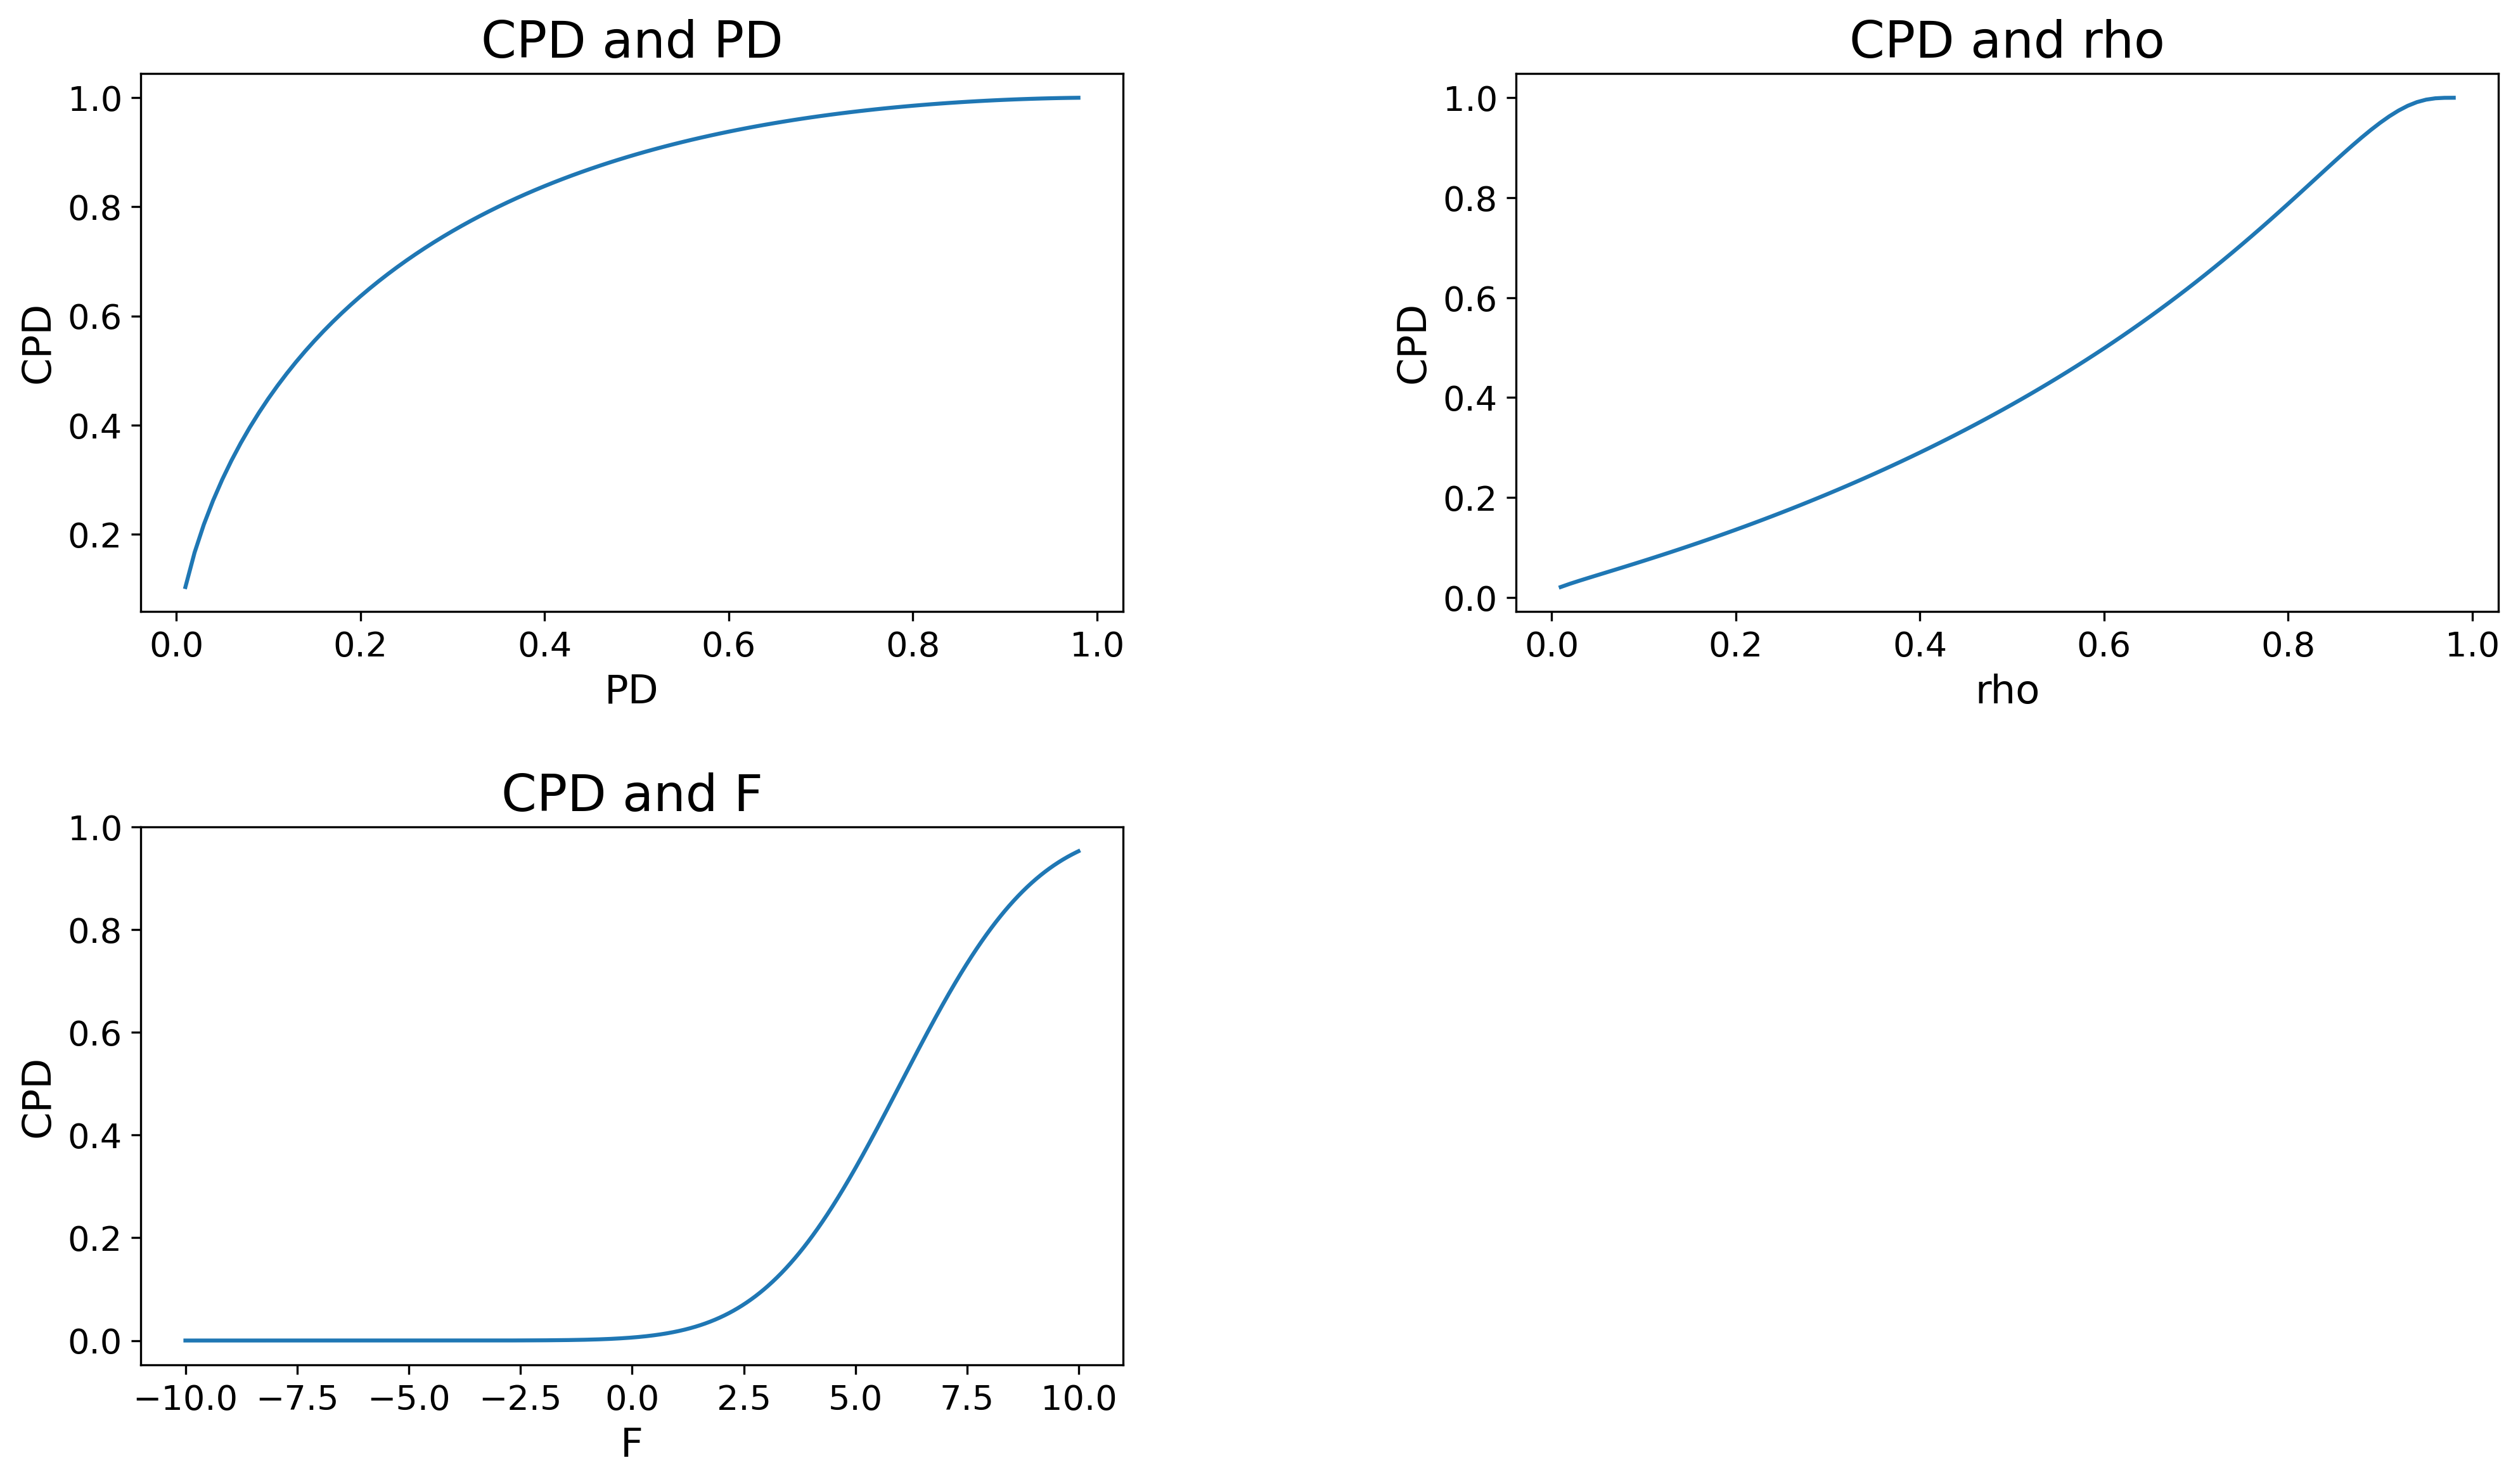

In [60]:
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(221)
plt.plot(PD_range, CPD_PD)
plt.xlabel("PD", fontsize=15)
plt.ylabel("CPD", fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.title('CPD and PD')

plt.subplot(222)
plt.plot(rho_range, CPD_rho)
plt.xlabel("rho", fontsize=15)
plt.ylabel("CPD", fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.title('CPD and rho')

plt.subplot(223)
plt.plot(F_range, CPD_F)
plt.xlabel("F", fontsize=15)
plt.ylabel("CPD", fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.title('CPD and F')
plt.show()

## Point-in-Time PDs

Worst case PDs (WCPD):
\begin{align*}
WCPD_{it}=\Phi\left[\frac{\Phi^{-1}(PD_{it})+\sqrt{\rho}\Phi^{-1}(0.999)}{\sqrt{1-\rho}}\right]
\end{align*}

Assumptions:
 - ASRF model;
 - 1 in 1,000 years stress of the systematic factor (0.999);
 - Set asset correlation, e.g., 15% for mortgages. 

In [61]:
model_lr4 = smf.glm('default_time ~ cep_time + equity_time + interest_rate_time + FICO_orig_time + gdp_time + PCA1_1 + PCA2_1 + PCA3_1 + PCA4_1 + PCA5_1 + cluster_1', family = sm.families.Binomial(), data=data).fit()

print(model_lr4.summary())

data.loc[:,'PD_logit_model'] = pd.DataFrame(model_lr4.fittedvalues, columns = ['PD_logit_model'] )

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                59001
Model:                            GLM   Df Residuals:                    58989
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6409.2
Date:                Mon, 15 Feb 2021   Deviance:                       12818.
Time:                        17:06:17   Pearson chi2:                 5.40e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.4511      0

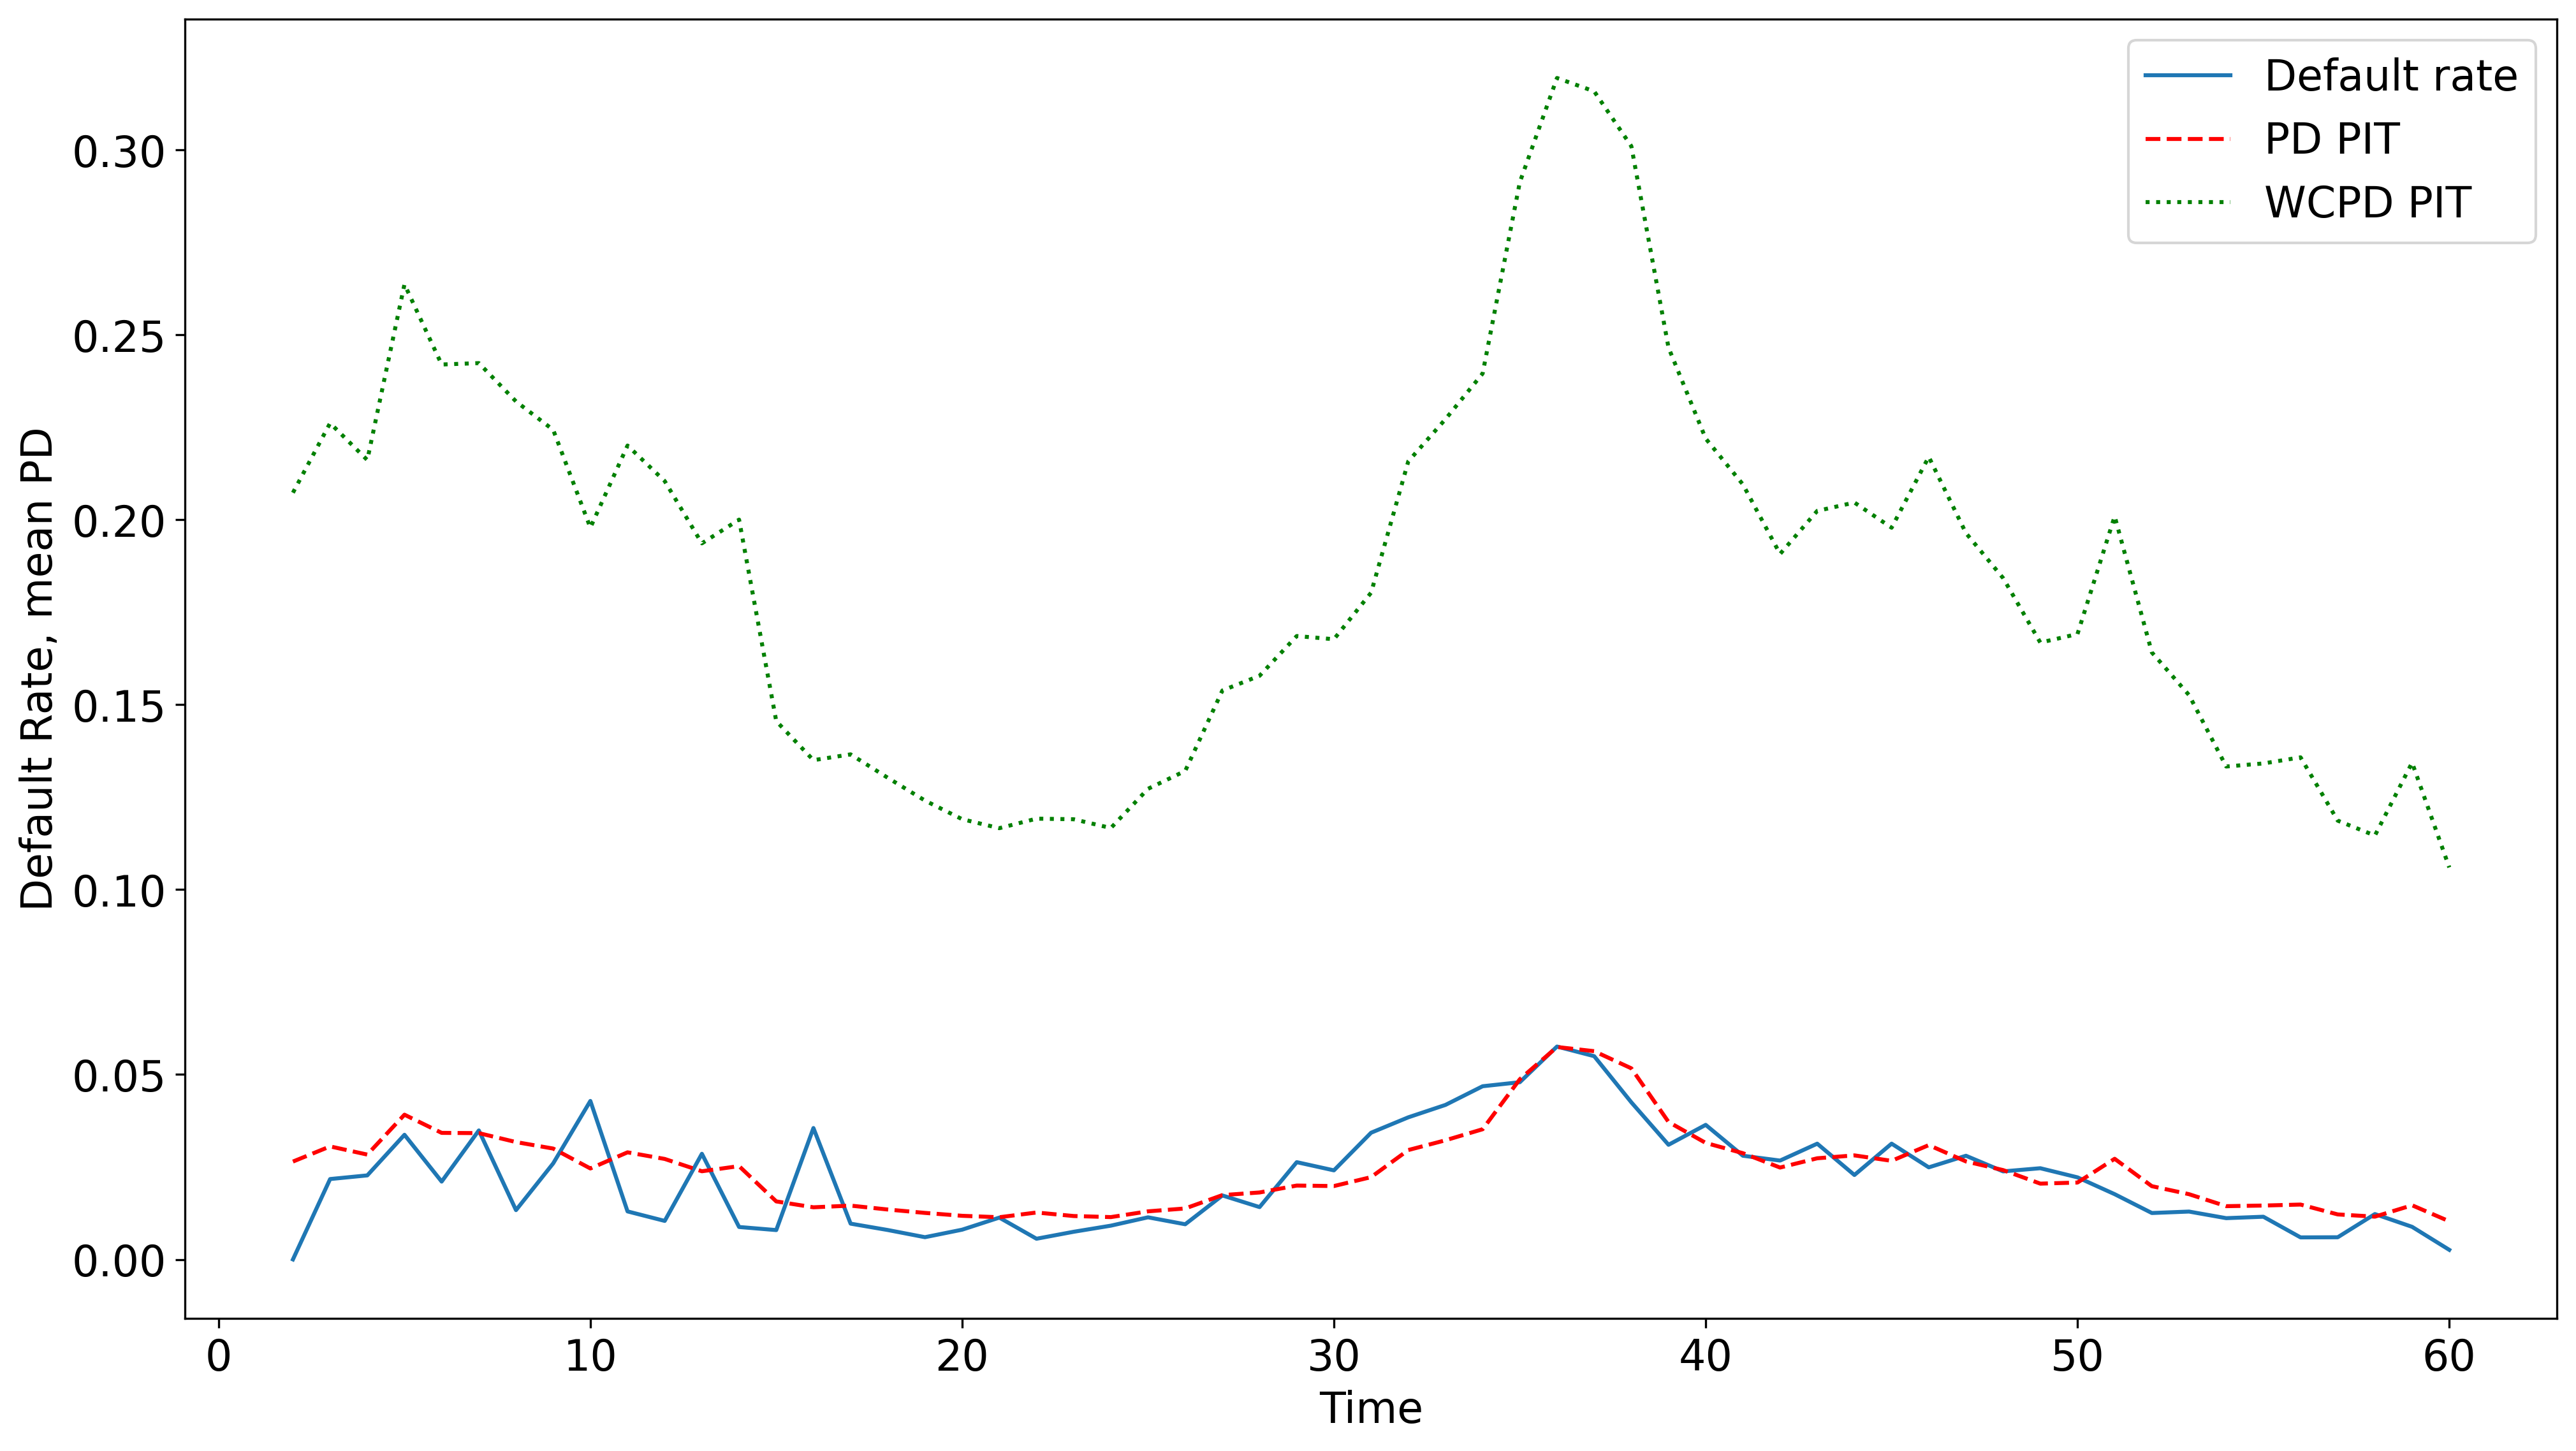

In [62]:
data.loc[:,'WCPD'] = norm.cdf((norm.ppf(data.loc[:,'PD_logit_model']) + sqrt(0.15) * norm.ppf(0.999)) / sqrt(1-0.15))

data_mean = data.groupby('time')[['default_time', 'PD_logit_model', 'WCPD']].mean().reset_index(drop=False)

plt.plot('time','default_time',data=data_mean,label='Default rate')
plt.plot('time','PD_logit_model',data=data_mean,color='red',label='PD PIT',linestyle='dashed')
plt.plot('time','WCPD',data=data_mean,color='green',label='WCPD PIT',linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Default Rate, mean PD')
plt.legend(loc='best')
plt.show()

## Through-the-Cycle PDs

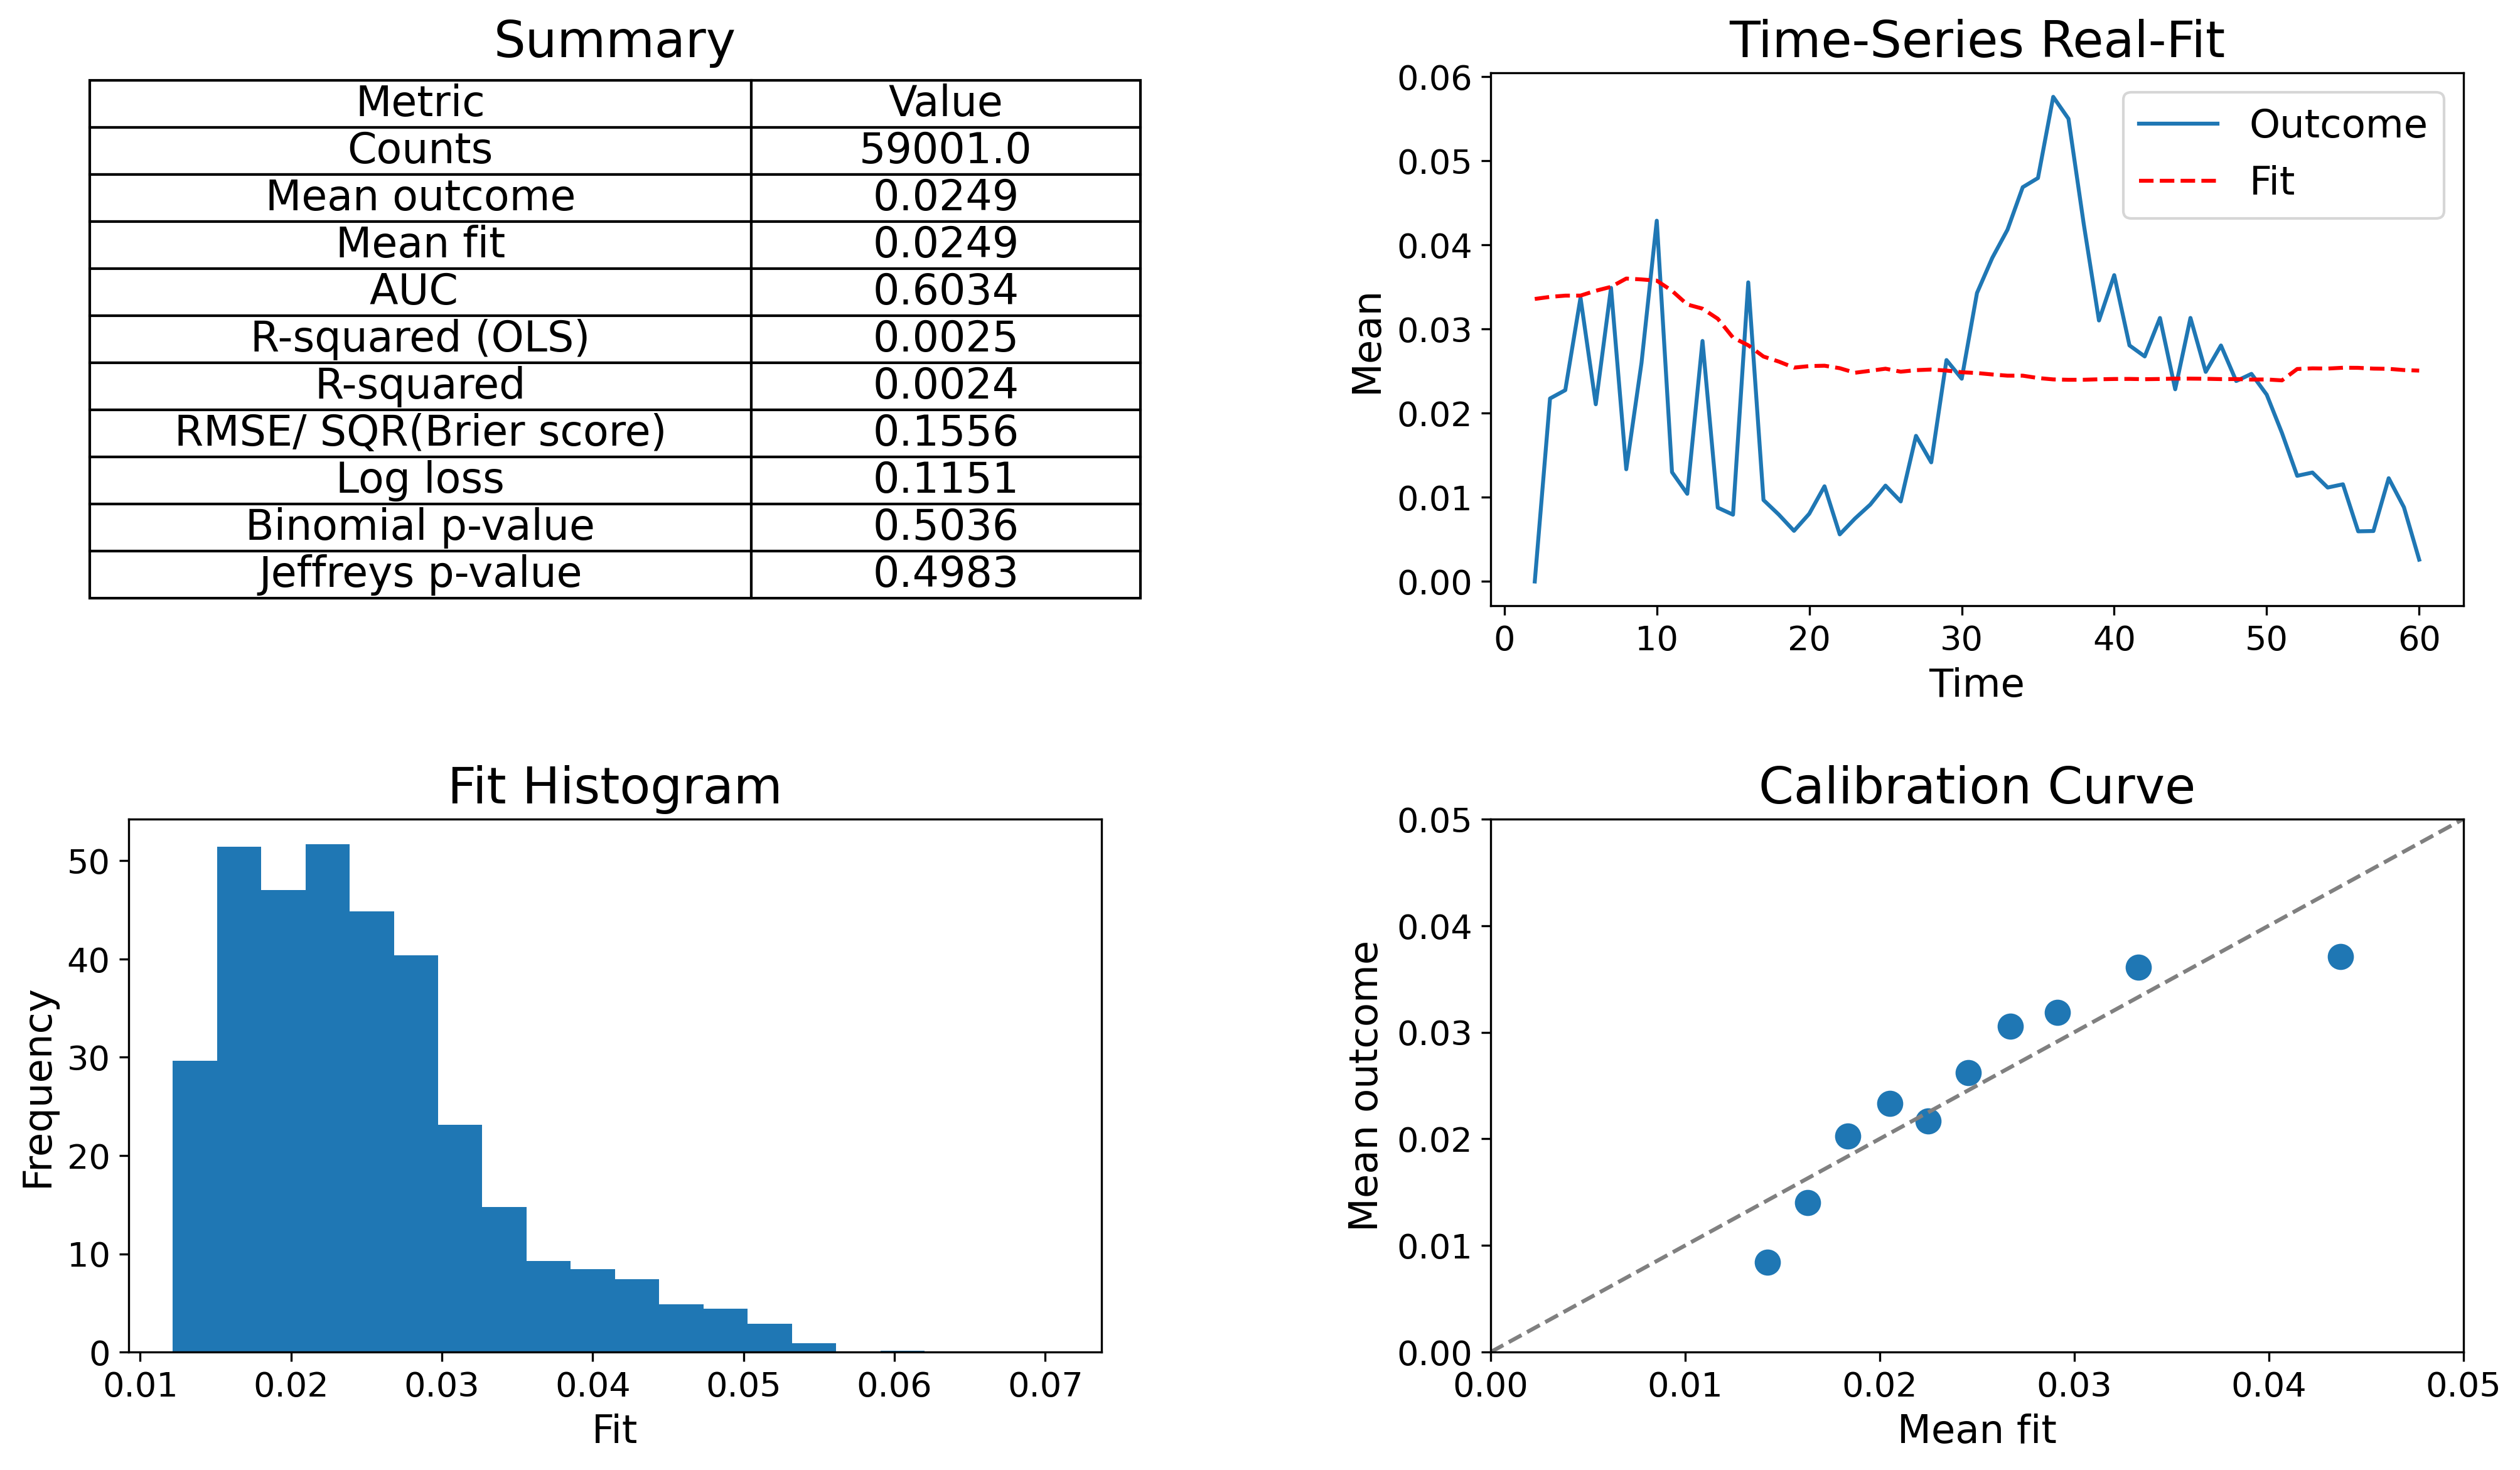

In [63]:
model_lr_ttc = smf.glm('default_time ~ FICO_orig_time', family = sm.families.Binomial(), data=data).fit()
data.loc[:,'PD_logit_model_TTC'] = pd.DataFrame(model_lr_ttc.fittedvalues, columns = ['PD_logit_model_TTC'] )

validation(data.PD_logit_model_TTC, data.default_time, data.time)

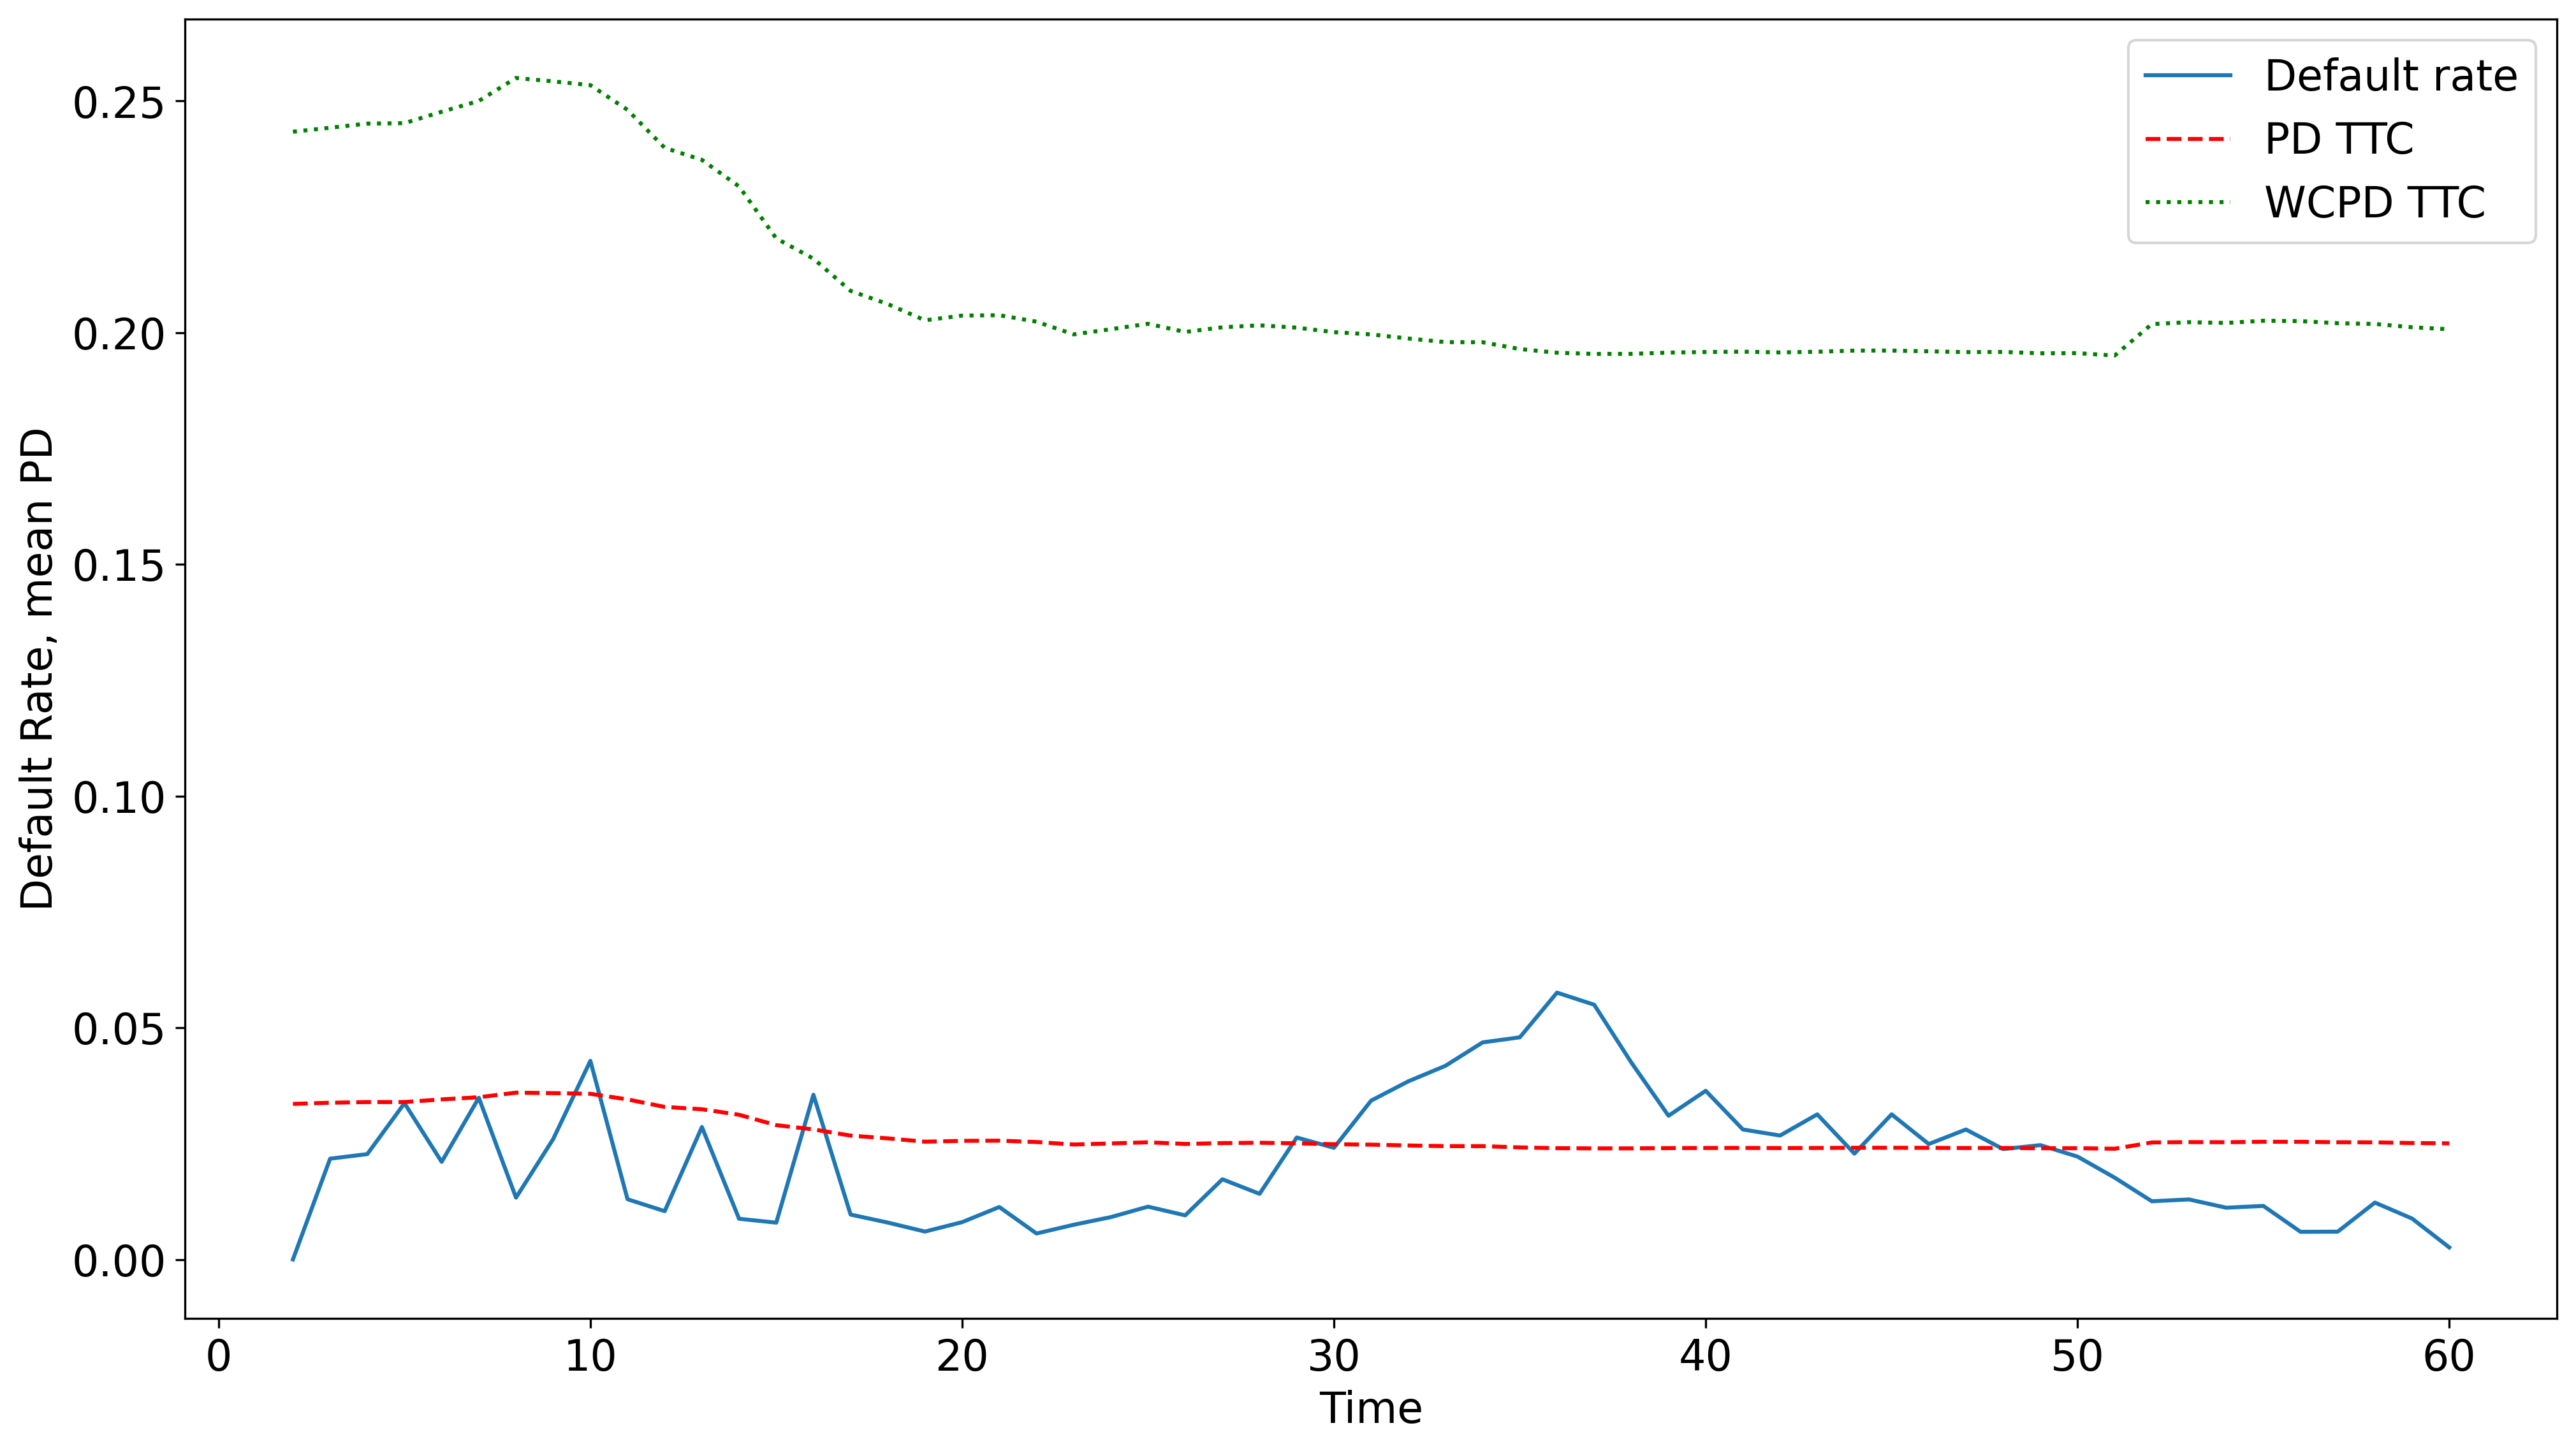

In [64]:
data.loc[:,'WCPD'] = norm.cdf((norm.ppf(data.loc[:,'PD_logit_model_TTC']) + sqrt(0.15) * norm.ppf(0.999)) / sqrt(1-0.15))

data_mean = data.groupby('time')[['default_time', 'PD_logit_model_TTC', 'WCPD']].mean().reset_index(drop=False)

plt.plot('time','default_time',data=data_mean,label='Default rate')
plt.plot('time','PD_logit_model_TTC',data=data_mean,color='red',label='PD TTC',linestyle='dashed')
plt.plot('time','WCPD',data=data_mean,color='green',label='WCPD TTC',linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Default Rate, mean PD')
plt.legend(loc='best')
plt.show()

## Basel Capital

Basel calculates $WCPD_{it}$ based on an:

 - One-year PDs
 - ASRF model
 - One in 1,000 years stress of the systematic factor (0.999)
 - Asset correlation, e.g., 15% for mortgages

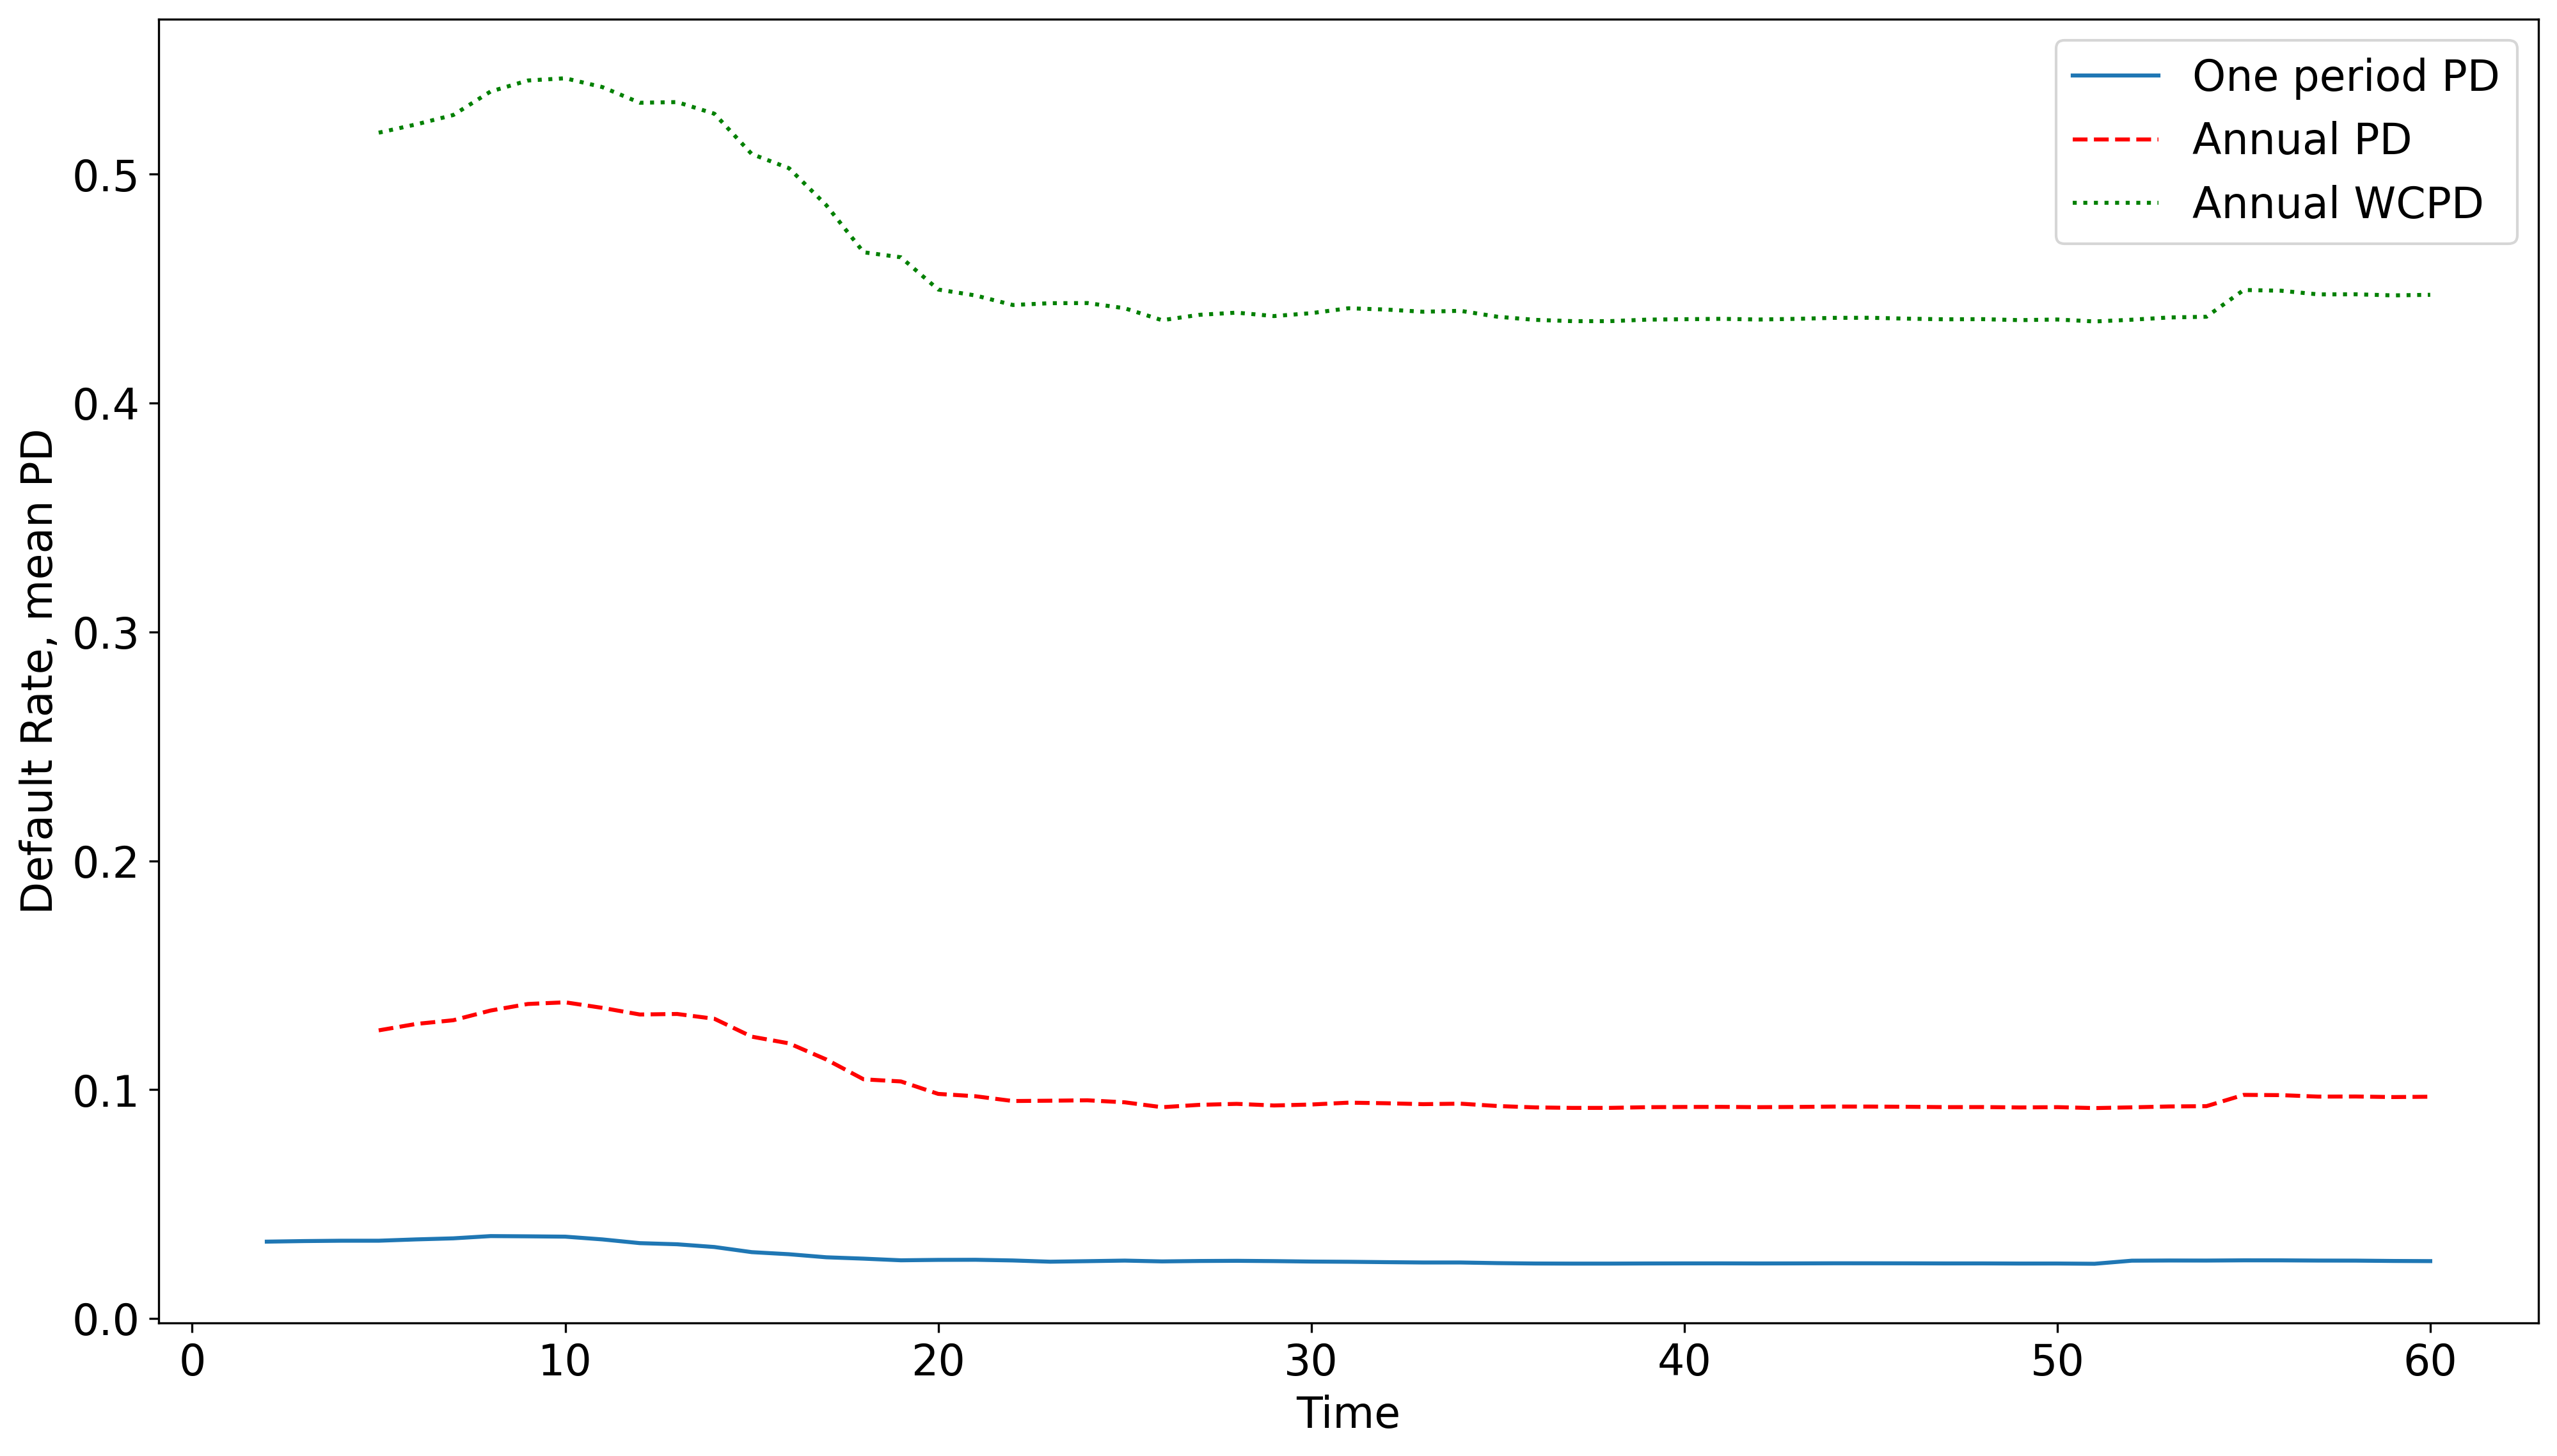

In [65]:
data.loc[:,'PD4'] = data.loc[:,'PD_logit_model_TTC']

data = data.sort_values(by=['id', 'time'])

data.loc[:,'PD3'] = data.groupby(['id'])['PD4'].shift(1)
data.loc[:,'PD2'] = data.groupby(['id'])['PD4'].shift(2)
data.loc[:,'PD1'] = data.groupby(['id'])['PD4'].shift(3)

data.loc[:,'PD_annual'] = data.loc[:,'PD1']+(1-data.loc[:,'PD1'])*data.loc[:,'PD2']+(1-data.loc[:,'PD1'])*(1-data.loc[:,'PD2'])*data.loc[:,'PD3']+(1-data.loc[:,'PD1'])*(1-data.loc[:,'PD2'])*(1-data.loc[:,'PD3'])*data.loc[:,'PD4']

data.loc[:,'WCPD_annual'] = norm.cdf((norm.ppf(data.loc[:,'PD_annual']) + sqrt(0.15) * norm.ppf(0.999)) / sqrt(1-0.15))

data_mean = data.groupby('time')[['PD4', 'PD_annual', 'WCPD_annual']].mean().reset_index(drop=False)

plt.plot('time','PD4',data=data_mean,label='One period PD') 
plt.plot('time','PD_annual',data=data_mean,color='red',label='Annual PD',linestyle='dashed')
plt.plot('time','WCPD_annual',data=data_mean,color='green',label='Annual WCPD',linestyle='dotted')
plt.xlabel('Time') 
plt.ylabel('Default Rate, mean PD')
plt.legend(loc='best')
plt.show()

# Stress-Testing

## EBA and FRB Stress-Testing

Common stress-tests focus on scenario-based stress-tests

Basel Committee on Banking Supervision (2006) mandates:
 - Economic or industry downturns
 - Market-place events, or
 - Decreased liquidity conditions

**In the US**, the Federal Reserve Bank:

 - Dodd-Frank Act supervisory stress test (DFAST)
 - Comprehensive Capital Analysis and Review (CCAR) stress test

**In Europe**, the European Banking Authority (EBA) 

European Banking Authority (EBA), 2020 (see www.eba.europa.eu):

"[...] By 2022, the EU 

 - real GDP would decline by 4.3\% cumulatively, 
 - the unemployment rate would rise by 3.5 percentage points, 
 - equity prices in global financial markets would fall by 25\% in advanced economies and by 40\% in emerging economies, 
 - residential real estate prices would decline by 16\%, and 
 - commercial real estate prices would decline by 20\%."

## Scenario-Based Stress-Testing

In [66]:
data2 = data[['default_time', 'time', 'PD_logit_model']]

data_EBA = data.copy()
data_EBA.loc[:,'gdp_time'] = -4.3
PD_EBA = pd.DataFrame(model_lr4.predict(data_EBA), columns=['PD_EBA'])

data2 = pd.merge(data2, PD_EBA, right_index=True, left_index=True)

data_EBA2 = data.copy()
data_EBA2.loc[:,'gdp_time'] = -8.6
PD_EBA2 = pd.DataFrame(model_lr4.predict(data_EBA2), columns=['PD_EBA2'])

data2 = pd.merge(data2, PD_EBA2, right_index=True, left_index=True)

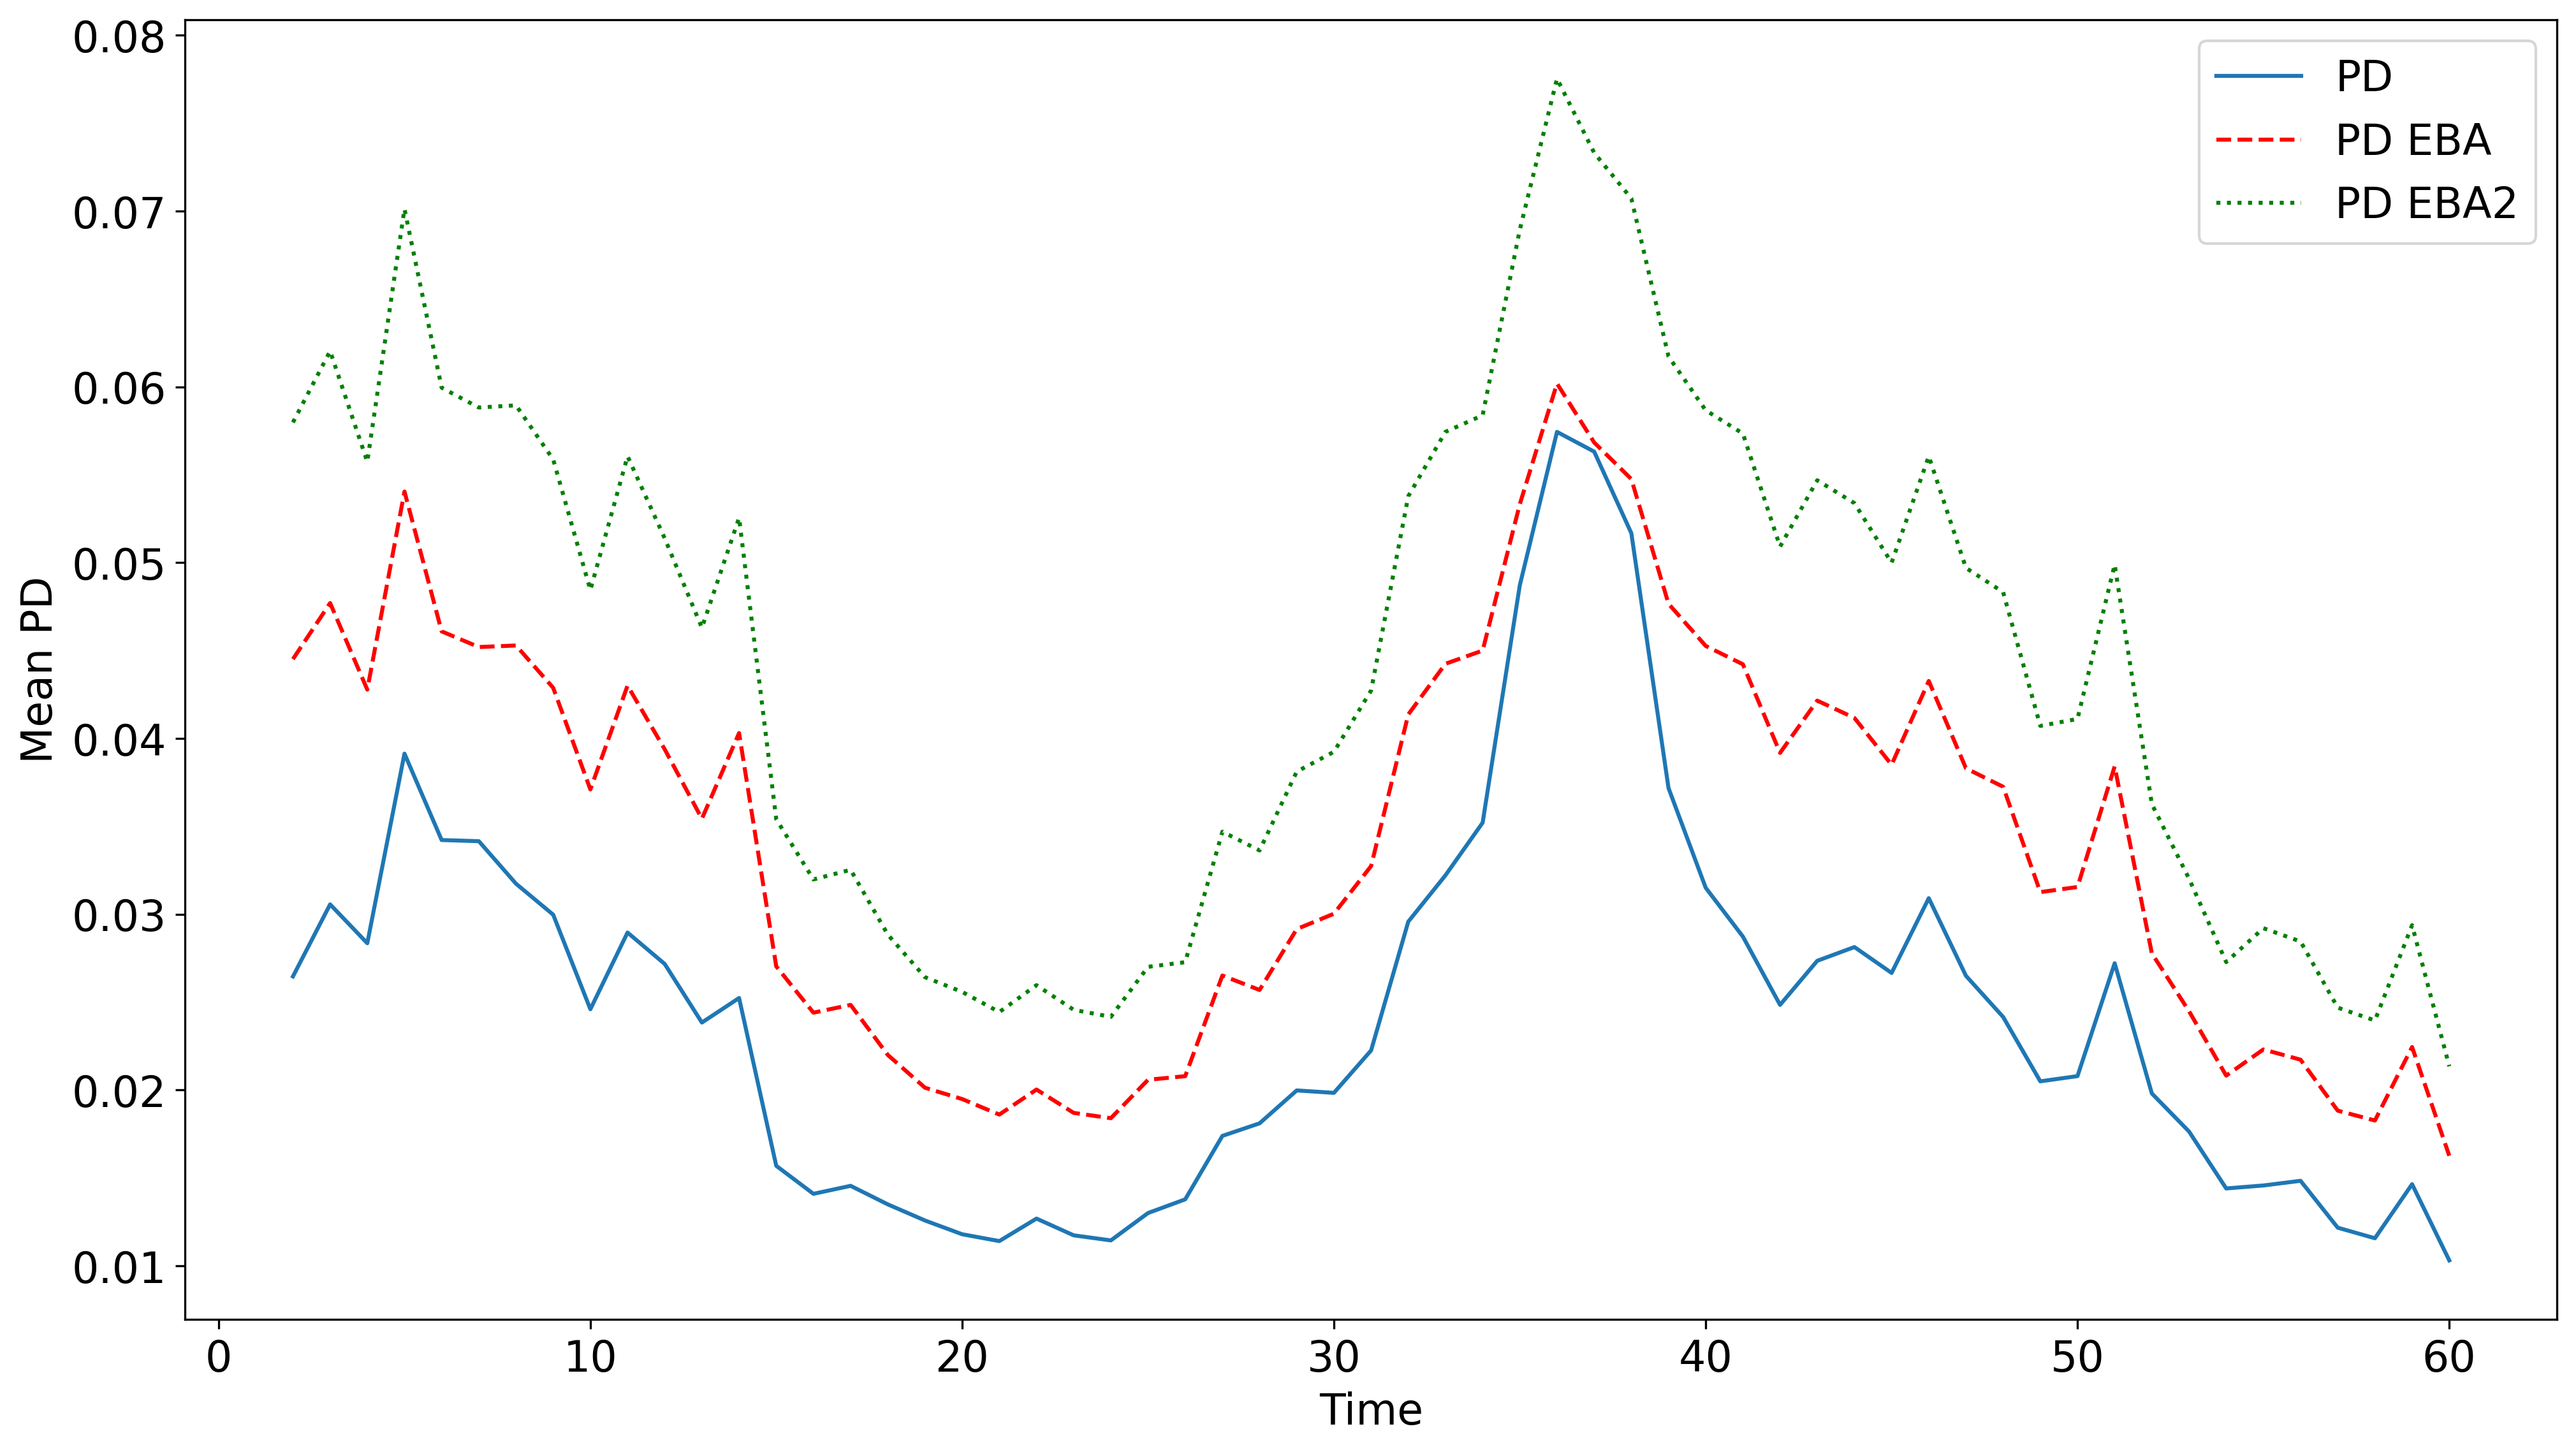

In [67]:
data2_mean = data2.groupby('time')[['PD_logit_model', 'PD_EBA', 'PD_EBA2']].mean().reset_index(drop=False)

plt.plot('time','PD_logit_model',data=data2_mean,label='PD')
plt.plot('time','PD_EBA',data=data2_mean,color='red',label='PD EBA',linestyle='dashed')
plt.plot('time','PD_EBA2',data=data2_mean,color='green',label='PD EBA2',linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Mean PD')
plt.legend(loc='best')
plt.show()

## Parameter-Based Stress-Testing

**Regime-Switching Approach**


Subsample two dataframes:

 - Downturn data: three-year period starting from period 27 to period 40
 - Upturn data: all other periods

In [68]:
downturn = data.loc[(data['time'] >= 27) & (data['time'] <= 40),:]
upturn = data.loc[(data['time'] < 27) | (data['time'] > 40),:]

print('Shape upturn sample:', upturn.shape)
print('Shape downturn sample:', downturn.shape)

Shape upturn sample: (31633, 54)
Shape downturn sample: (27368, 54)


In [69]:
model_lr4_downturn = smf.glm('default_time ~  cep_time + equity_time + interest_rate_time + FICO_orig_time + gdp_time + PCA1_1 + PCA2_1 + PCA3_1 + PCA4_1 + PCA5_1 + cluster_1', family = sm.families.Binomial(), data=downturn).fit()

print('Downturn model:')
print(model_lr4_downturn.summary())

Downturn model:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                27368
Model:                            GLM   Df Residuals:                    27356
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3939.5
Date:                Mon, 15 Feb 2021   Deviance:                       7879.1
Time:                        17:06:35   Pearson chi2:                 2.48e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           

In [70]:
model_lr4_upturn = smf.glm('default_time ~  cep_time + equity_time + interest_rate_time + FICO_orig_time + gdp_time + PCA1_1 + PCA2_1 + PCA3_1 + PCA4_1 + PCA5_1 + cluster_1', family = sm.families.Binomial(), data=upturn).fit()

print('Upturn model:')
print(model_lr4_upturn.summary())

Upturn model:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                31633
Model:                            GLM   Df Residuals:                    31621
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2430.9
Date:                Mon, 15 Feb 2021   Deviance:                       4861.8
Time:                        17:06:36   Pearson chi2:                 2.93e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             

In [71]:
data2 = data[['default_time', 'time', 'PD_logit_model']]

PD_downturn = pd.DataFrame(model_lr4_downturn.predict(data), columns=['PD_downturn'])

data2 = pd.merge(data2, PD_downturn, right_index=True, left_index=True)

PD_upturn = pd.DataFrame(model_lr4_upturn.predict(data), columns=['PD_upturn'])

data2 = pd.merge(data2, PD_upturn, right_index=True, left_index=True)

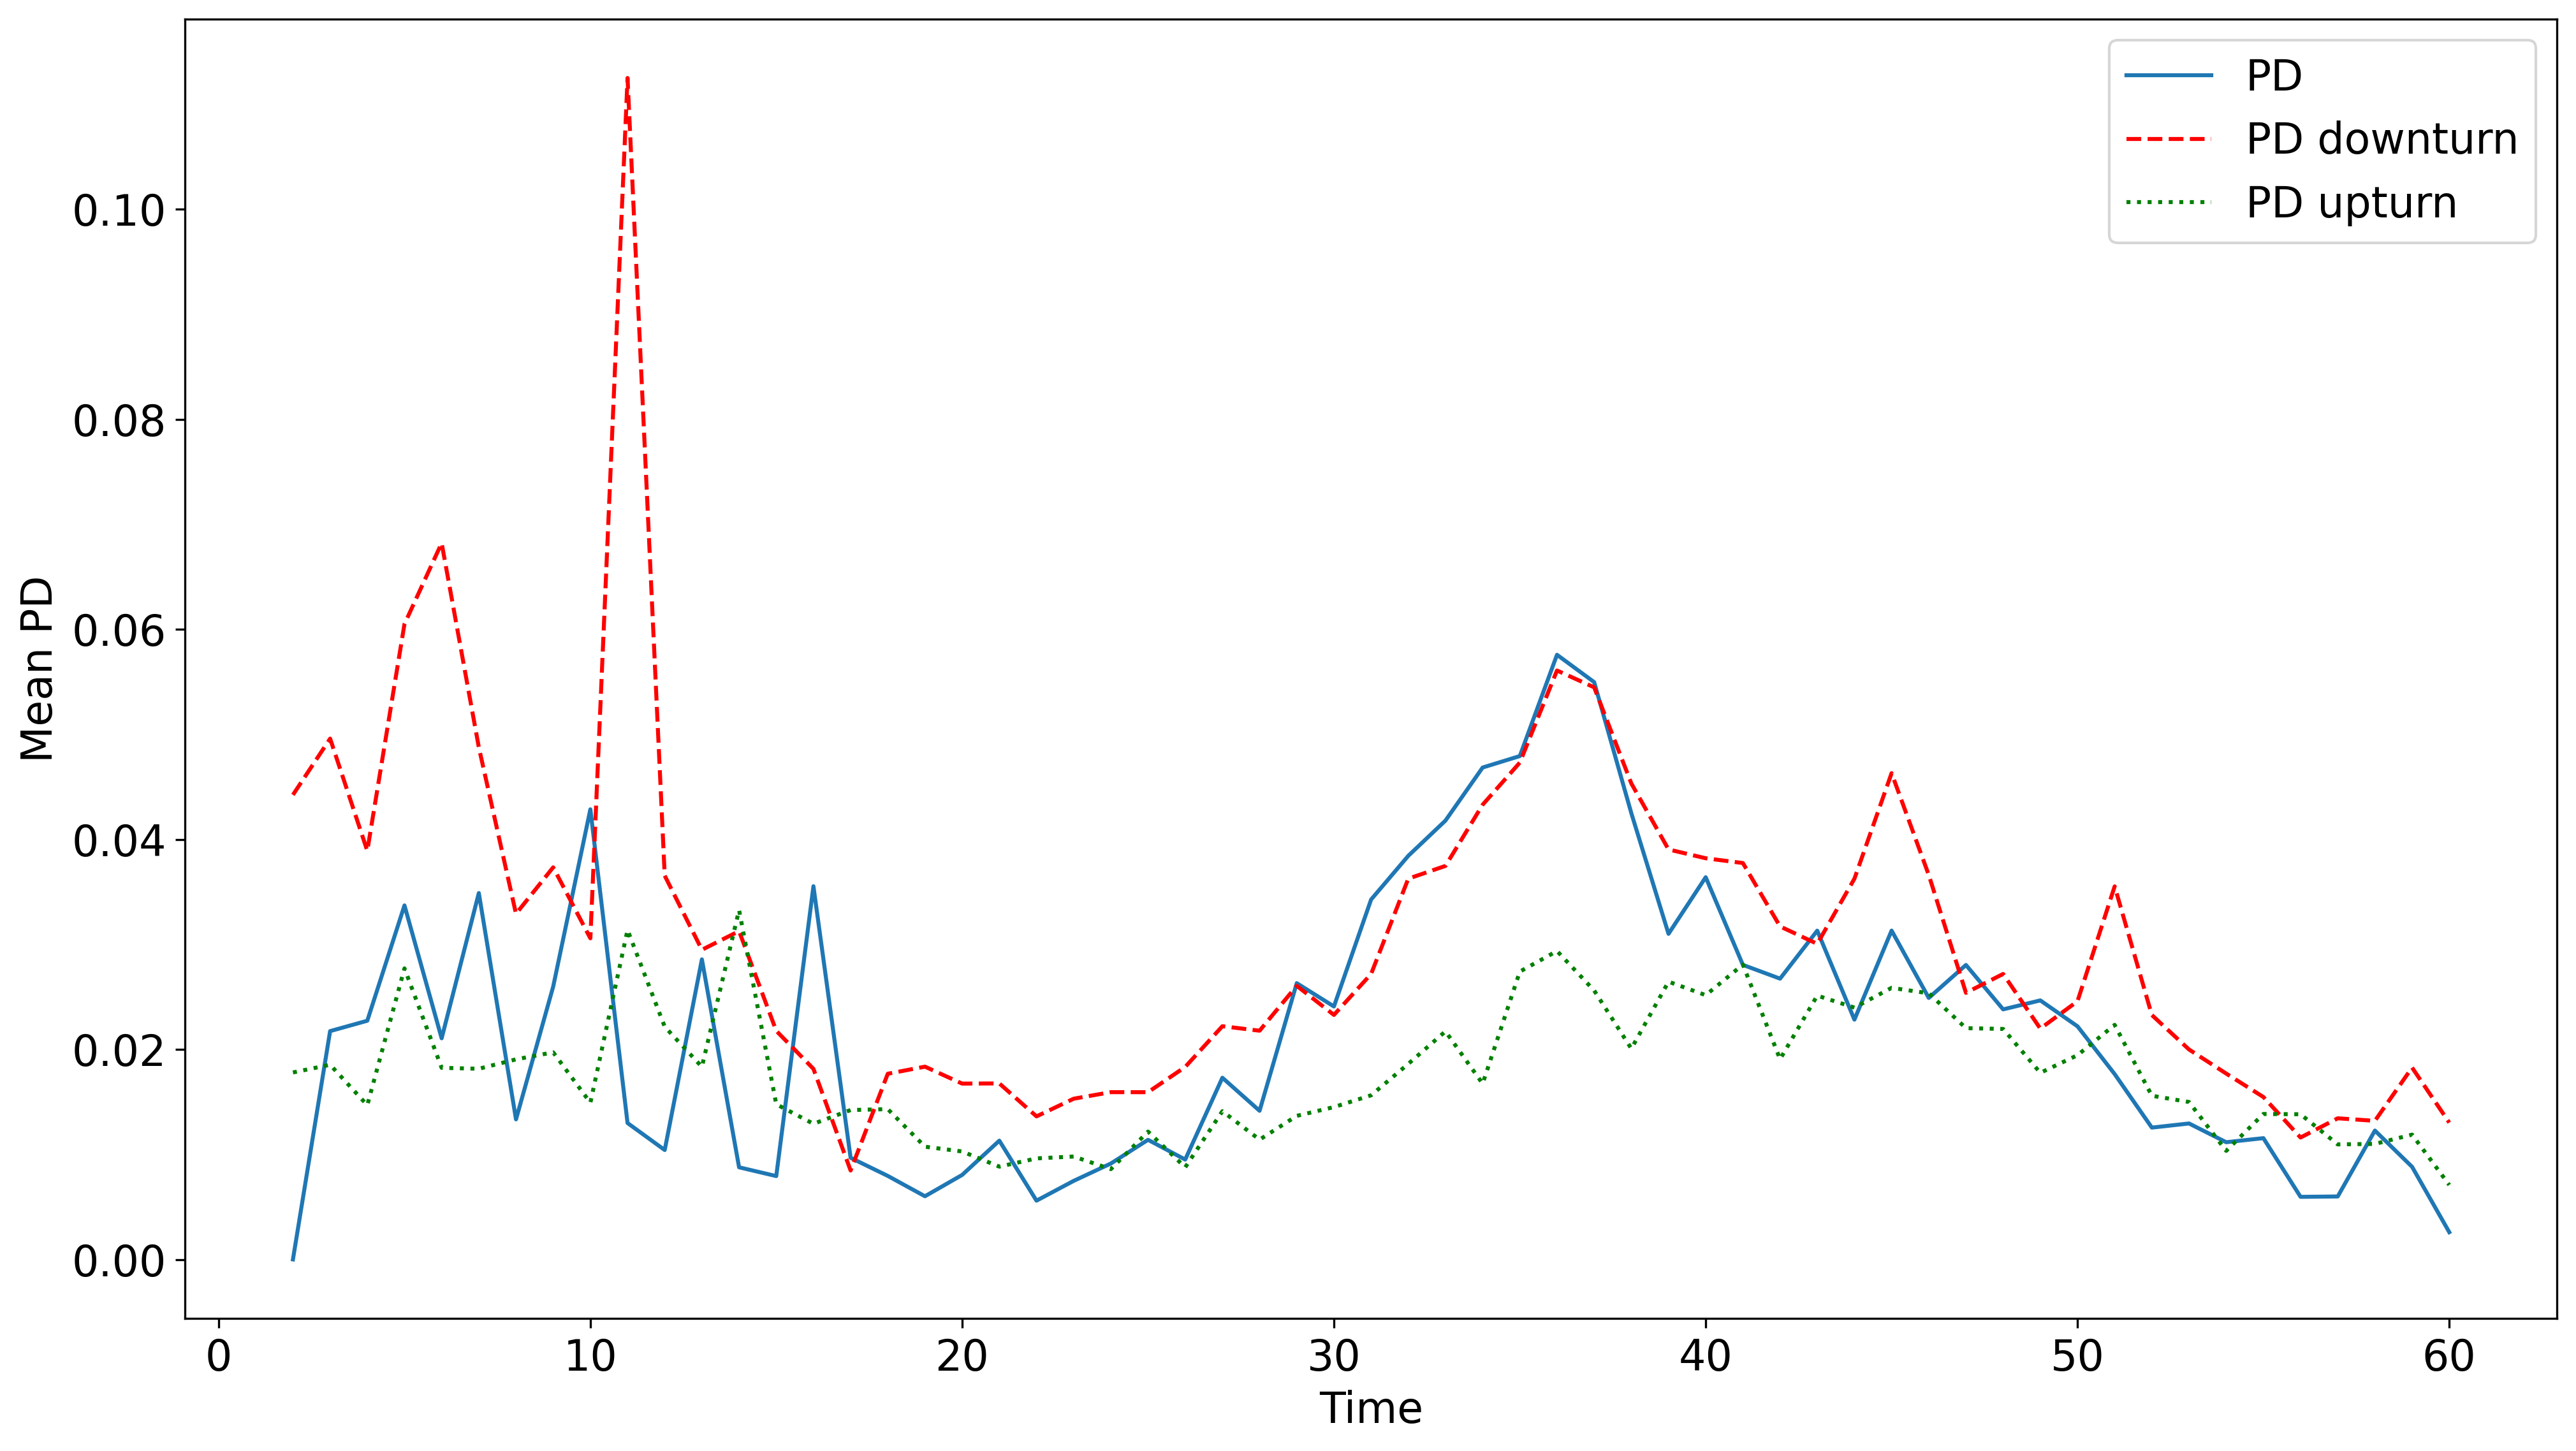

In [72]:
data2_mean = data2.groupby('time')[['PD_logit_model', 'PD_downturn', 'PD_upturn', 'default_time']].mean().reset_index(drop=False)

plt.plot('time','default_time',data=data2_mean,label='PD')
plt.plot('time','PD_downturn',data=data2_mean,color='red',label='PD downturn',linestyle='dashed')
plt.plot('time','PD_upturn',data=data2_mean,color='green',label='PD upturn',linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Mean PD')
plt.legend(loc='best')
plt.show()

**Margin of Conservatism**


Stress parameter estimates from the estimation results $\hat{\beta}$, assuming the estimates $\hat{\beta_j}, j=1,...J$ are normally distributed with mean $\hat\beta_j$) and the standard error SE($\hat\beta_j$) as standard deviation:
\begin{align*}
\hat\beta_j \pm \Phi^{-1}(1-\frac{\alpha}{J})*SE(\hat\beta_j)
\end{align*}


In [73]:
indicator = np.array([0, -1, +1, +1, +1, +1, 0, 0, 0, 0, 0, 0])

data['const'] = 1
y = data[['default_time']]
X_const = data[['const', 'cep_time', 'equity_time', 'interest_rate_time', 'FICO_orig_time', 'gdp_time', 'PCA1_1', 'PCA2_1', 'PCA3_1', 'PCA4_1', 'PCA5_1', 'cluster_1']]

model_lr4_SM = sm.Logit(y,X_const,missing='drop').fit()

print(model_lr4_SM.summary())

Optimization terminated successfully.
         Current function value: 0.108629
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           default_time   No. Observations:                59001
Model:                          Logit   Df Residuals:                    58989
Method:                           MLE   Df Model:                           11
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                 0.06732
Time:                        17:06:41   Log-Likelihood:                -6409.2
converged:                       True   LL-Null:                       -6871.9
Covariance Type:            nonrobust   LLR p-value:                2.319e-191
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.4511      0.352     -6.967      0.000      -3.141      -1.762
cep_t

In [74]:
params_stress = model_lr4_SM.params+indicator*norm.ppf(1-0.05/5)*model_lr4_SM.bse.values

PD_stress = pd.DataFrame(1/(1+exp(-(X_const.dot(params_stress)))), columns = ['PD_stress'] )

data2 = pd.merge(data, PD_stress, right_index=True, left_index=True)

params_stress2 = model_lr4_SM.params+indicator*norm.ppf(1-0.005/5)*model_lr4_SM.bse
PD_stress2 = pd.DataFrame(1/(1+exp(-(X_const.dot(params_stress2)))), columns = ['PD_stress2'] )

data2 = pd.merge(data2, PD_stress2, right_index=True, left_index=True)

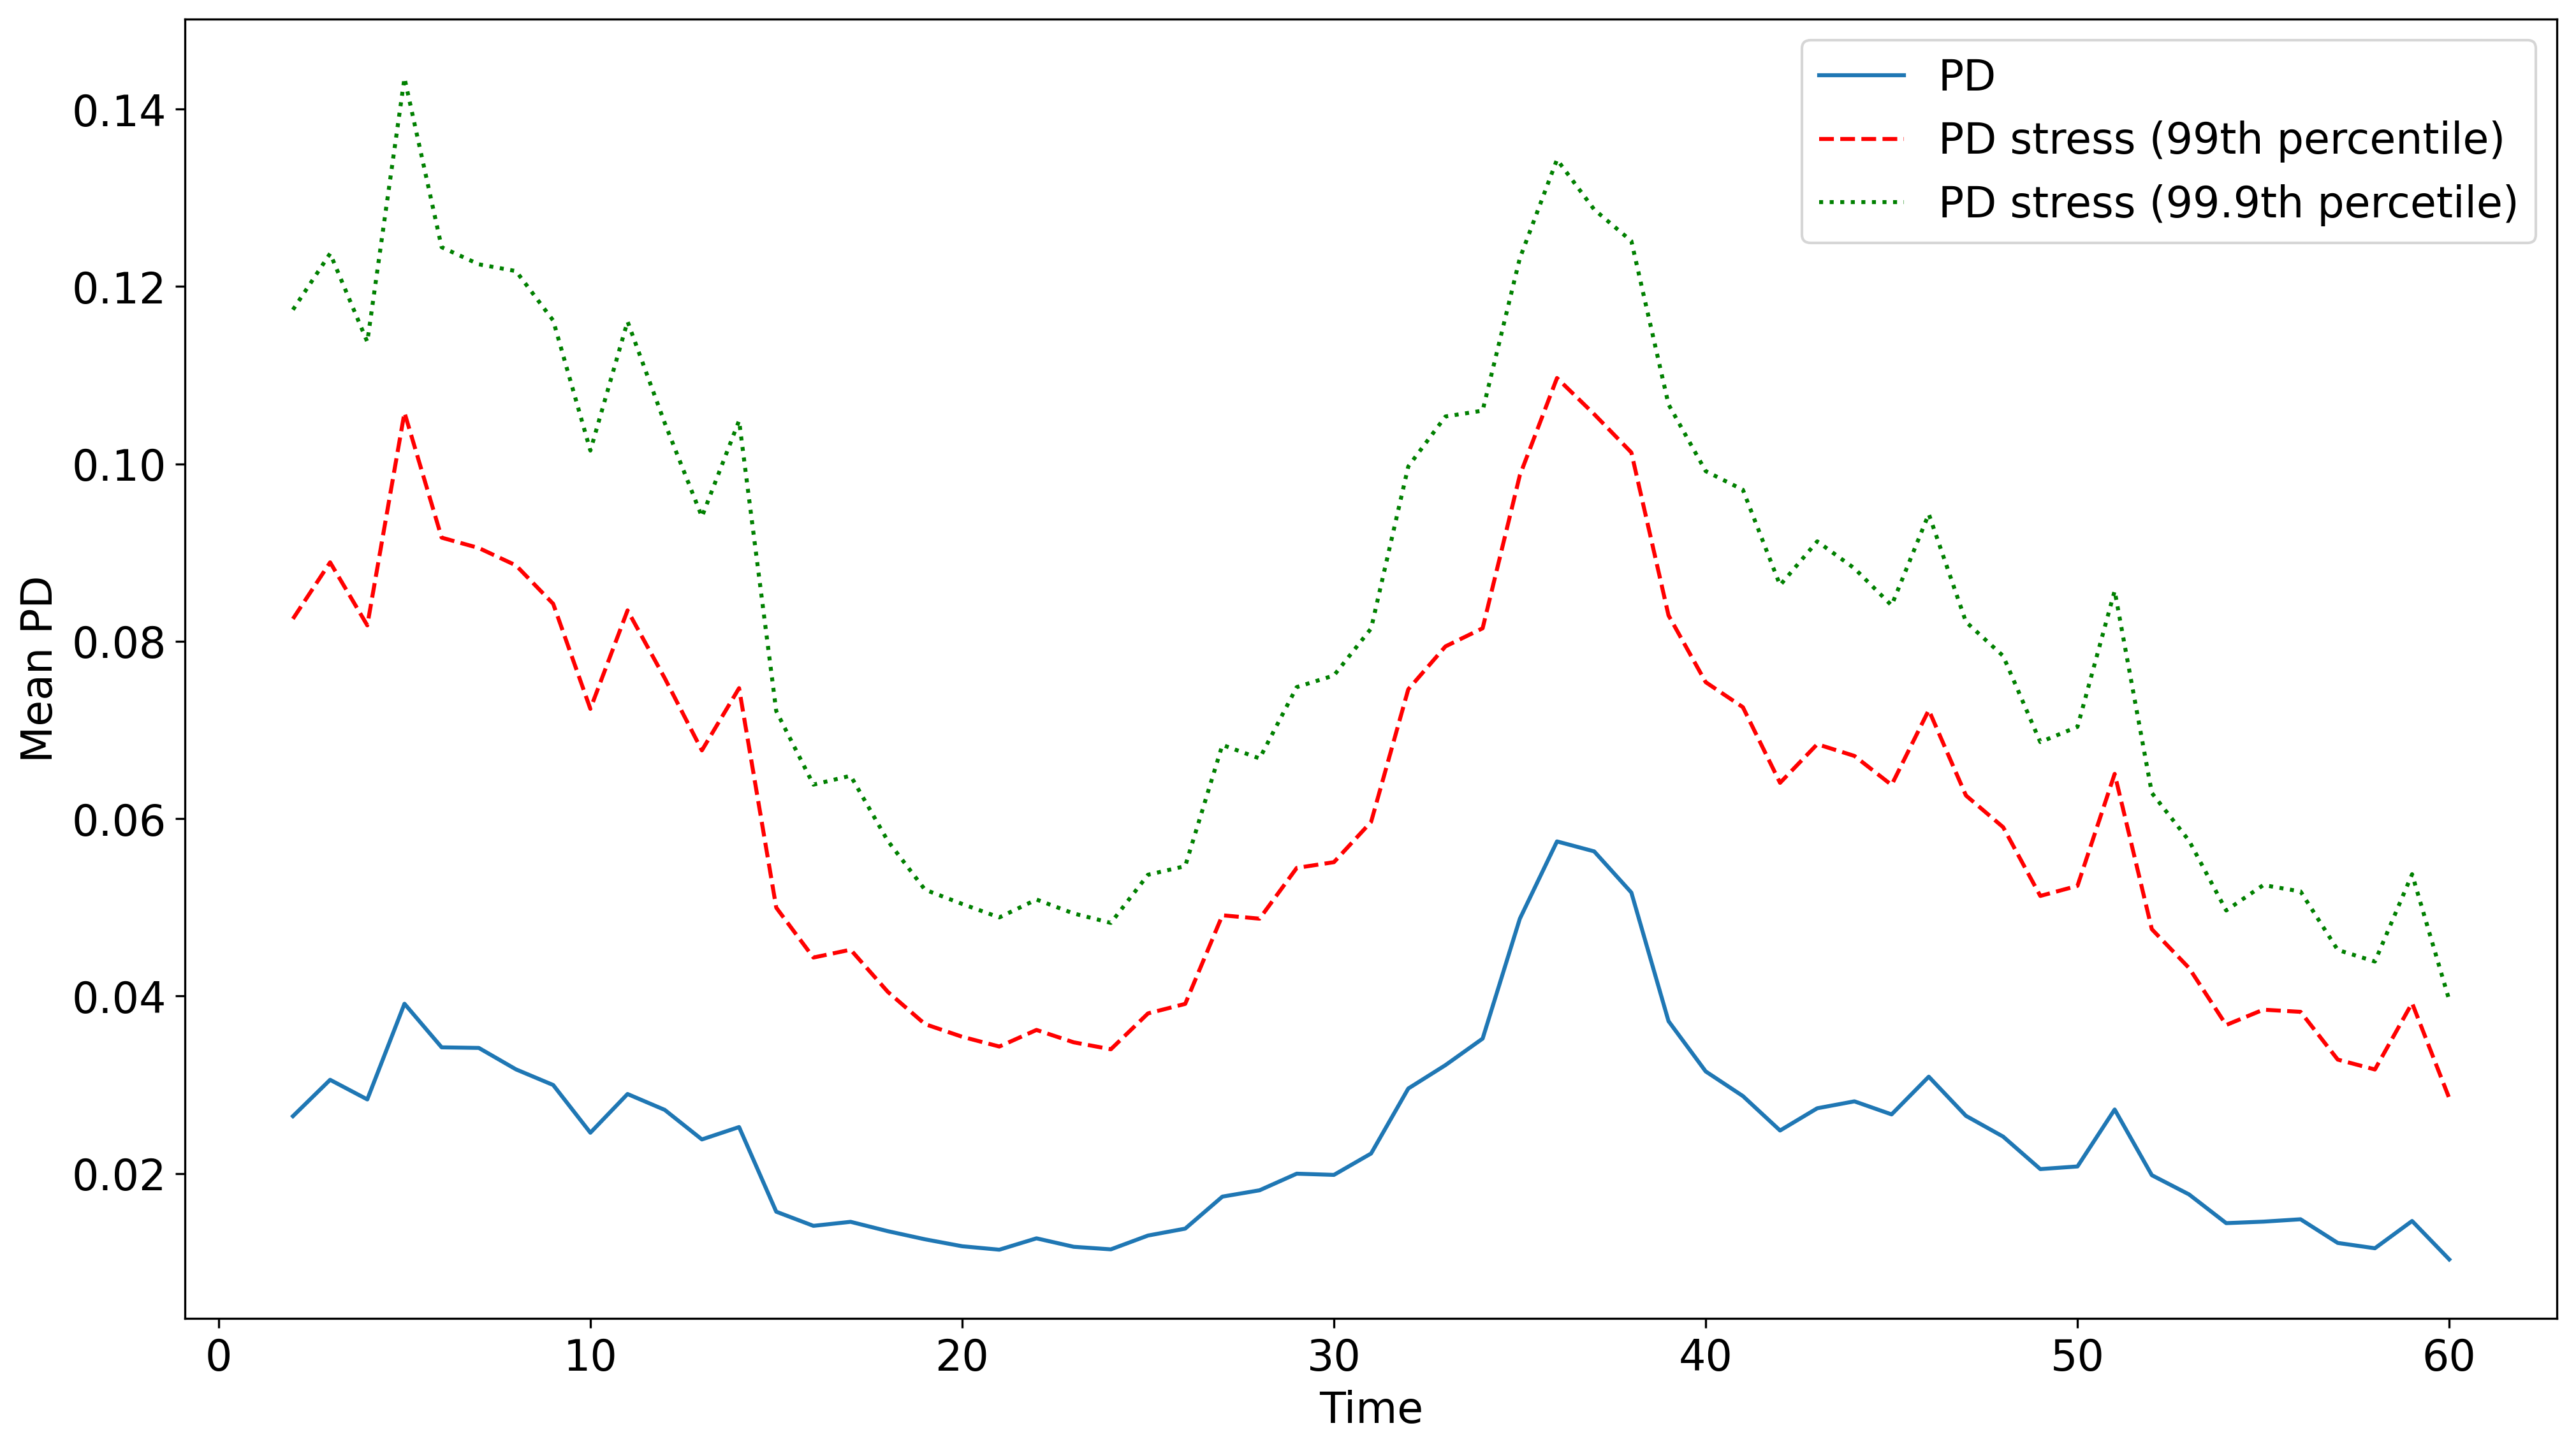

In [75]:
data2_mean = data2.groupby('time')[['PD_logit_model', 'PD_stress', 'PD_stress2']].mean().reset_index(drop=False)

plt.plot('time','PD_logit_model',data=data2_mean,label='PD')
plt.plot('time','PD_stress',data=data2_mean,color='red',label='PD stress (99th percentile)',linestyle='dashed')
plt.plot('time','PD_stress2',data=data2_mean,color='green',label='PD stress (99.9th percetile)',linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Mean PD')
plt.legend(loc='best')
plt.show()

# CECL & IFRS 9 PD Models

## Data Preprocessing

In [76]:
import warnings; warnings.simplefilter('ignore')
from dcr import *
import lifelines as ll
from lifelines import CoxPHFitter
from lifelines import CoxTimeVaryingFitter
from lifelines import WeibullAFTFitter

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams.update({'font.size': 16})

data, _, _, _, _, _, _ = dataprep(data)

## Basel vs. IFRS 9/CECL

Multi-period PD is key for CECL and IFRS 9: age and macroeconomy 

 - Basel: 12-month expected loss, Through-the-Cycle (TTC)
 - CECL: lifetime expected losses (LEL), Point-in-Time (PIT) approach
 - IFRS 9: three-stage approach
  - Stage 1: performing assets, 12-month EL
  - Stage 2: significant increase in default risk (SICR), LEL
  - Stage 3: impaired assets, workout EL

## Outcomes by Age

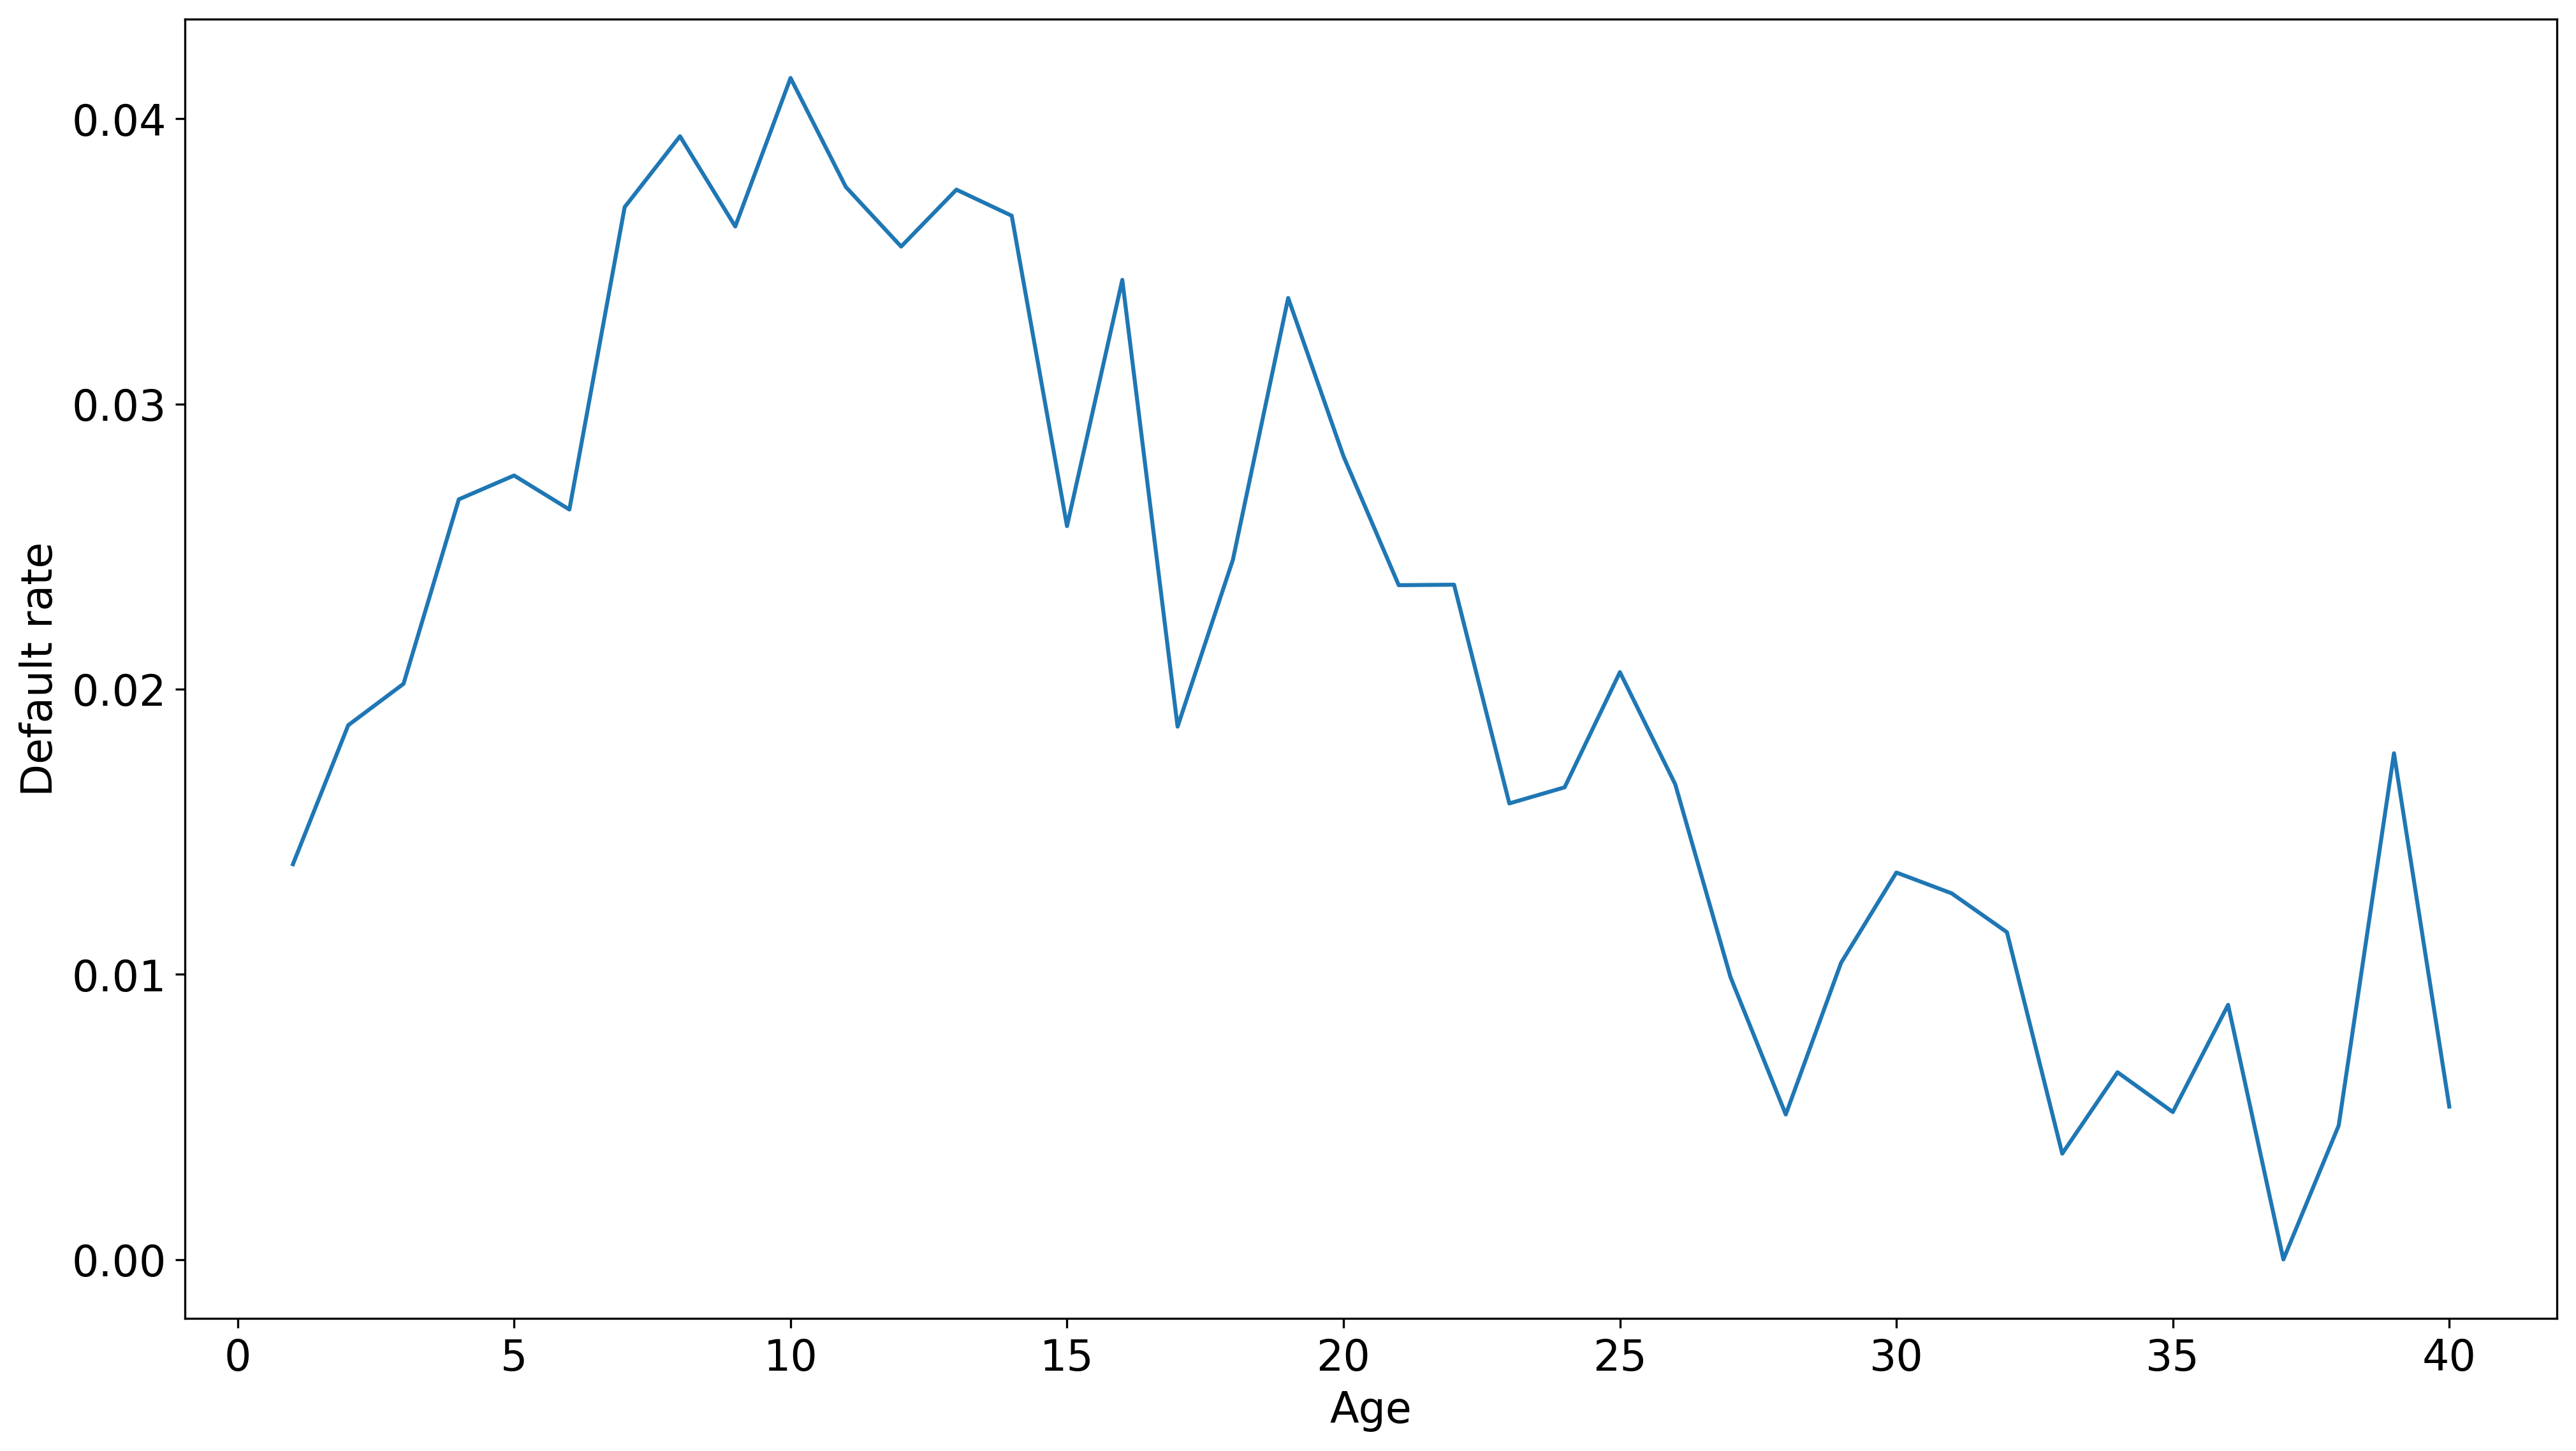

In [77]:
data_mean_age = data.groupby('age')['default_time'].mean().reset_index(drop=False)

plt.plot('age', 'default_time', data=data_mean_age)
plt.xlabel('Age')
plt.ylabel('Default rate')
plt.show()

## PD Models

 - Roll Rate Models
 - Age Feature Models
 - Survival Models

## Roll Rate Analysis

### Rating Classification Criteria

In [78]:
model_lr0 = smf.glm('default_time ~ cep_time + equity_time + interest_rate_time + FICO_orig_time + gdp_time + PCA1_1 + PCA2_1 + PCA3_1 + PCA4_1 + PCA5_1 + cluster_1', family = sm.families.Binomial(), data=data).fit()

PD = pd.DataFrame(model_lr0.fittedvalues,columns = ['PD'] )
roll_rates = pd.merge(data[['id', 'time', 'default_time']], PD, right_index=True, left_index=True)

print(PD.describe().round(decimals=3))

              PD
count  59001.000
mean       0.025
std        0.023
min        0.001
25%        0.011
50%        0.018
75%        0.031
max        0.724


### Rating Class Formation


**Option 1: Equal Intervals**

In [79]:
roll_rates.loc[:,'rating1'], boundaries = pd.cut(roll_rates.PD, 5, labels=False, retbins=True)

print('Boundaries:', boundaries.round(decimals=2))

print('Frequency table of rating classes:')
print(pd.crosstab(roll_rates.rating1, columns='count', margins= True))

Boundaries: [0.   0.15 0.29 0.43 0.58 0.72]
Frequency table of rating classes:
col_0    count    All
rating1              
0        58797  58797
1          198    198
2            4      4
4            2      2
All      59001  59001


**Option 2: Percentiles**

In [80]:
roll_rates.loc[:,'rating2'], boundaries = pd.qcut(roll_rates.PD, 5, labels=False, retbins=True)

print('Boundaries:', boundaries.round(decimals=2))

print('Frequency table of rating classes:')
print(pd.crosstab(roll_rates.rating2, columns='count', margins= True))

Boundaries: [0.   0.01 0.01 0.02 0.04 0.72]
Frequency table of rating classes:
col_0    count    All
rating2              
0        11801  11801
1        11800  11800
2        11800  11800
3        11800  11800
4        11800  11800
All      59001  59001


**Option 3: Bespoke classes**

In [81]:
roll_rates.loc[:,'rating3'], boundaries = pd.cut(roll_rates.PD, [0, 0.02, 0.03, 0.04, 0.06, 0.96], labels=False, retbins=True)

print('Boundaries:', boundaries.round(decimals=2))

print('Frequency table of rating classes:')
print(pd.crosstab(roll_rates.rating3, columns='count', margins= True))

Boundaries: [0.   0.02 0.03 0.04 0.06 0.96]
Frequency table of rating classes:
col_0    count    All
rating3              
0        32487  32487
1        10964  10964
2         6028   6028
3         5539   5539
4         3983   3983
All      59001  59001


**Which Classification Techniques Should You Use?**

In [82]:
rating1d = roll_rates.groupby('rating1')['default_time'].mean().reset_index(drop=False).rename(columns={'default_time': 'rating1d'})
rating2d = roll_rates.groupby('rating2')['default_time'].mean().reset_index(drop=False).rename(columns={'default_time': 'rating2d'})
rating3d = roll_rates.groupby('rating3')['default_time'].mean().reset_index(drop=False).rename(columns={'default_time': 'rating3d'})

roll_rates = pd.merge(roll_rates, rating1d, on='rating1')
roll_rates = pd.merge(roll_rates, rating2d, on='rating2')
roll_rates = pd.merge(roll_rates, rating3d, on='rating3')

We may generate the validation reports (not shown) and analyze AUC by the following codes:
    
 - `validation(roll_rates.PD,roll_rates.default_time,roll_rates.time)`
 - `validation(roll_rates.rating1d,roll_rates.default_time,roll_rates.time)`
 - `validation(roll_rates.rating2d,roll_rates.default_time,roll_rates.time)`
 - `validation(roll_rates.rating3d,roll_rates.default_time,roll_rates.time)`


###  Single-Period Rating Migrations

In [83]:
roll_rates2 = roll_rates.sort_values(['id', 'time'],ascending=[1,1])

lagid = (roll_rates2[['id']]).shift(1).copy()
lagid.columns = ['lagid']

lagrating2 = (roll_rates2[['rating2']]).shift(1).copy()
lagrating2.columns = ['lagrating2']
lagrating2[roll_rates2[['id']].values!= lagid[['lagid']].values] = np.nan

rating2 = roll_rates2[['rating2']].copy()
rating2.at[np.array(roll_rates2.default_time == 1),'rating2'] = 5

roll_rates3 = pd.concat([roll_rates2.id, roll_rates2.time, lagrating2, rating2], axis=1).copy()

roll_rates3 = roll_rates3.append({'id': 0,'time': 0, 'lagrating2':5, 'rating2':5}, ignore_index=True)

roll_rates3 = roll_rates3.dropna().copy()

In [84]:
table_absolute = pd.crosstab(roll_rates3.lagrating2,roll_rates3.rating2, margins= True).copy()

print(table_absolute.drop('All', axis='columns').drop('All', axis='rows').round(decimals=2))

rating2        0     1     2     3     4    5
lagrating2                                   
0.0         9676  1012    10     2     0   33
1.0         1104  7936  1671    24     0  120
2.0           39  1388  7267  1952    17  251
3.0           10    62  1362  7411  1680  390
4.0            1    14    37  1144  8992  608
5.0            0     0     0     0     0    1


In [85]:
table1 = table_absolute.div(table_absolute.iloc[:,6], axis='rows').iloc[0:6,0:6]

print(table1.round(decimals=2))

rating2       0     1     2     3     4     5
lagrating2                                   
0.0         0.9  0.09  0.00  0.00  0.00  0.00
1.0         0.1  0.73  0.15  0.00  0.00  0.01
2.0         0.0  0.13  0.67  0.18  0.00  0.02
3.0         0.0  0.01  0.12  0.68  0.15  0.04
4.0         0.0  0.00  0.00  0.11  0.83  0.06
5.0         0.0  0.00  0.00  0.00  0.00  1.00


### Multi-Period Rating Migrations

In [86]:
table2 = table1.dot(table1)

print(table2.round(decimals=2))

rating2        0     1     2     3     4     5
lagrating2                                    
0.0         0.82  0.15  0.02  0.00  0.00  0.01
1.0         0.17  0.56  0.22  0.03  0.00  0.02
2.0         0.02  0.18  0.49  0.24  0.03  0.05
3.0         0.00  0.02  0.17  0.50  0.23  0.07
4.0         0.00  0.00  0.02  0.16  0.71  0.11
5.0         0.00  0.00  0.00  0.00  0.00  1.00


### Multi-Period Cumulative Default Rates

In [87]:
table3 = table2.dot(table1)
table4 = table3.dot(table1)
table5 = table4.dot(table1)
table6 = table5.dot(table1)
table7 = table6.dot(table1)
table8 = table7.dot(table1)
table9 = table8.dot(table1)
table10 = table9.dot(table1)

cumDefault = pd.DataFrame(np.zeros(6))
cumDefault.loc[:,'1'] = table1.iloc[:,5]
cumDefault.loc[:,'2'] = table2.iloc[:,5]
cumDefault.loc[:,'3'] = table3.iloc[:,5]
cumDefault.loc[:,'4'] = table4.iloc[:,5]
cumDefault.loc[:,'5'] = table5.iloc[:,5]
cumDefault.loc[:,'6'] = table6.iloc[:,5]
cumDefault.loc[:,'7'] = table7.iloc[:,5]
cumDefault.loc[:,'8'] = table8.iloc[:,5]
cumDefault.loc[:,'9'] = table9.iloc[:,5]
cumDefault.loc[:,'10'] = table10.iloc[:,5]

cumDefault2 = cumDefault.transpose().reset_index()
cumDefault2.columns = ['period', 'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'default']

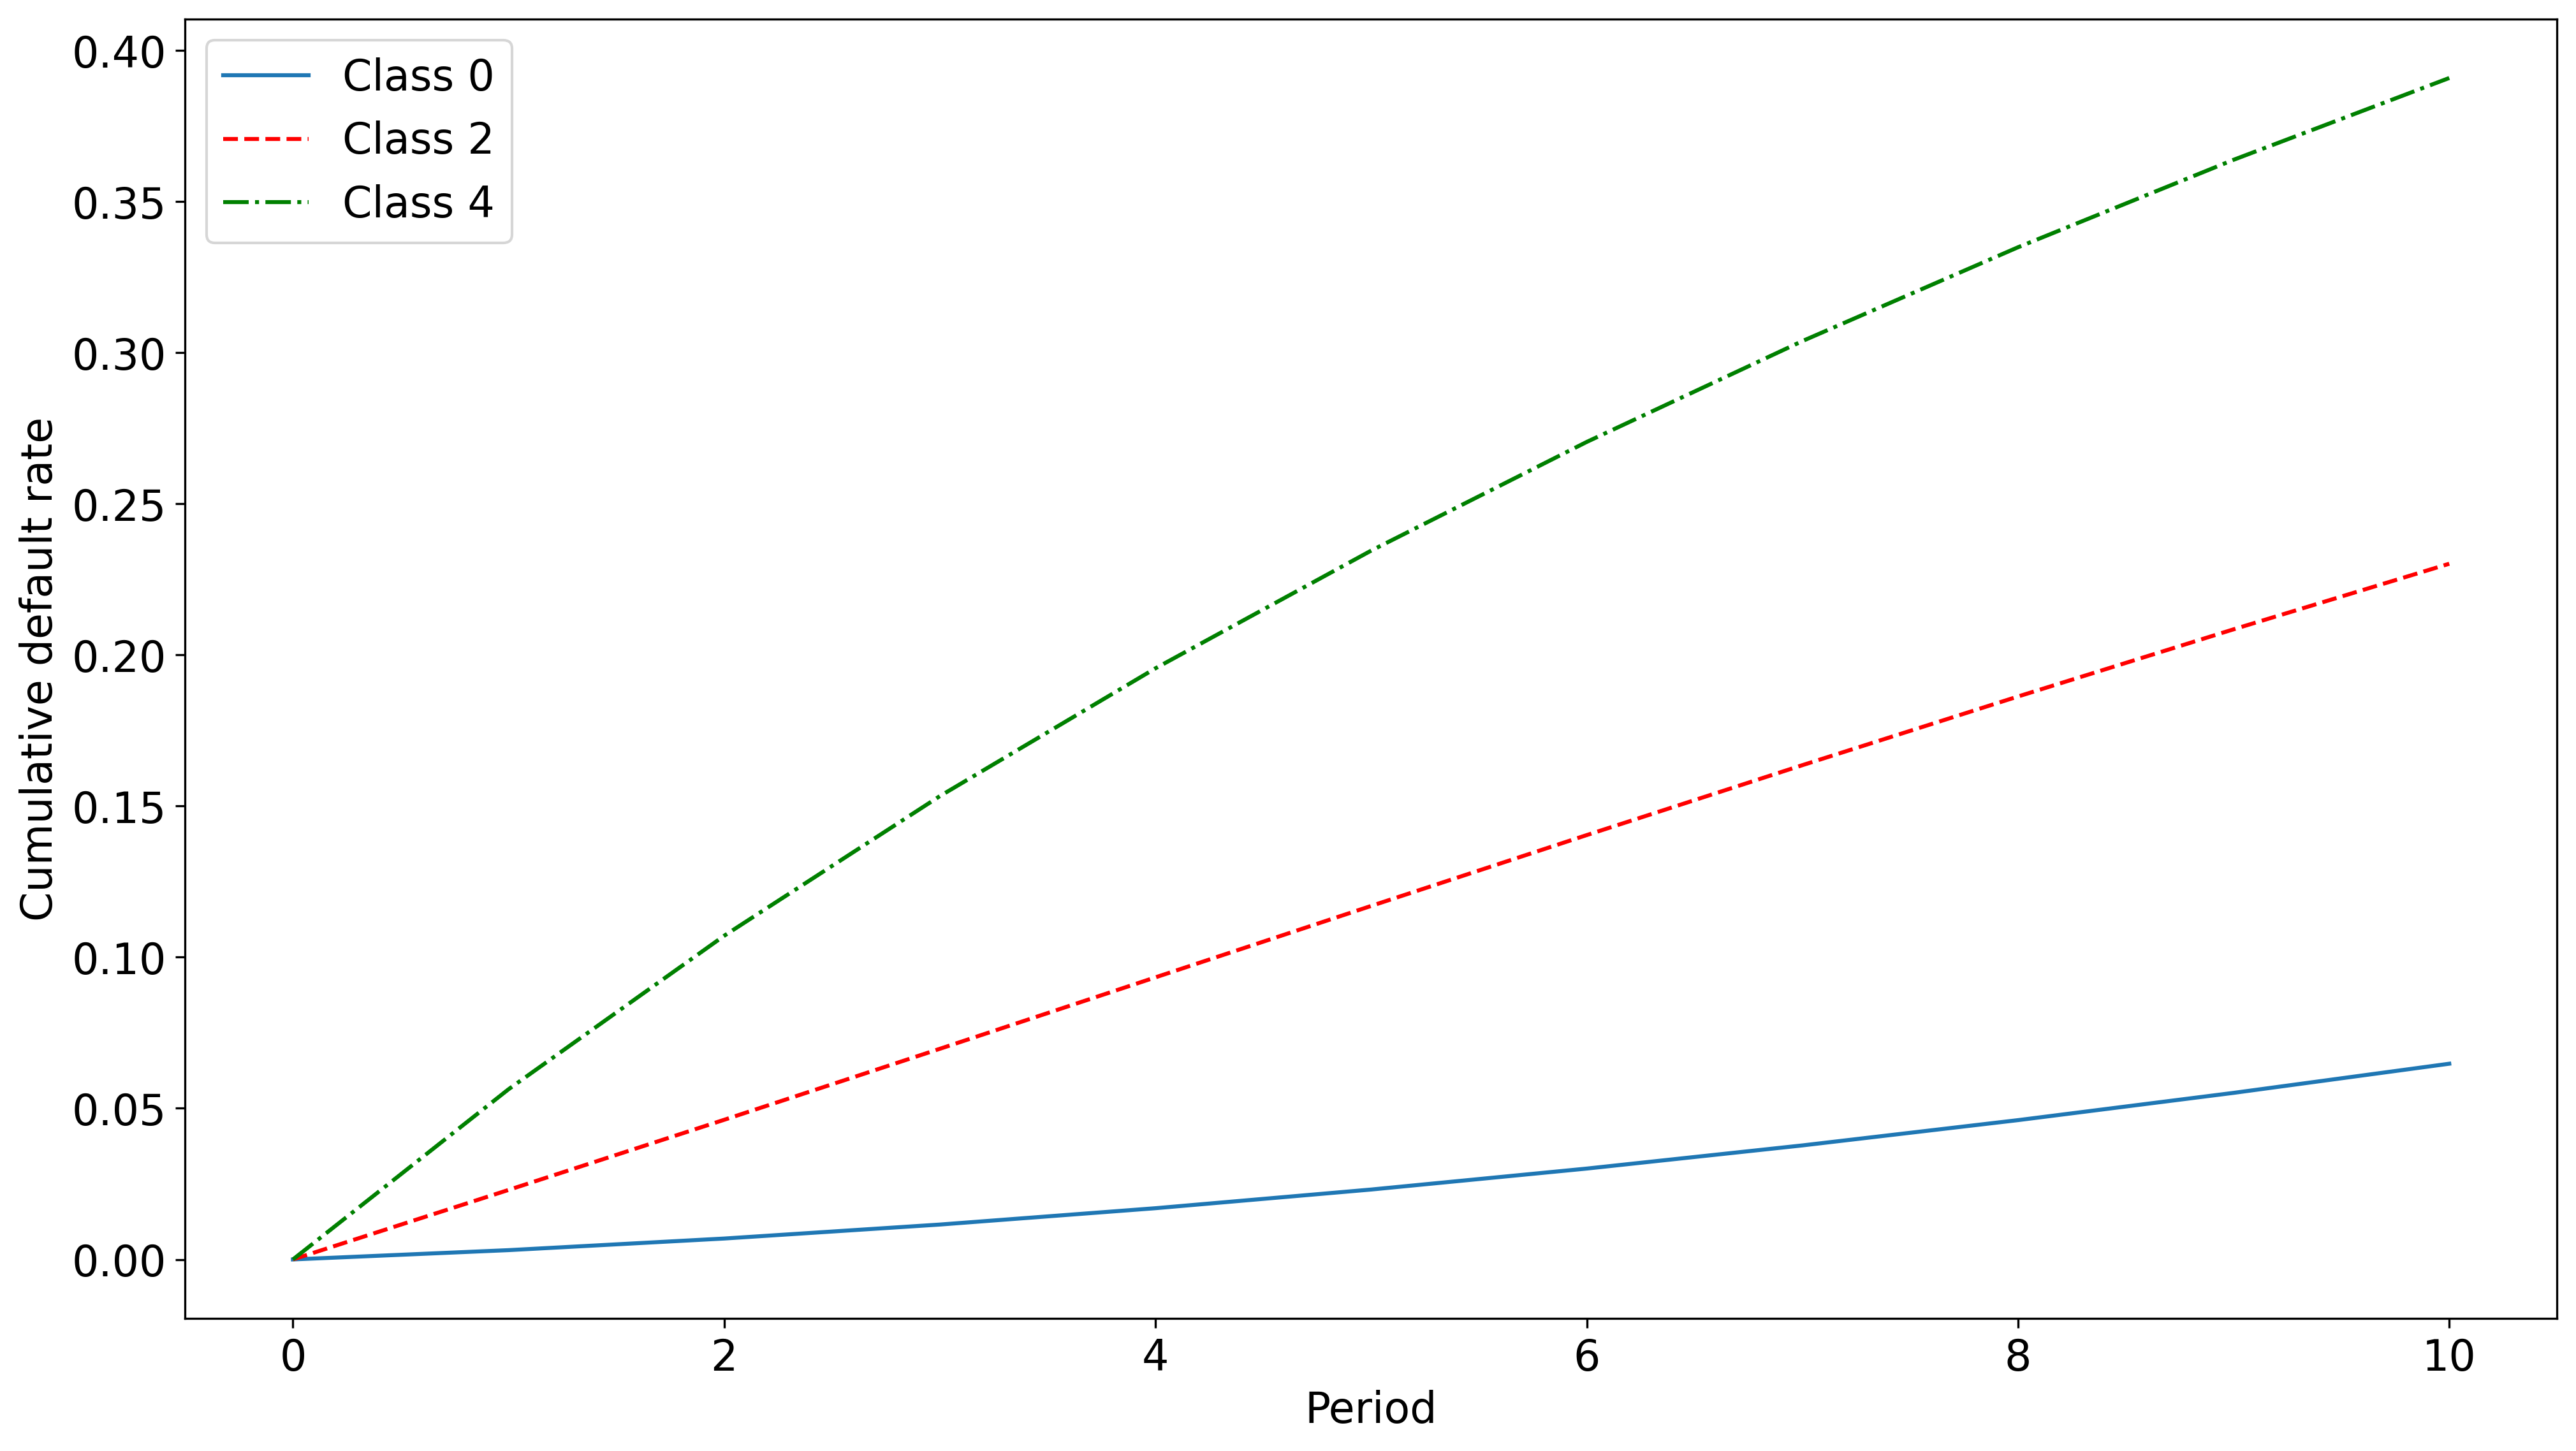

In [88]:
plt.plot(cumDefault2.period, cumDefault2.class_0, label='Class 0')
plt.plot(cumDefault2.period, cumDefault2.class_2, color='red', label='Class 2',linestyle='dashed')
plt.plot(cumDefault2.period, cumDefault2.class_4, color='green', label='Class 4',linestyle='dashdot')
plt.xlabel('Period')
plt.ylabel('Cumulative default rate')
plt.legend(loc='best')
plt.show()

### Multi-Period Marginal Default Rates

We compute the marginal default rates from the cumulative default rate for a given year $T$ and the prior year $T-1$:

\begin{align*}
MDR_T= \frac{CDR_T-CDR_{T-1}}{CDR_{T-1}}
\end{align*}


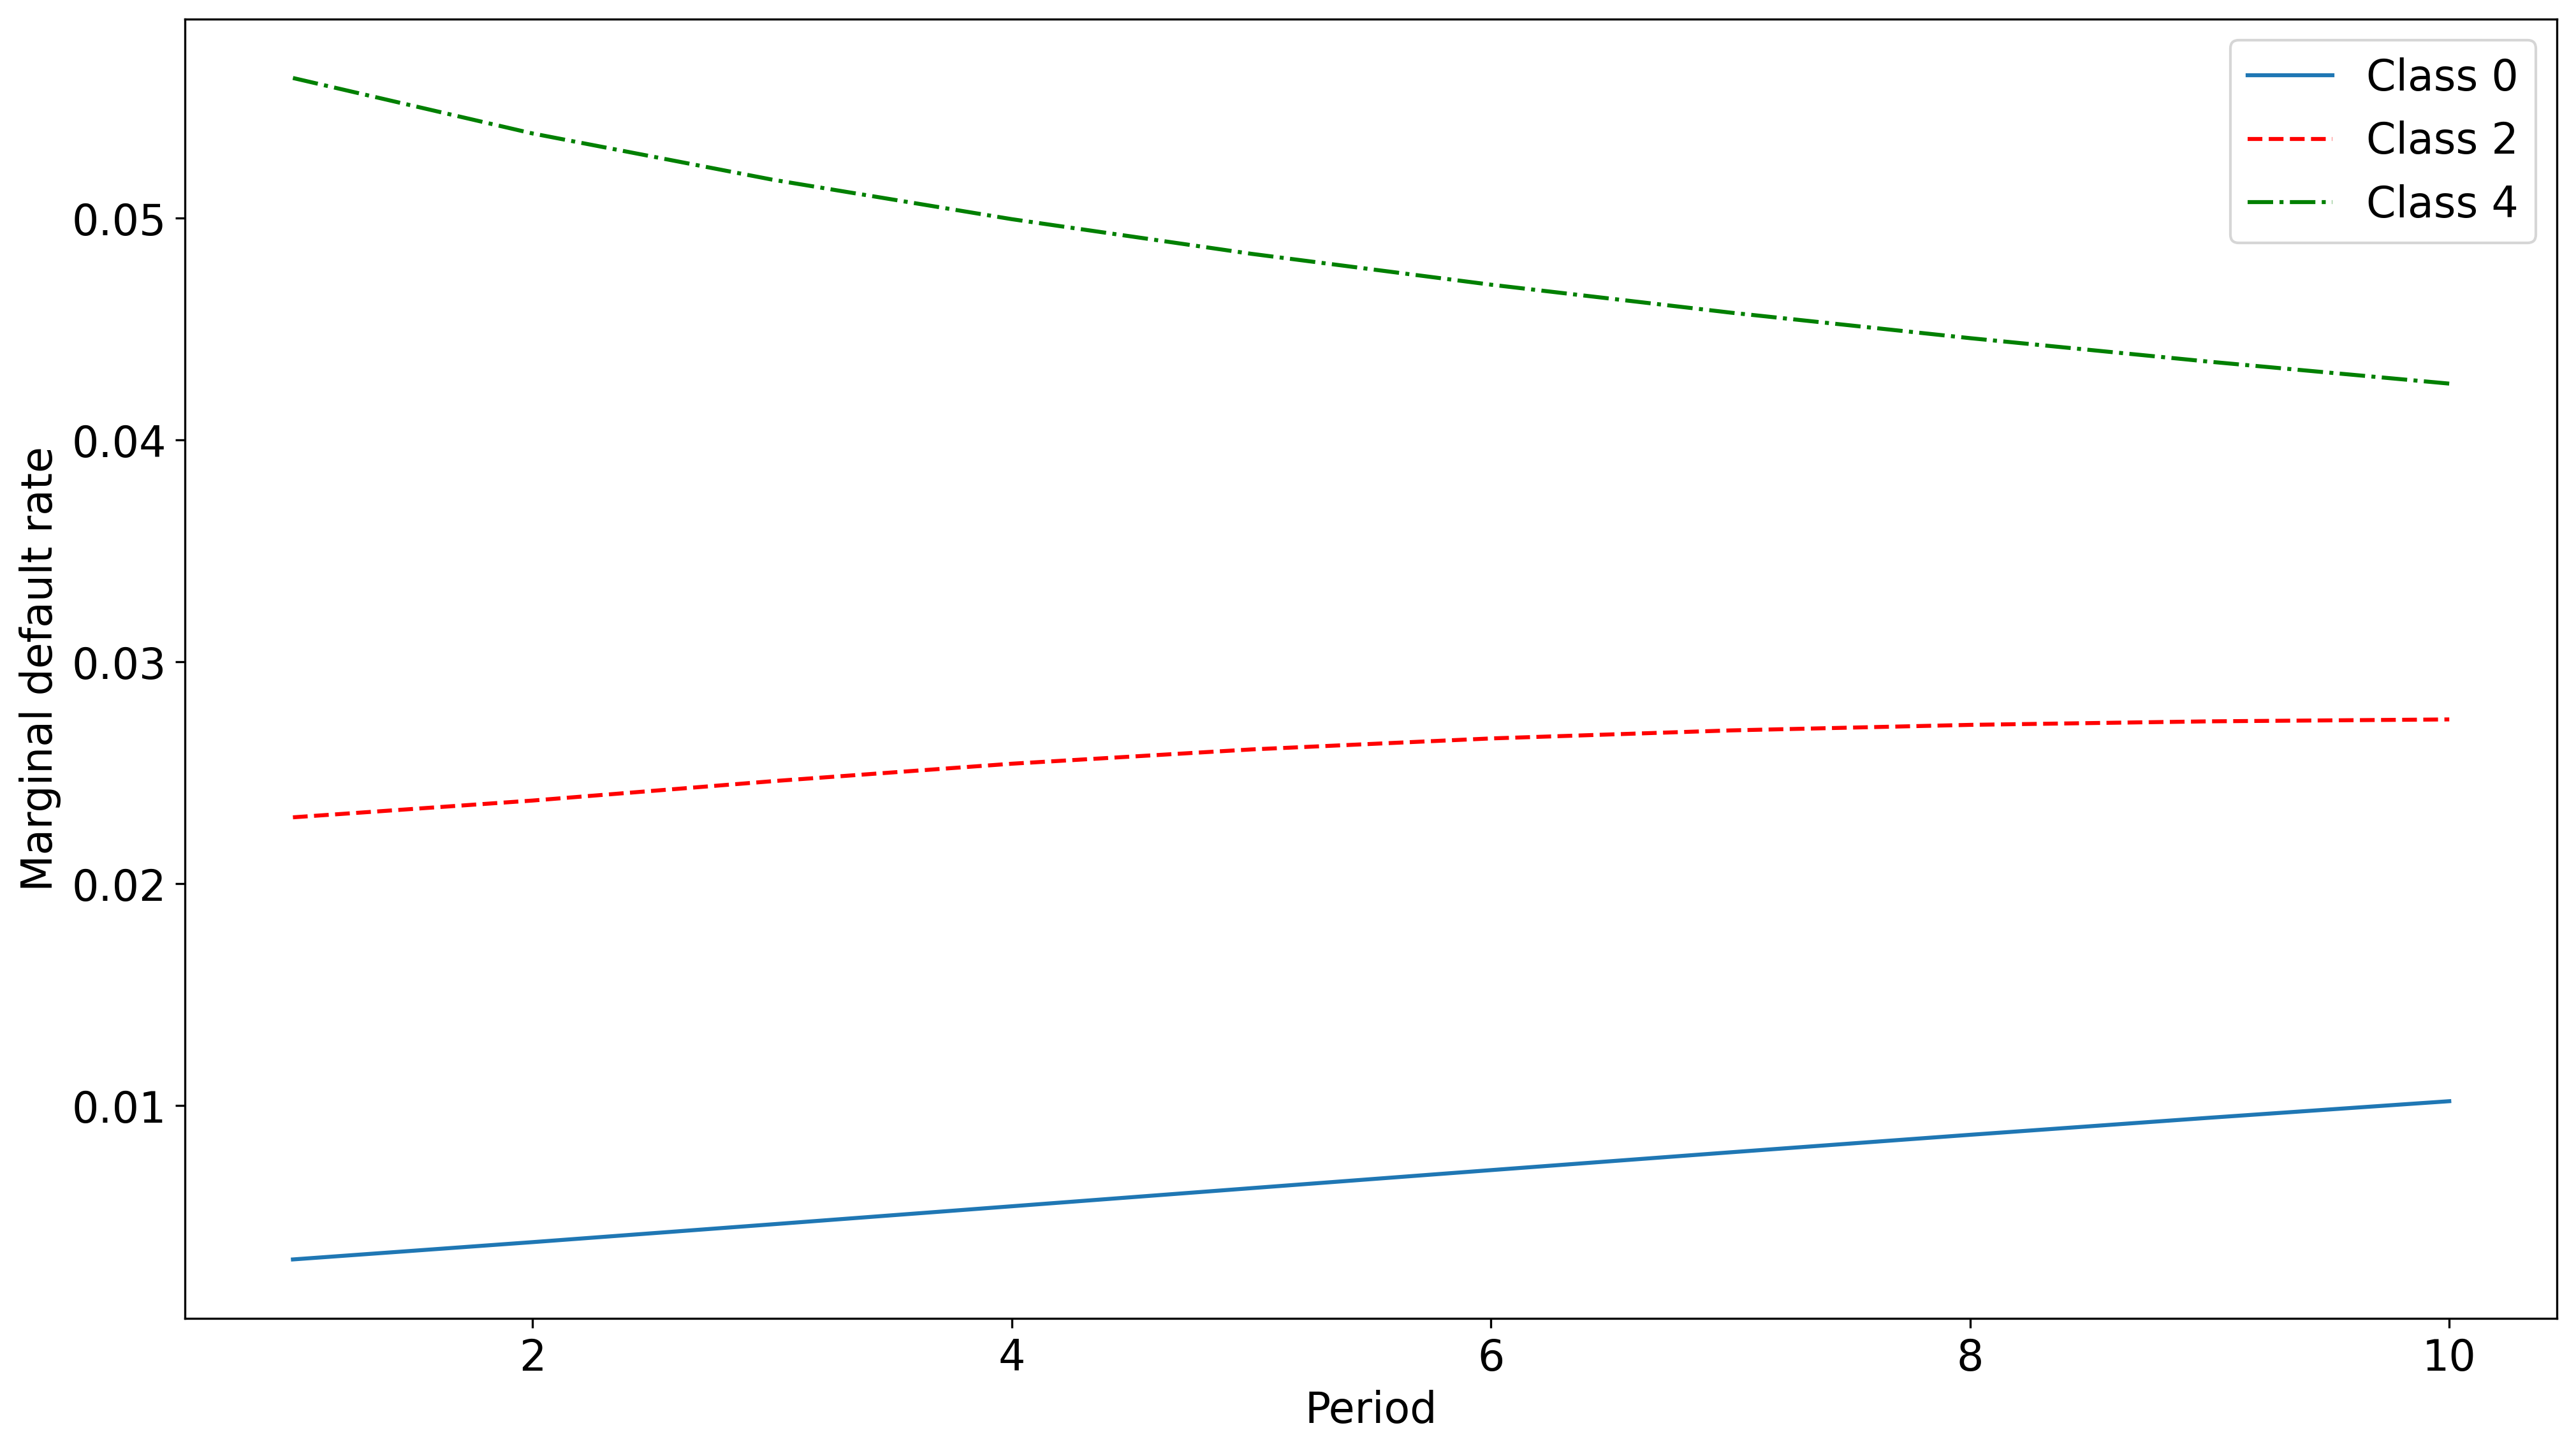

In [89]:
cumDefault2 = cumDefault2.drop('period', axis='columns')
cumDefault2_1 = cumDefault2.shift(1)
margDefault = (cumDefault2-cumDefault2_1)/(1-cumDefault2_1)

plt.plot(margDefault.index, margDefault.class_0, label='Class 0')
plt.plot(margDefault.index, margDefault.class_2, color='red', label='Class 2',linestyle='dashed')
plt.plot(margDefault.index, margDefault.class_4, color='green', label='Class 4',linestyle='dashdot')
plt.xlabel('Period')
plt.ylabel('Marginal default rate')
plt.legend(loc='best')
plt.show()

## Age Feature Models

### PDs by Age

In [90]:
model_lr1 = smf.glm('default_time~cep_time + equity_time + interest_rate_time + FICO_orig_time + gdp_time + PCA1_1 + PCA2_1 + PCA3_1 + PCA4_1 + PCA5_1 + cluster_1 + age + age2',
                     family = sm.families.Binomial(), data = data).fit()


print(model_lr1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                59001
Model:                            GLM   Df Residuals:                    58987
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6398.3
Date:                Mon, 15 Feb 2021   Deviance:                       12797.
Time:                        17:07:07   Pearson chi2:                 5.60e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.3651      0

In [91]:
data2 = data
data2.loc[:,'age_c'] = pd.Categorical(data.age, ordered=False)

model_lr2 = smf.glm('default_time~cep_time + equity_time + interest_rate_time + FICO_orig_time + gdp_time + PCA1_1 + PCA2_1 + PCA3_1 + PCA4_1 + PCA5_1 + cluster_1 + age_c',
                     family = sm.families.Binomial(), data = data2).fit()

In [92]:
PD_logit_model_1 = pd.DataFrame(model_lr1.fittedvalues,columns = ['PD_logit_model_1'] )
PD_logit_model_2 = pd.DataFrame(model_lr2.fittedvalues,columns = ['PD_logit_model_2'] )

data3 = pd.merge(data2, PD_logit_model_1, right_index=True, left_index=True)
data4 = pd.merge(data3, PD_logit_model_2, right_index=True, left_index=True)

data4_mean_age = data4.groupby('age')[['default_time', 'PD_logit_model_1', 'PD_logit_model_2']].mean()

data4_mean_age = data4_mean_age.reset_index(drop=False)

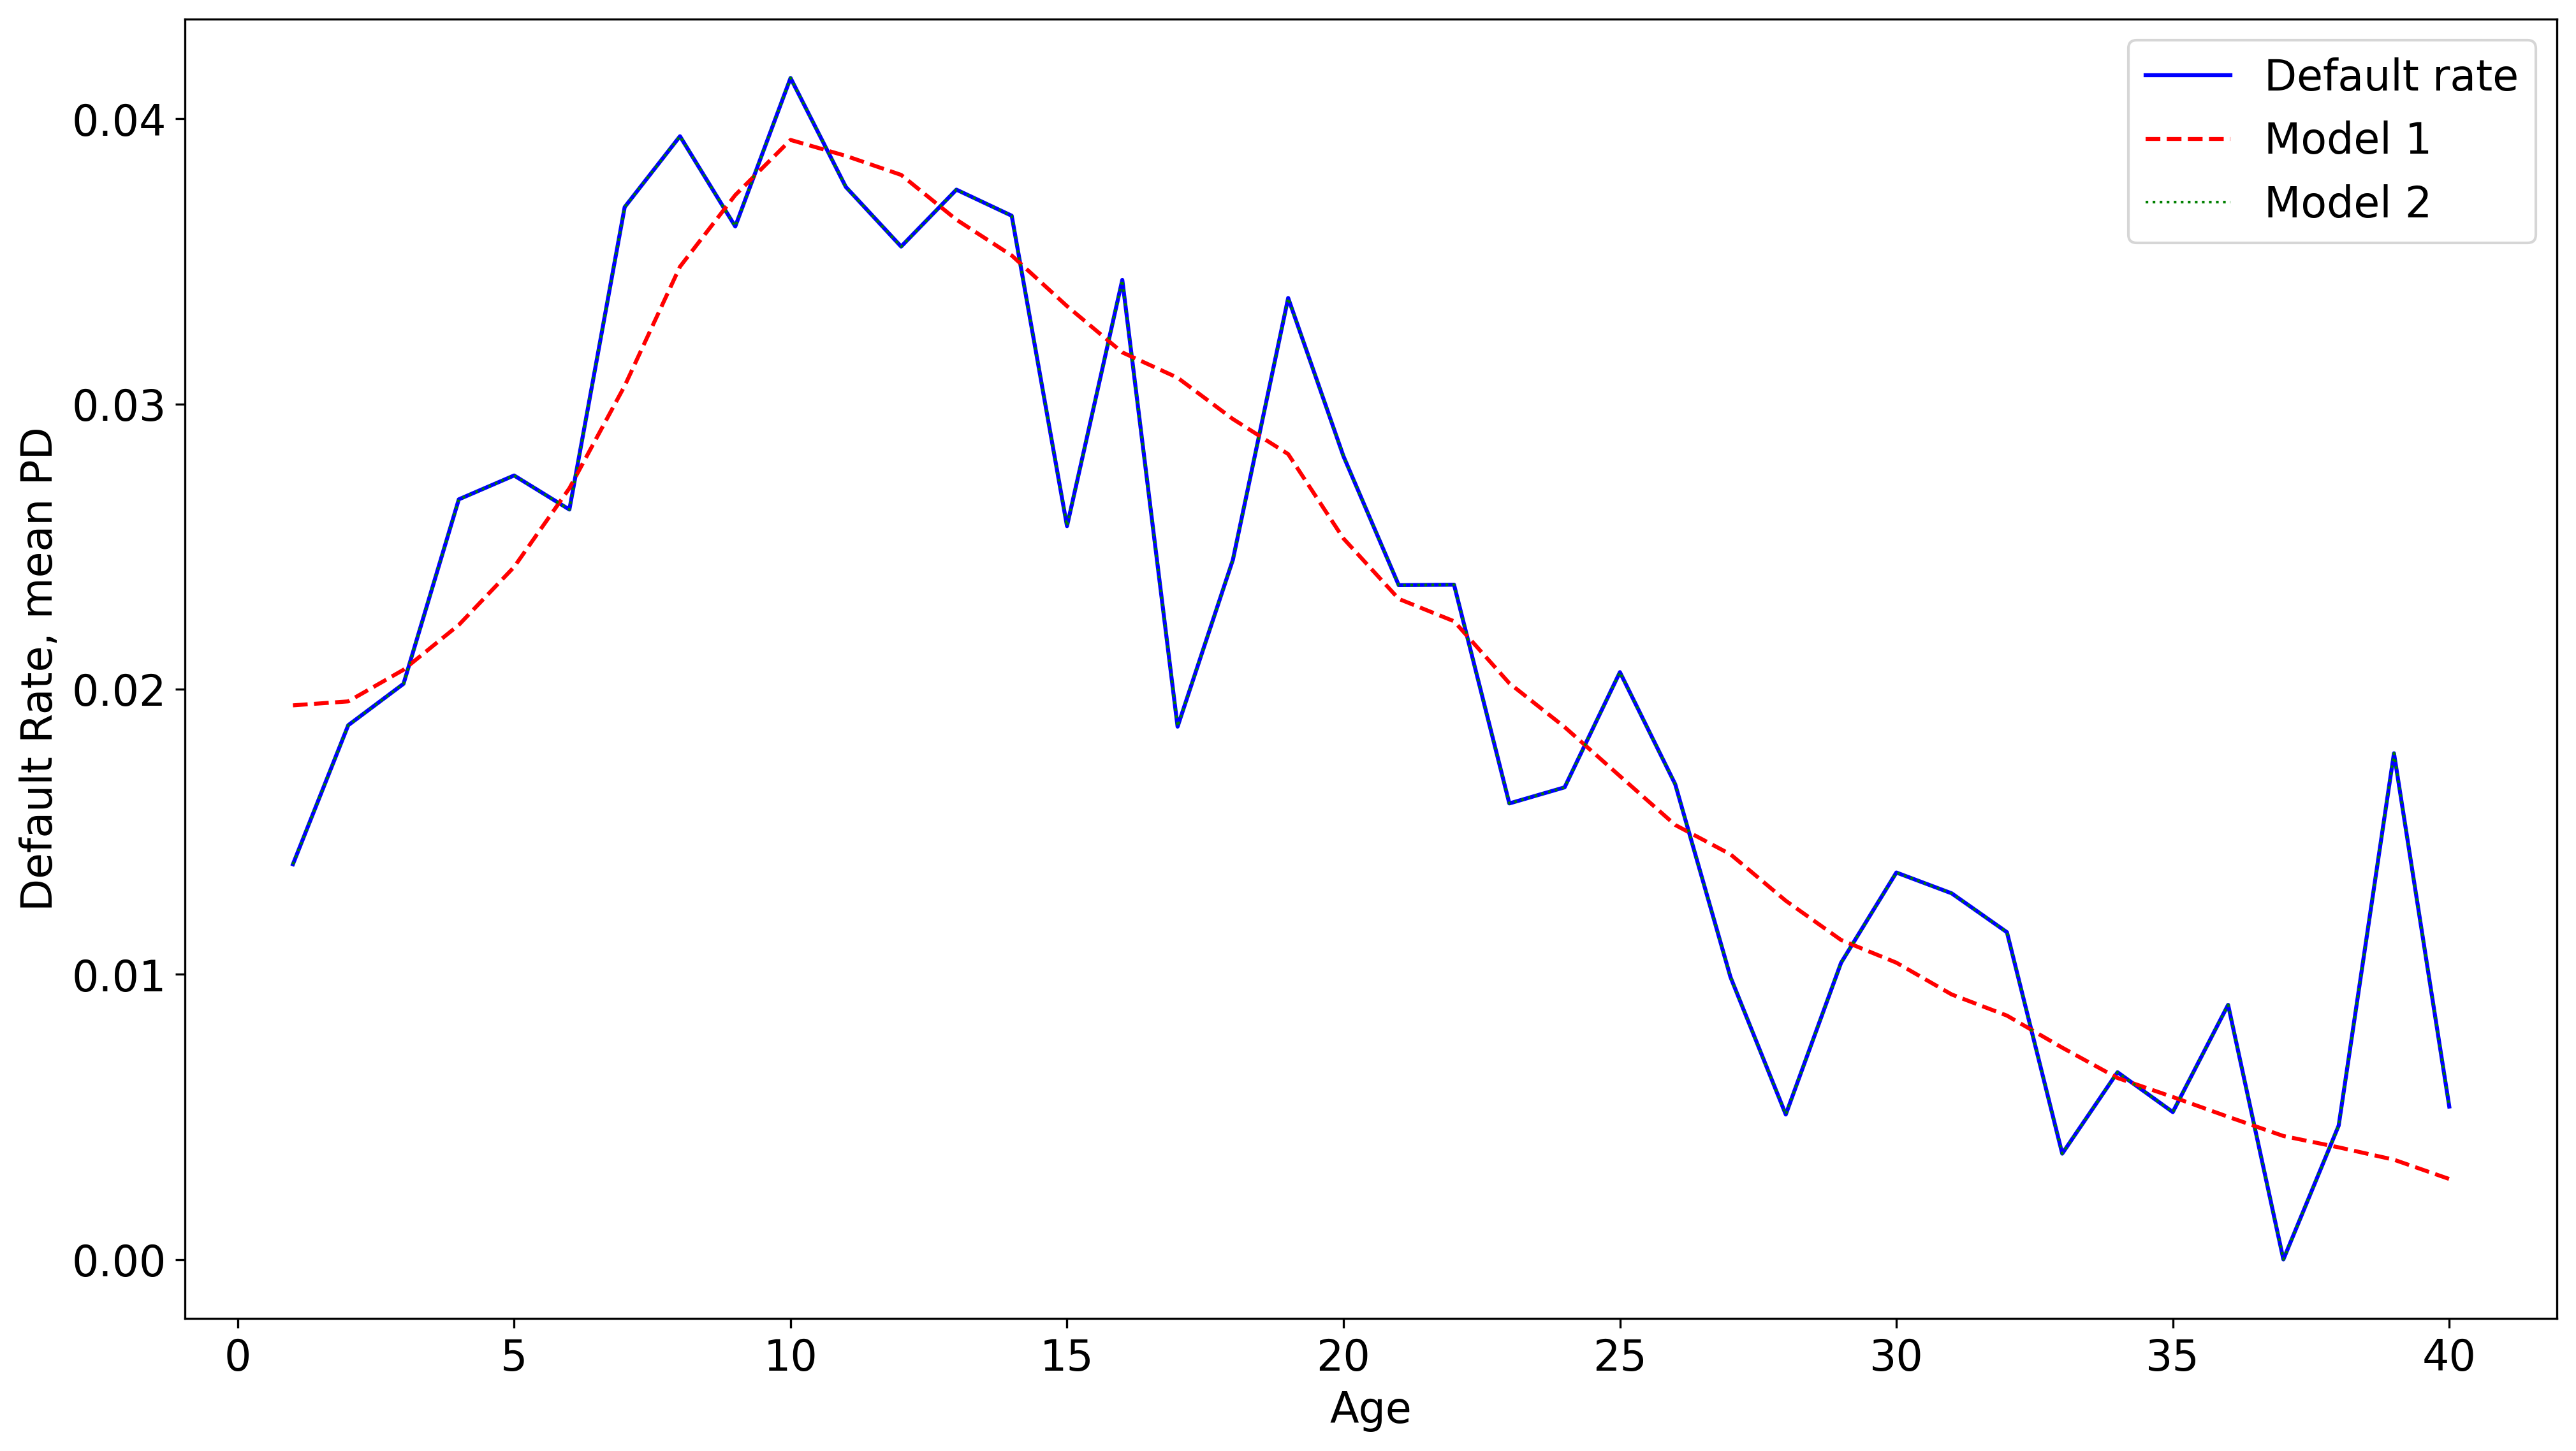

In [93]:
plt.plot('age', 'default_time', data=data4_mean_age, color='blue', label='Default rate')
plt.plot('age', 'PD_logit_model_1', data=data4_mean_age, color='red', label='Model 1',linestyle='dashed')
plt.plot('age', 'PD_logit_model_2', data=data4_mean_age, color='green', linewidth=1, label='Model 2',linestyle='dotted')
plt.xlabel('Age')
plt.ylabel('Default Rate, mean PD')
plt.legend(loc='best')
plt.show()

### Multi-Period Forecasting of PDs

 - Pretend to be in period 61, i.e., at the period following the end of our data sample
 - Forecast PDs to loan maturity
 - Maturity may be interpreted at the legal lifetime
  - Actual lifetime may be shorter if loans payoff before maturity
  - Actual lifetime may be longer if loans default before maturity and the following resolution period exceeds maturity


In [94]:
data2 = data.query('time == 60').copy()
data2.loc[:,'TTM'] = data2.loc[:,'mat_time'].subtract(data2.loc[:,'time'])
data2 = data2.reset_index(drop=True)

print(len(data2))

771


 - Reduce sample to 20 loans:
  - 15 loans with recent origination times (id `20442` to `20459`) 
  - Five older loans for comparison (id `38839` to `49709`)

In [95]:
data2 = data2.loc[data2.id.isin([20442,20444,20445,20446,20447,20450,20451,20452,20453,20454,20455,20456,20457, 20458,20459,38839,43763,43765,43766,49709])]

In [96]:
data3 = data2.loc[np.repeat(data2.index.values,data2.TTM)]
data3 = data3.reset_index(drop=True)

In [97]:
data3.loc[:,'time_tmp'] = data3.groupby(['id']).cumcount()+1

data3.loc[:,'age'] = data3.loc[:,'time']-data3.loc[:,'orig_time']+data3.loc[:,'time_tmp']
data3.loc[:,'age2'] = data3.loc[:,'age'].multiply(data3.loc[:,'age'])

data3.loc[:,'time'] = data3.loc[:,'time']+data3.loc[:,'time_tmp']

data3 = data3.rename(columns={'TTM': 'TTM_0','balance_time': 'balance_time_0'})
data3.loc[:,'TTM'] = data3.loc[:,'mat_time']-data3.loc[:,'time']

Predict the PD term structure for multiple future time periods:
 - Two recently originated loans:
  - `id == 20450` and `id == 20456`
  - Complete term structure of PDs
 - Two older loans:
  - `id == 38839` and `id == 43763`
  -  Originated some time
  - Experienced some increase in credit risk
  - Comparable level of risk despite being on the running-off end

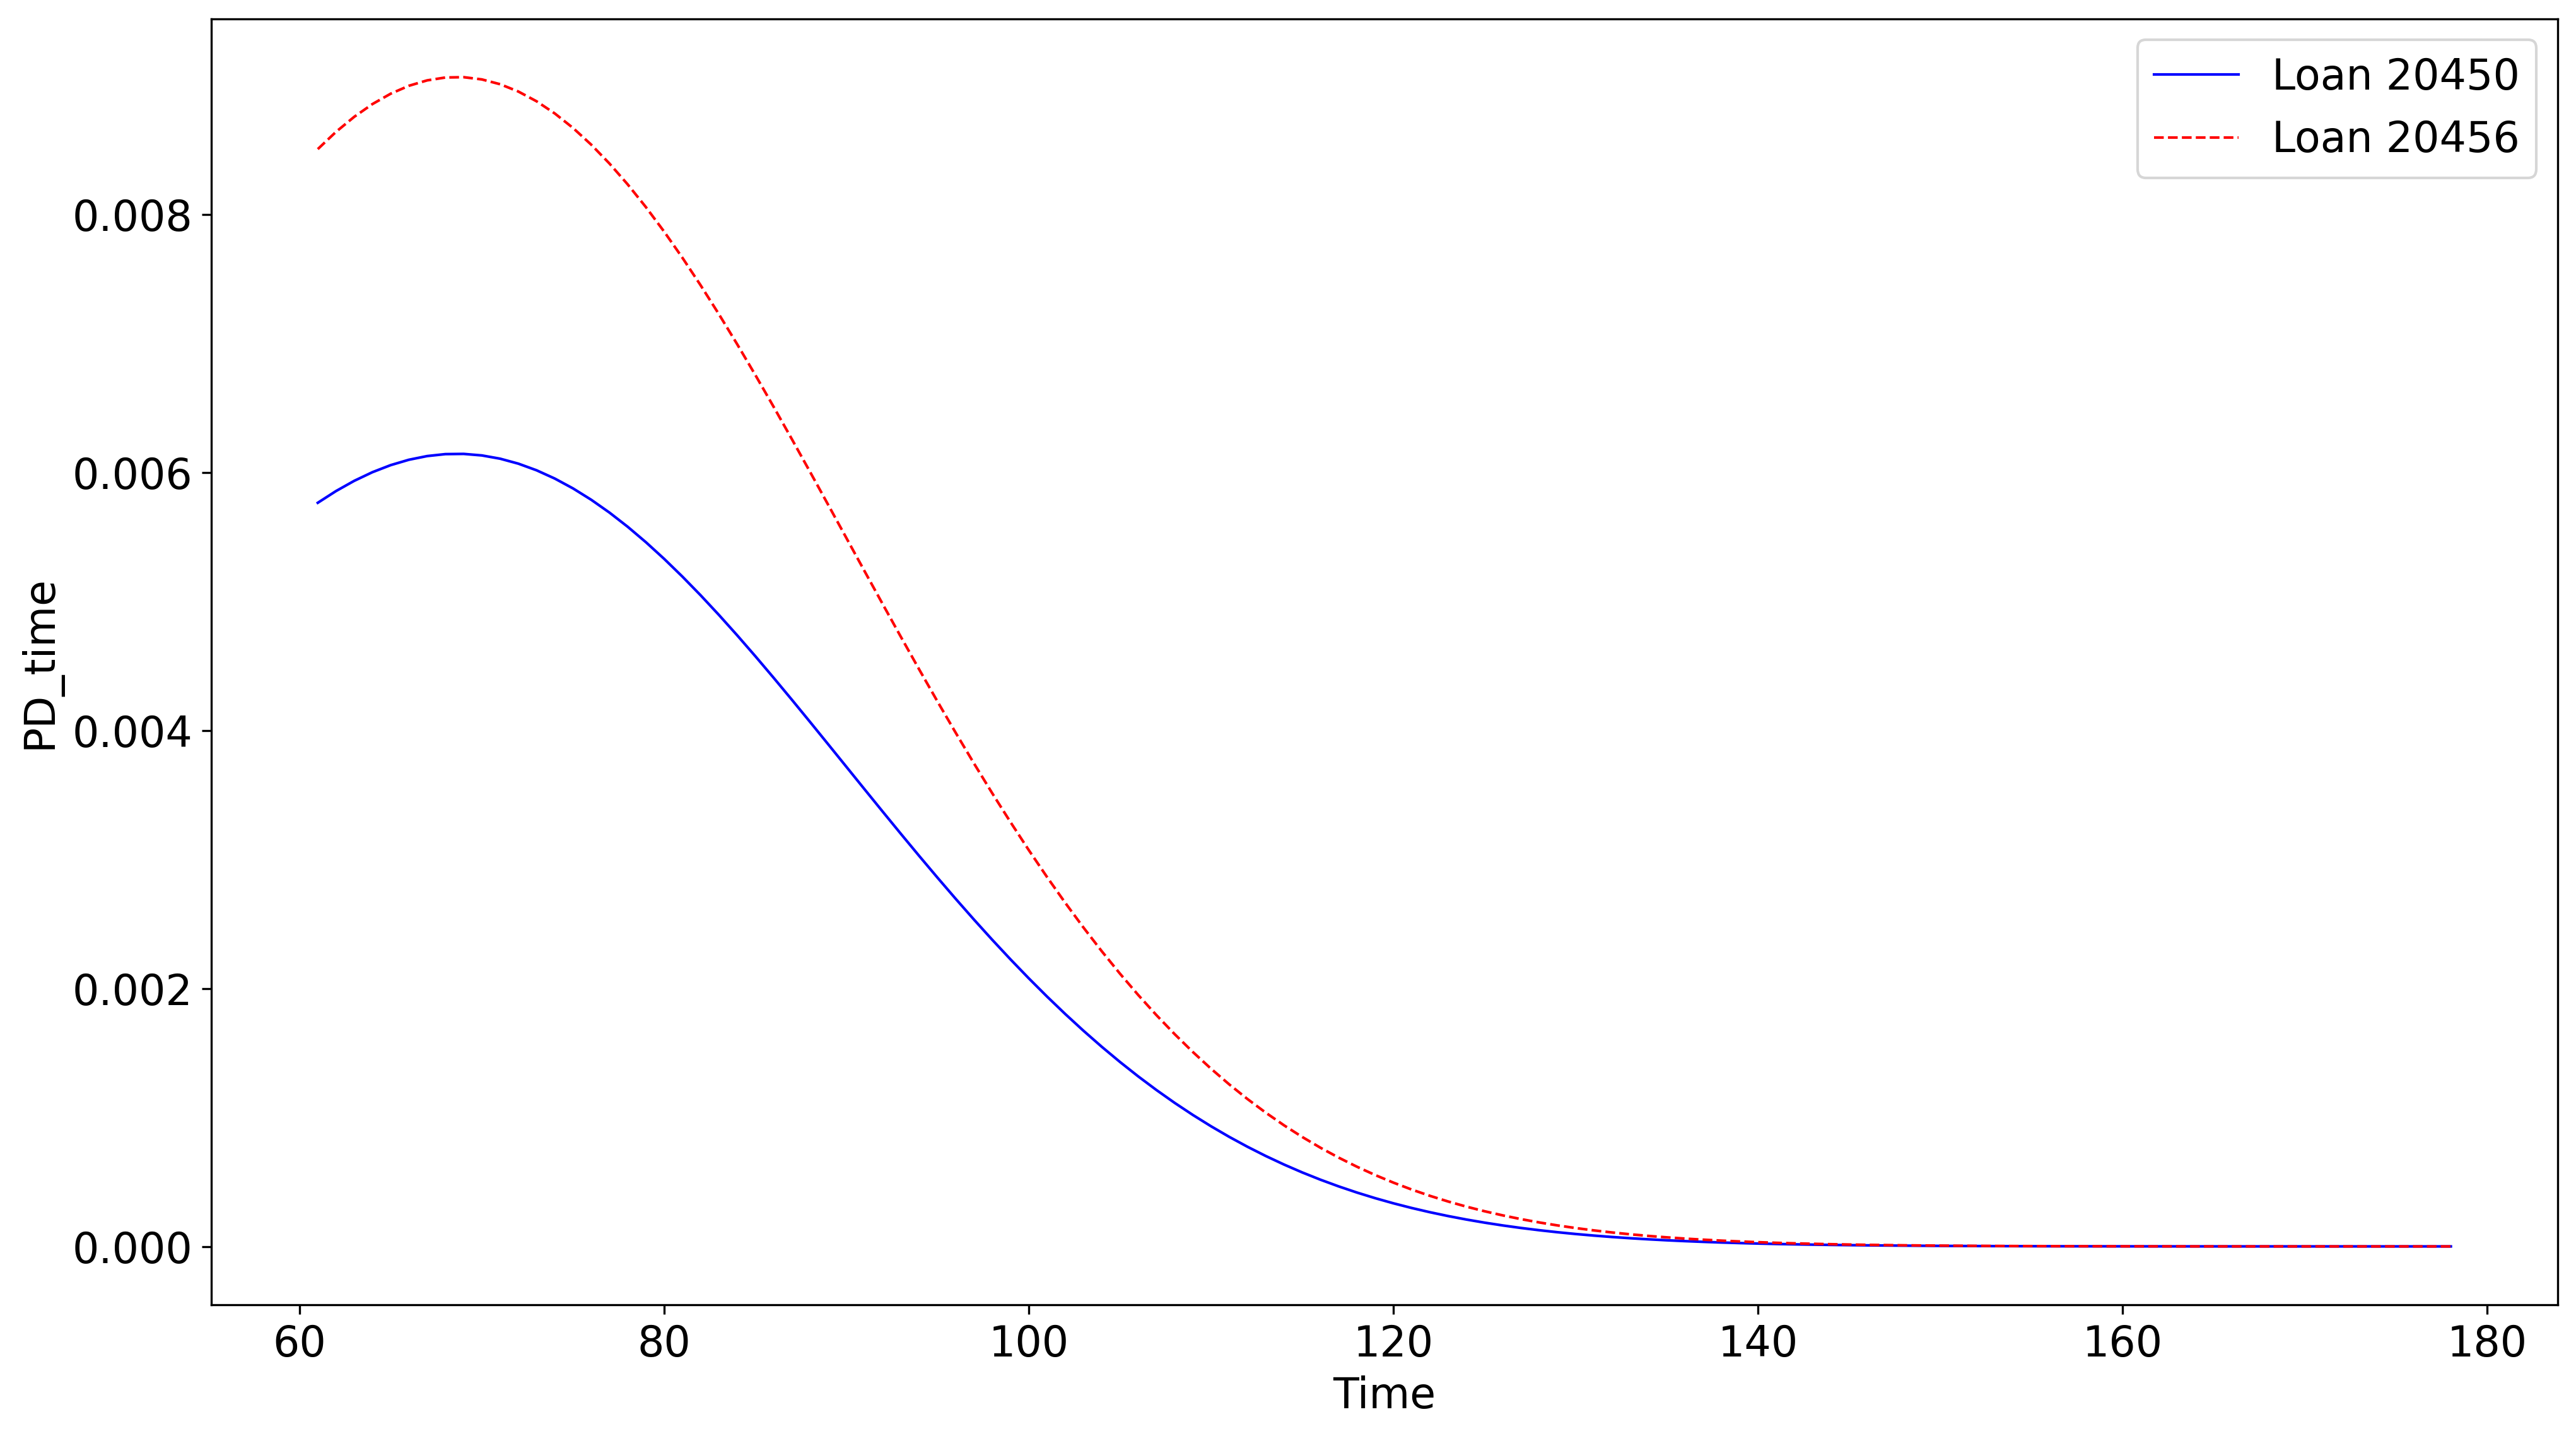

In [98]:
PD_time = pd.DataFrame(model_lr1.predict(data3), columns = ['PD_time'])
data3 = pd.concat([data3, PD_time], axis=1)

PD_time_20450 = data3.loc[data3.id == 20450, :]
PD_time_20456 = data3.loc[data3.id == 20456, :]

plt.plot('time', 'PD_time', data=PD_time_20450, marker='', color='blue', linewidth=1, label='Loan 20450')
plt.plot('time', 'PD_time', data=PD_time_20456, marker='', color='red', linewidth=1, label='Loan 20456',linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('PD_time')
plt.legend(loc='best')
plt.show()

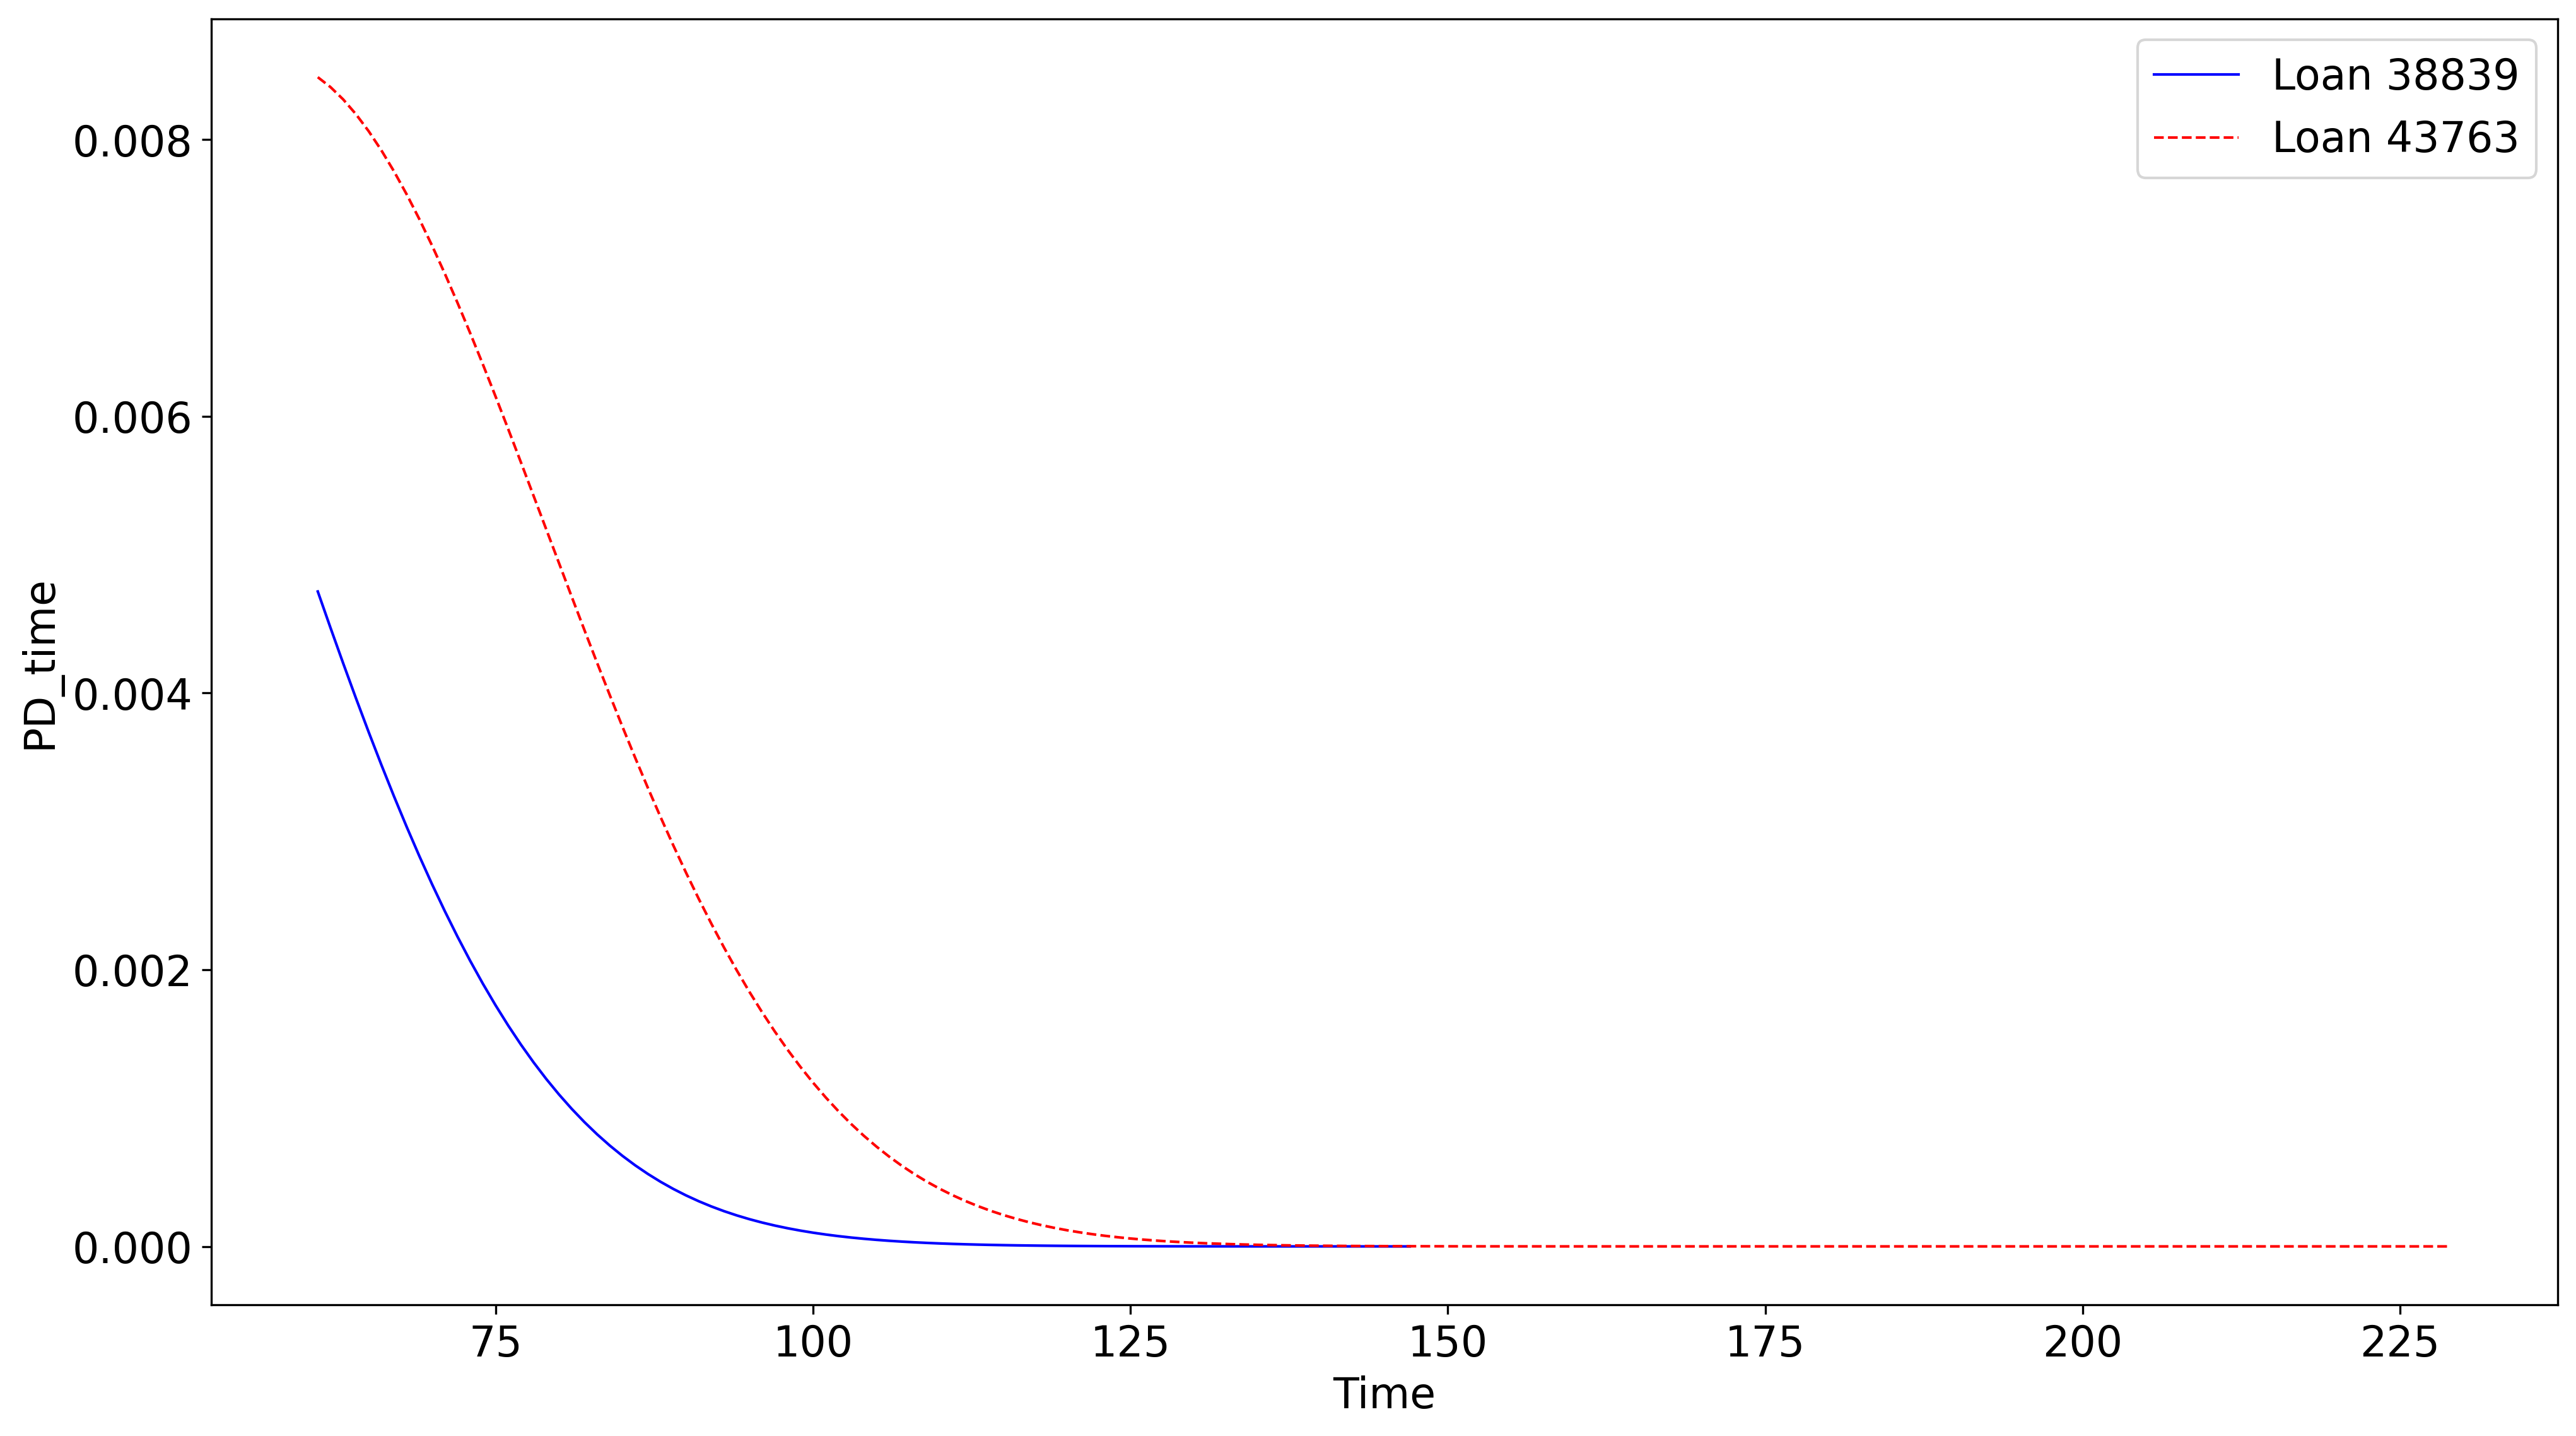

In [99]:
PD_time_38839 = data3.loc[data3.id == 38839, :]
PD_time_43763 = data3.loc[data3.id == 43763, :]

plt.plot('time', 'PD_time', data=PD_time_38839, marker='', color='blue', linewidth=1, label='Loan 38839')
plt.plot('time', 'PD_time', data=PD_time_43763, marker='', color='red', linewidth=1, label='Loan 43763',linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('PD_time')
plt.legend(loc='best')
plt.show()

## Survival Time Models

 - Survival models explain default risk over time
 - Risk measure:
  - Unconditional density $f(t)$
  - Survival probability $S(t)$
  - Conditional density, also known as the hazard rate $h(t)$


 - Probabilities of default for discrete time period can be inferred from these risk measures
 - Full calibration of models to the observed default rate is not guaranteed 
 - Example: Cox Proportional Hazard (CPH) model

### Probability Density Function, Survival Probability and Hazard Rate

Unconditional density of default at time $t$:
\begin{align*}
f(t)
\end{align*}

Proportion of borrowers that has survived: survival probability from $0$ to $t$:
\begin{align*}
S(t)=1-\int_{0}^{t}f(u)du
\end{align*}

Conditional density, so called hazard rate:
\begin{align*}
h(t)=\frac{f(t)}{S(t)}
\end{align*}


### Cross-Sectional Dataset 

In [100]:
data.loc[:,'indicator'] = 0
data.loc[:,'equity_orig_time'] = 100-data['LTV_orig_time']

data.sort_values(['id','age'], ascending=True, inplace=True)
data = data.reset_index(drop=True)
ref = np.array(np.where([data.id.duplicated(keep='last')==False])[1])
data.loc[ref, 'indicator']=1

data2 = data[(data.indicator==1)|(data.default_time == 1)].copy()
ref = np.where([data2.id.duplicated(keep='first')==False])[1]

data_cross = data2.iloc[ref].copy()

In [101]:
print(data_cross.loc[(data_cross.id==9)|(data_cross.id==47)|(data_cross.id==4),['id', 'time', 'first_time', 'age', 'default_time', 'payoff_time', 'FICO_orig_time']])

      id  time  first_time   age  default_time  payoff_time  FICO_orig_time
34   4.0  60.0        25.0  36.0           0.0          0.0           587.0
47   9.0  37.0        25.0  13.0           1.0          0.0           501.0
65  47.0  27.0        25.0   3.0           0.0          1.0           600.0


### Cox Proportional Hazard Model

Two components: 
 - Baseline component $h_0(t)$, which is the same for all borrowers 
 - Borrower specific component based on information $\exp(\beta'x_{i})$
 
\begin{align*}
h (t|x_{i})= h_0(t) \exp(\beta'x_{i})
\end{align*}



Survival function of a CPH model:
\begin{align*}
S(t|x_i) &= \exp \left(-\int\limits_0^t h_0(u) \exp(\beta'x_i)du\right)
\end{align*}

Probability density function of the survival time $T$:
\begin{align*}
f(t|x_i)= h(t|x_i) \, S(t|x)= h_0(t) \exp(\beta'x_i) \, S_0(t)^{\exp(\beta'x_i)}
\end{align*}


$\beta$ parameters are estimated by maximizing the partial likelihood function

Model is implemented for class `CoxPHFitter()` of package `lifelines`:
\begin{align*}
h (t|x_{i})= h_0(t) \exp(\beta'(x_{i}-\bar{x_{i}}))
\end{align*}
This mean-detrending results in slightly different parameter estimates


In [103]:
model_cph = CoxPHFitter()
model_cph.fit(data_cross[{'FICO_orig_time', 'equity_orig_time', 'age','default_time'}].dropna(), 'age', event_col='default_time')

print(model_cph.summary)

                      coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                         
FICO_orig_time   -0.004349   0.995660  0.000362       -0.005058   
equity_orig_time -0.020588   0.979622  0.002619       -0.025722   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                    
FICO_orig_time         -0.003641             0.994955             0.996366   
equity_orig_time       -0.015455             0.974606             0.984664   

                          z             p    -log2(p)  
covariate                                              
FICO_orig_time   -12.029337  2.491535e-33  108.306592  
equity_orig_time  -7.860477  3.826732e-15   47.892808  


In [104]:
hazard = model_cph.baseline_hazard_.reset_index(drop=False).rename({'index':'age', 'baseline hazard':'baseline'}, axis='columns')

borrower_data = pd.DataFrame({'FICO_orig_time':[400], 'equity_orig_time' :[20]})

partial = model_cph.predict_partial_hazard(borrower_data).values
hazard['borrower'] = hazard.baseline*partial

hazard['logbaseline'] = np.log(hazard.baseline)
hazard['logborrower'] = np.log(hazard.borrower)

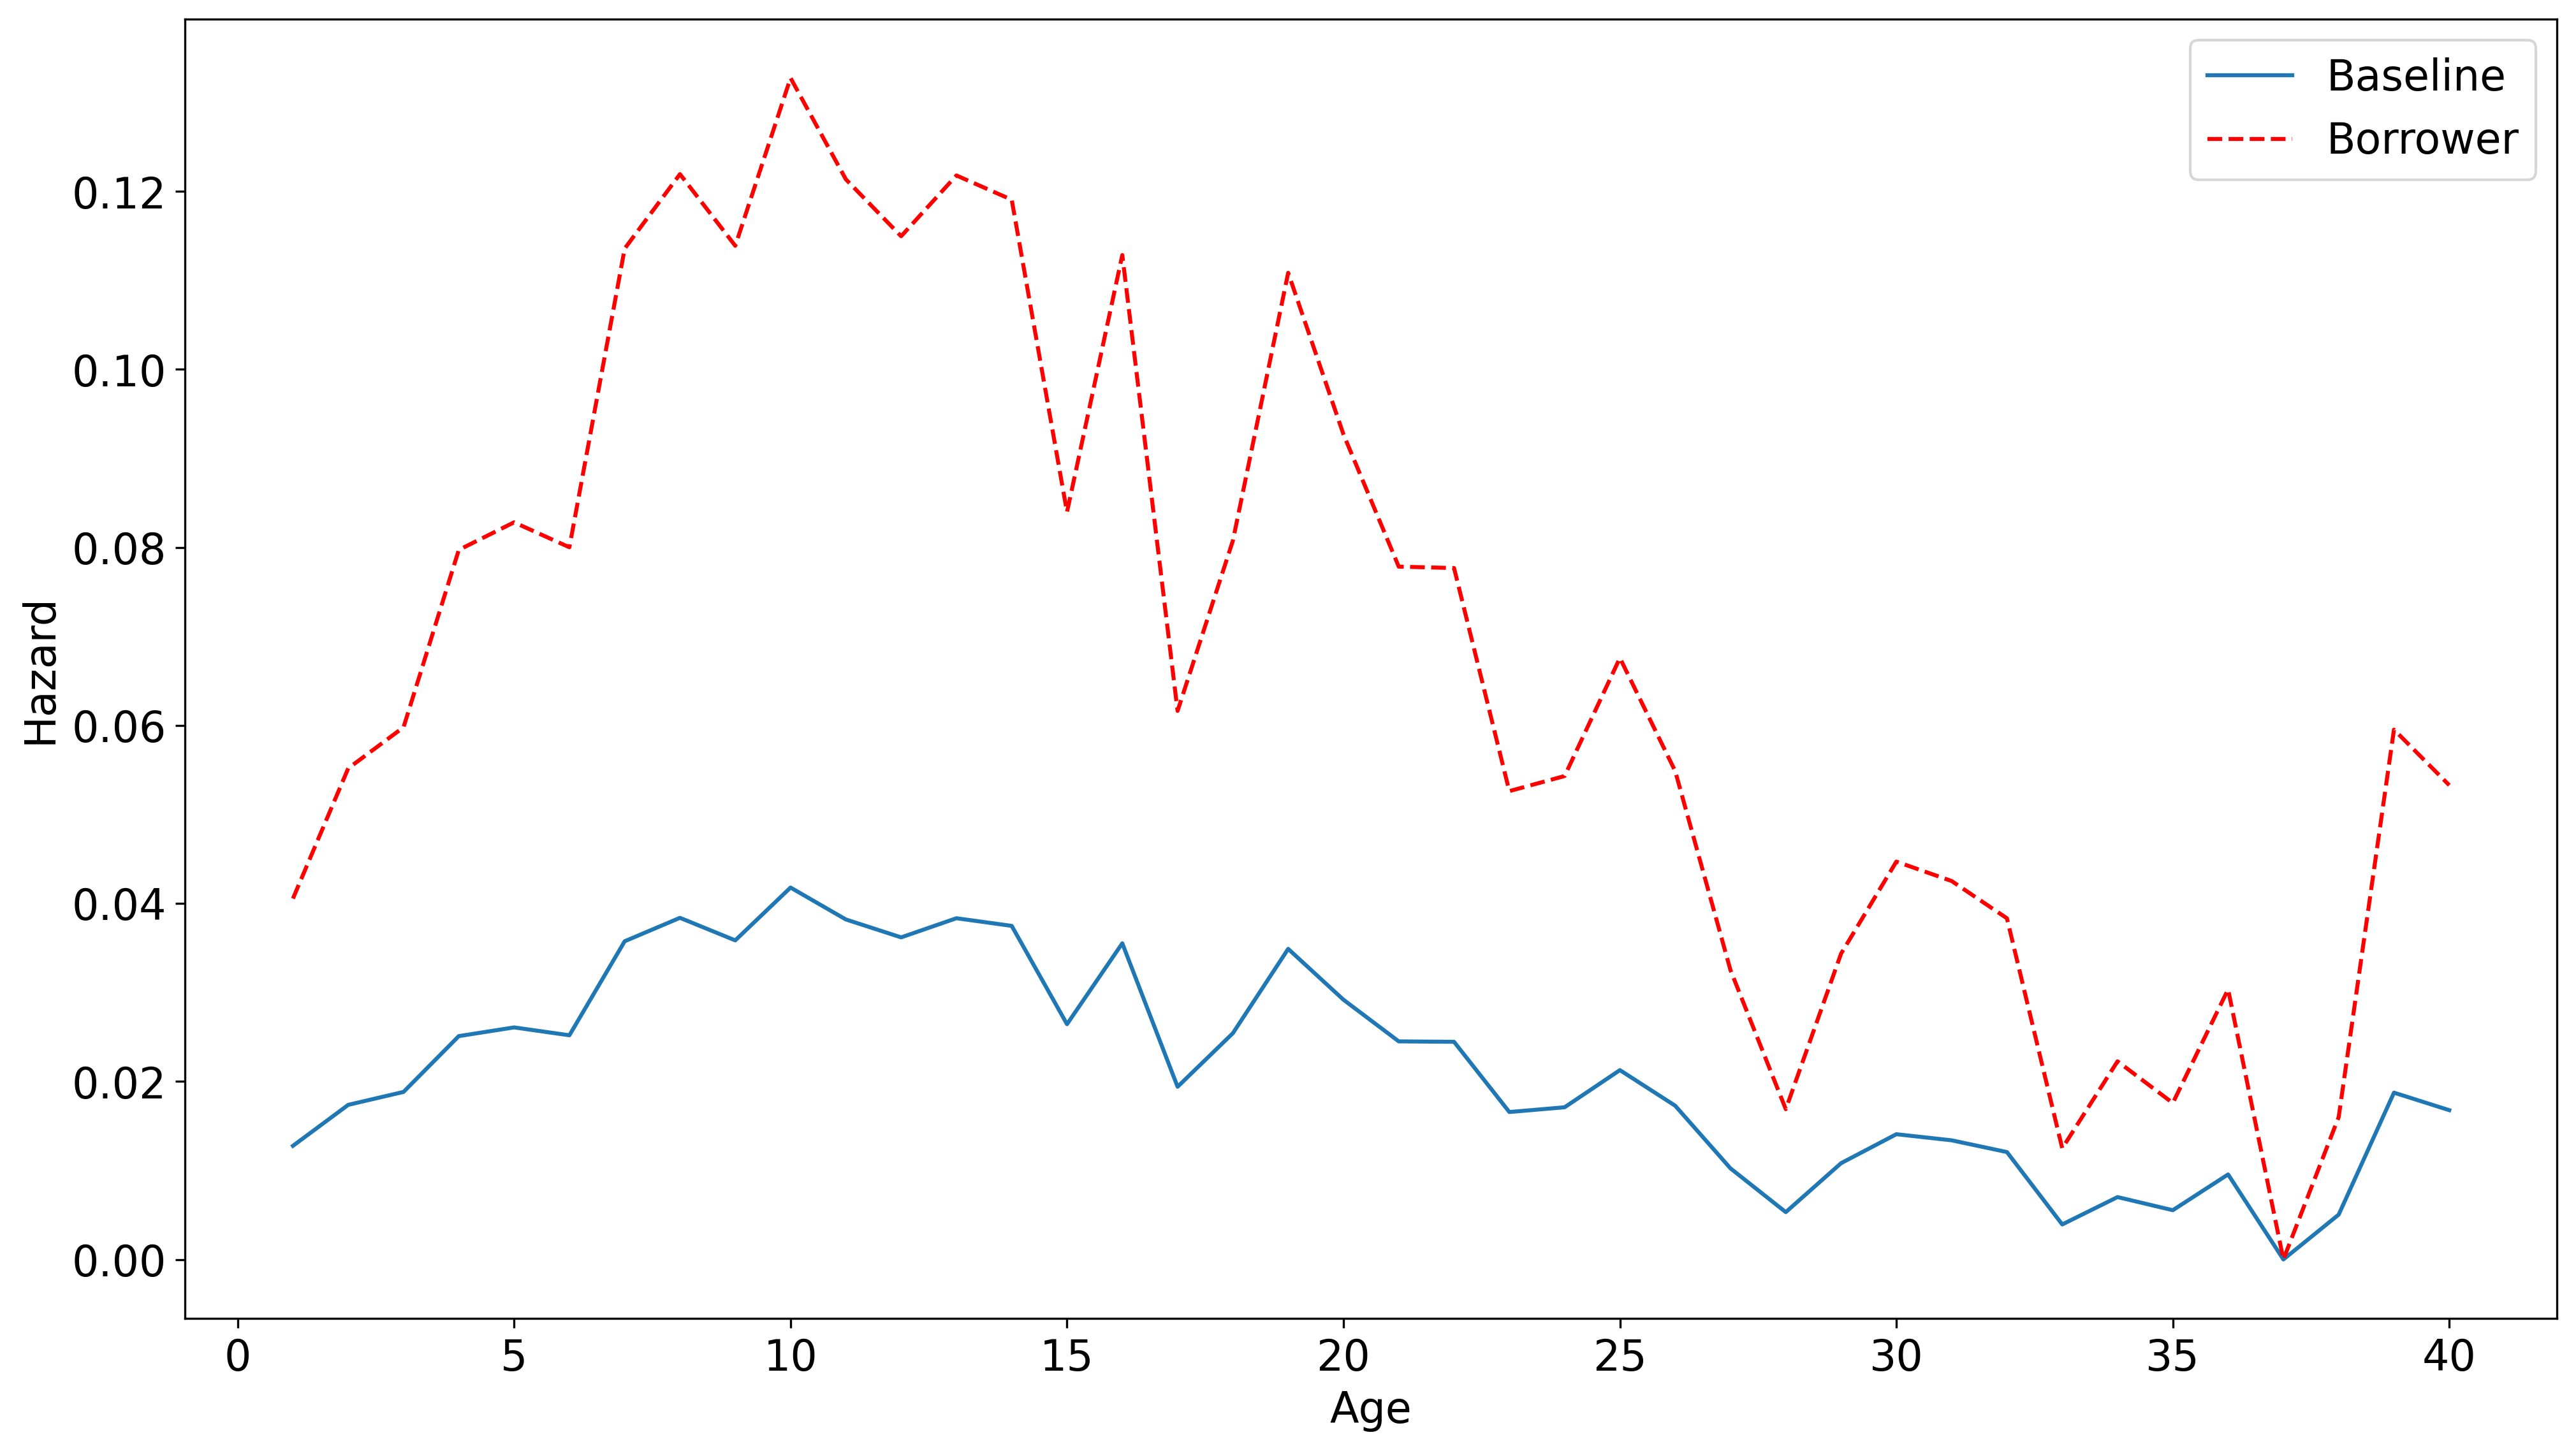

In [105]:
plt.plot('age','baseline', data=hazard, label='Baseline')
plt.plot('age','borrower', data=hazard, color='red', label='Borrower', linestyle='dashed')
plt.xlabel('Age')
plt.ylabel('Hazard')
plt.legend(loc='best')
plt.show()

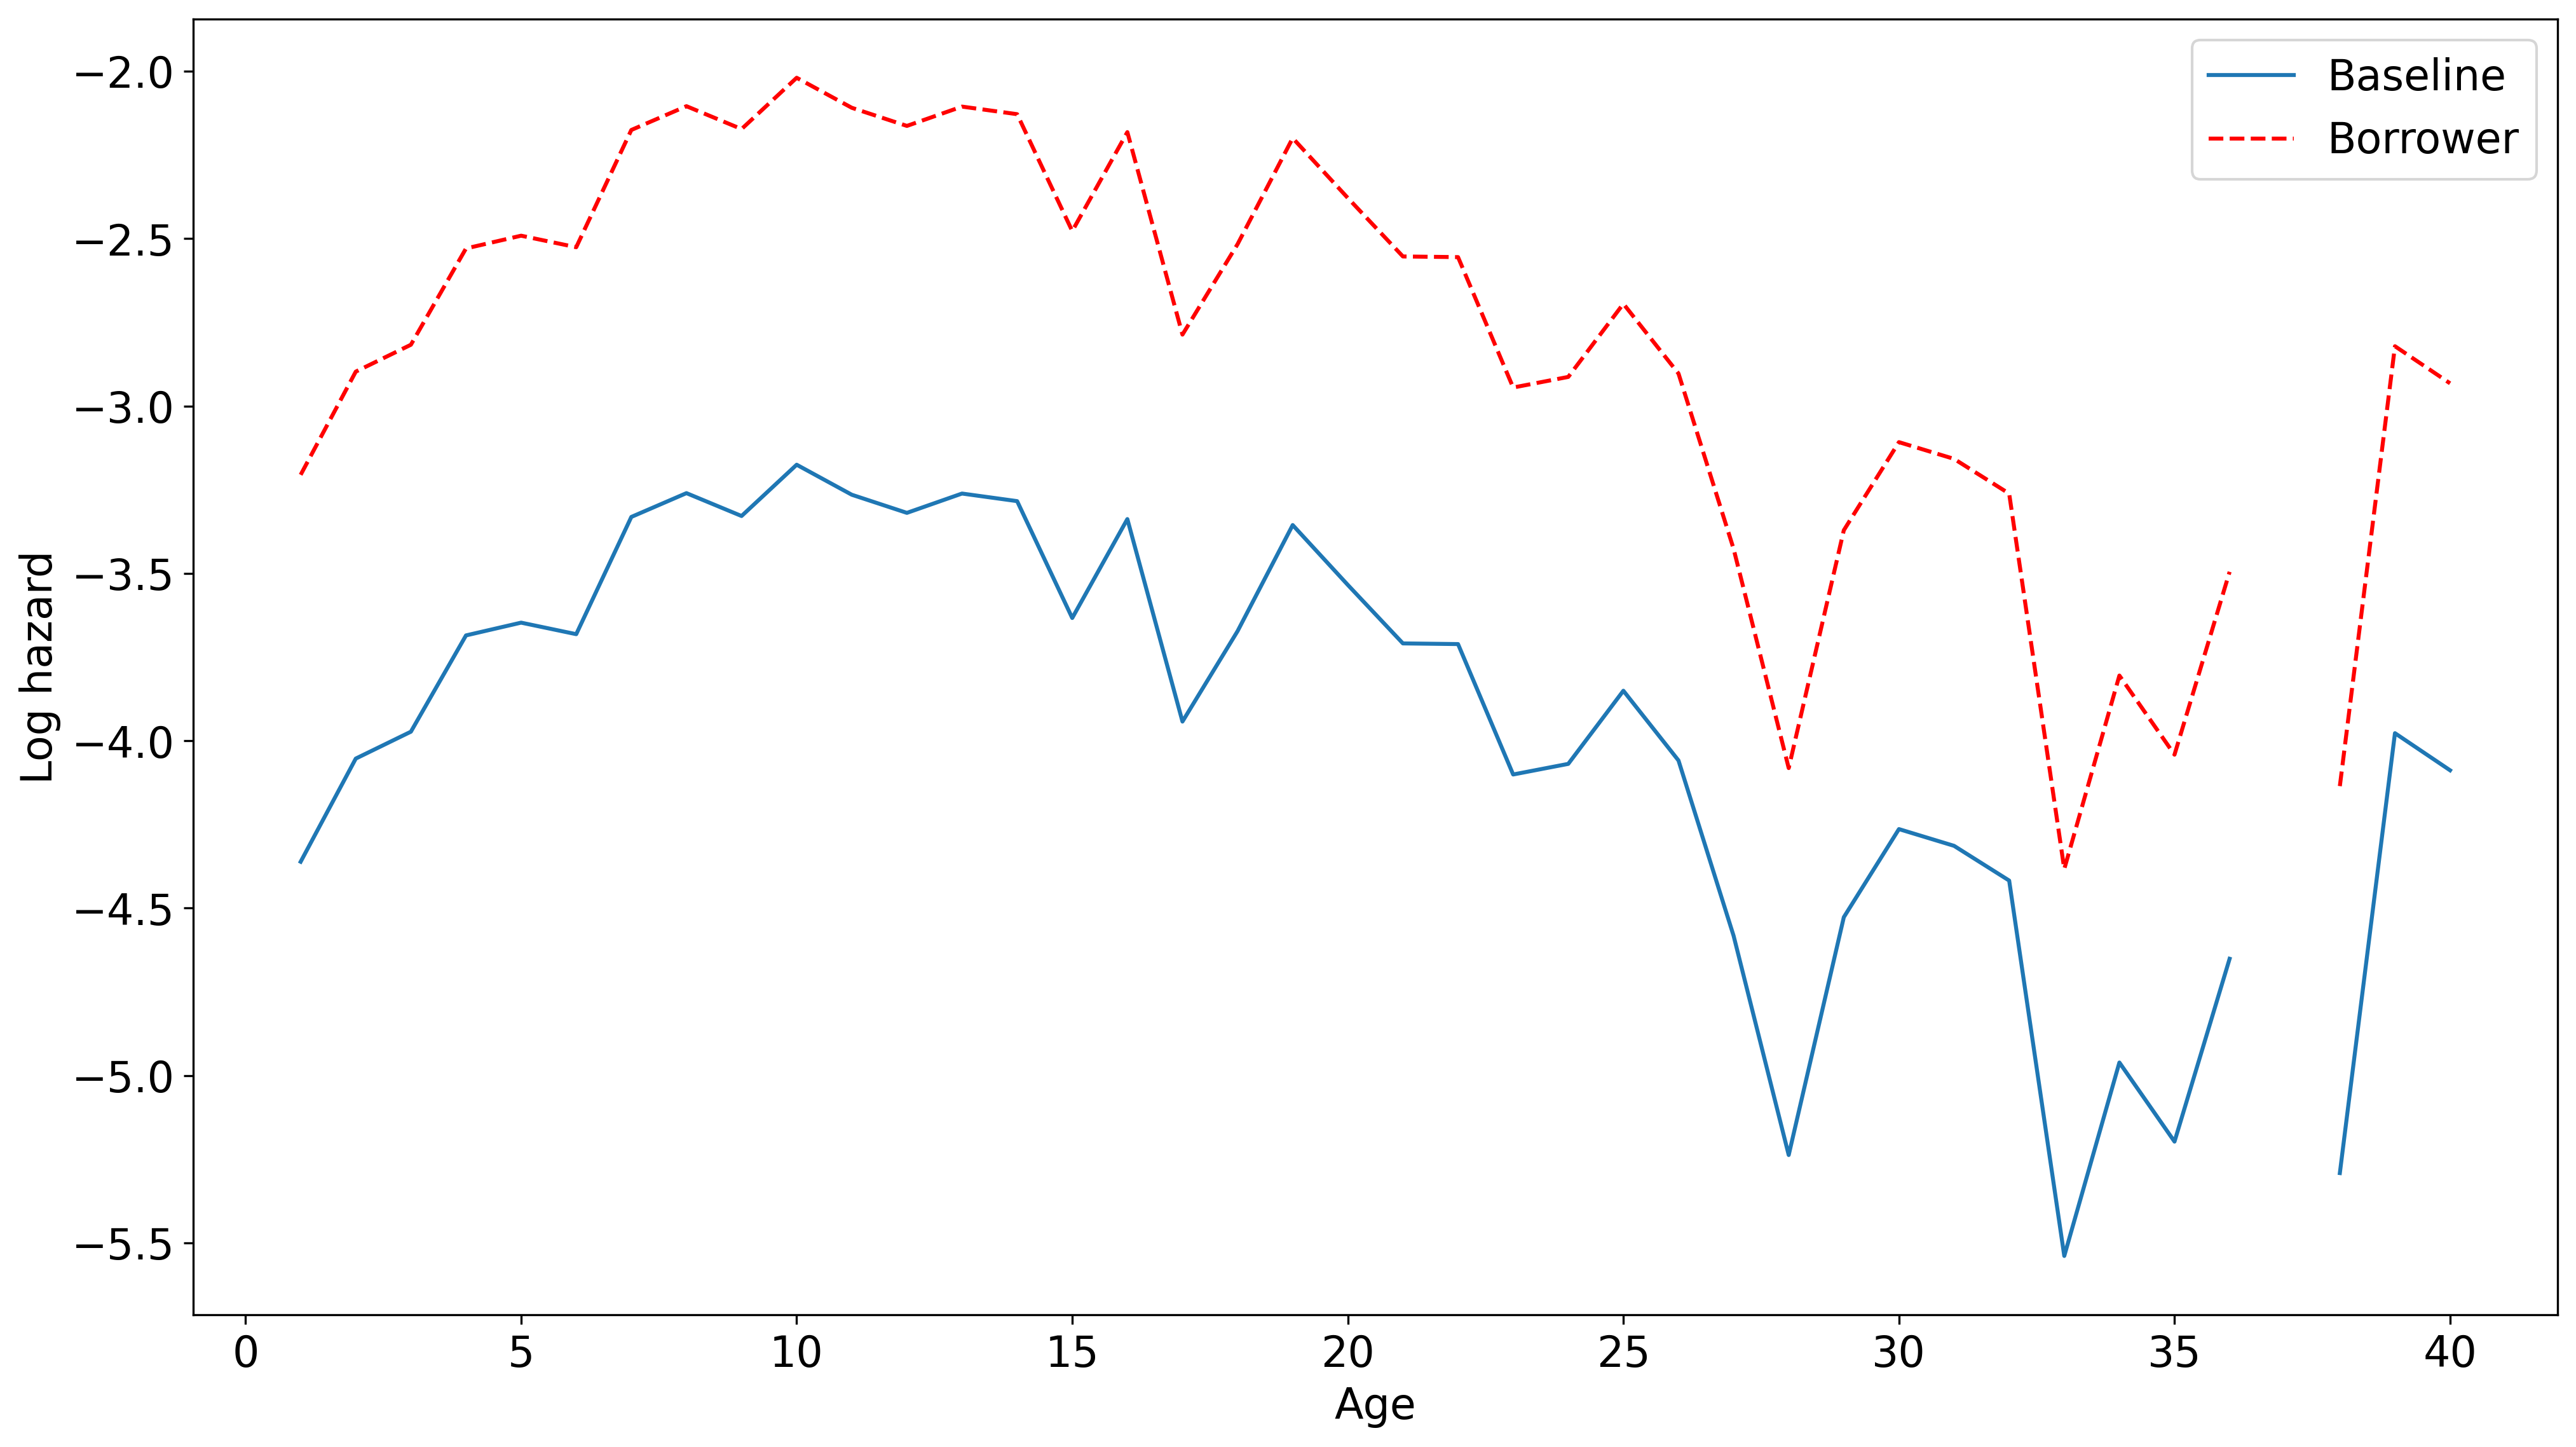

In [106]:
plt.plot('age', 'logbaseline', data=hazard, label='Baseline')
plt.plot('age', 'logborrower', data=hazard, color='red', linestyle='dashed', label='Borrower')
plt.xlabel('Age')
plt.ylabel('Log hazard')
plt.legend(loc='best')
plt.show()

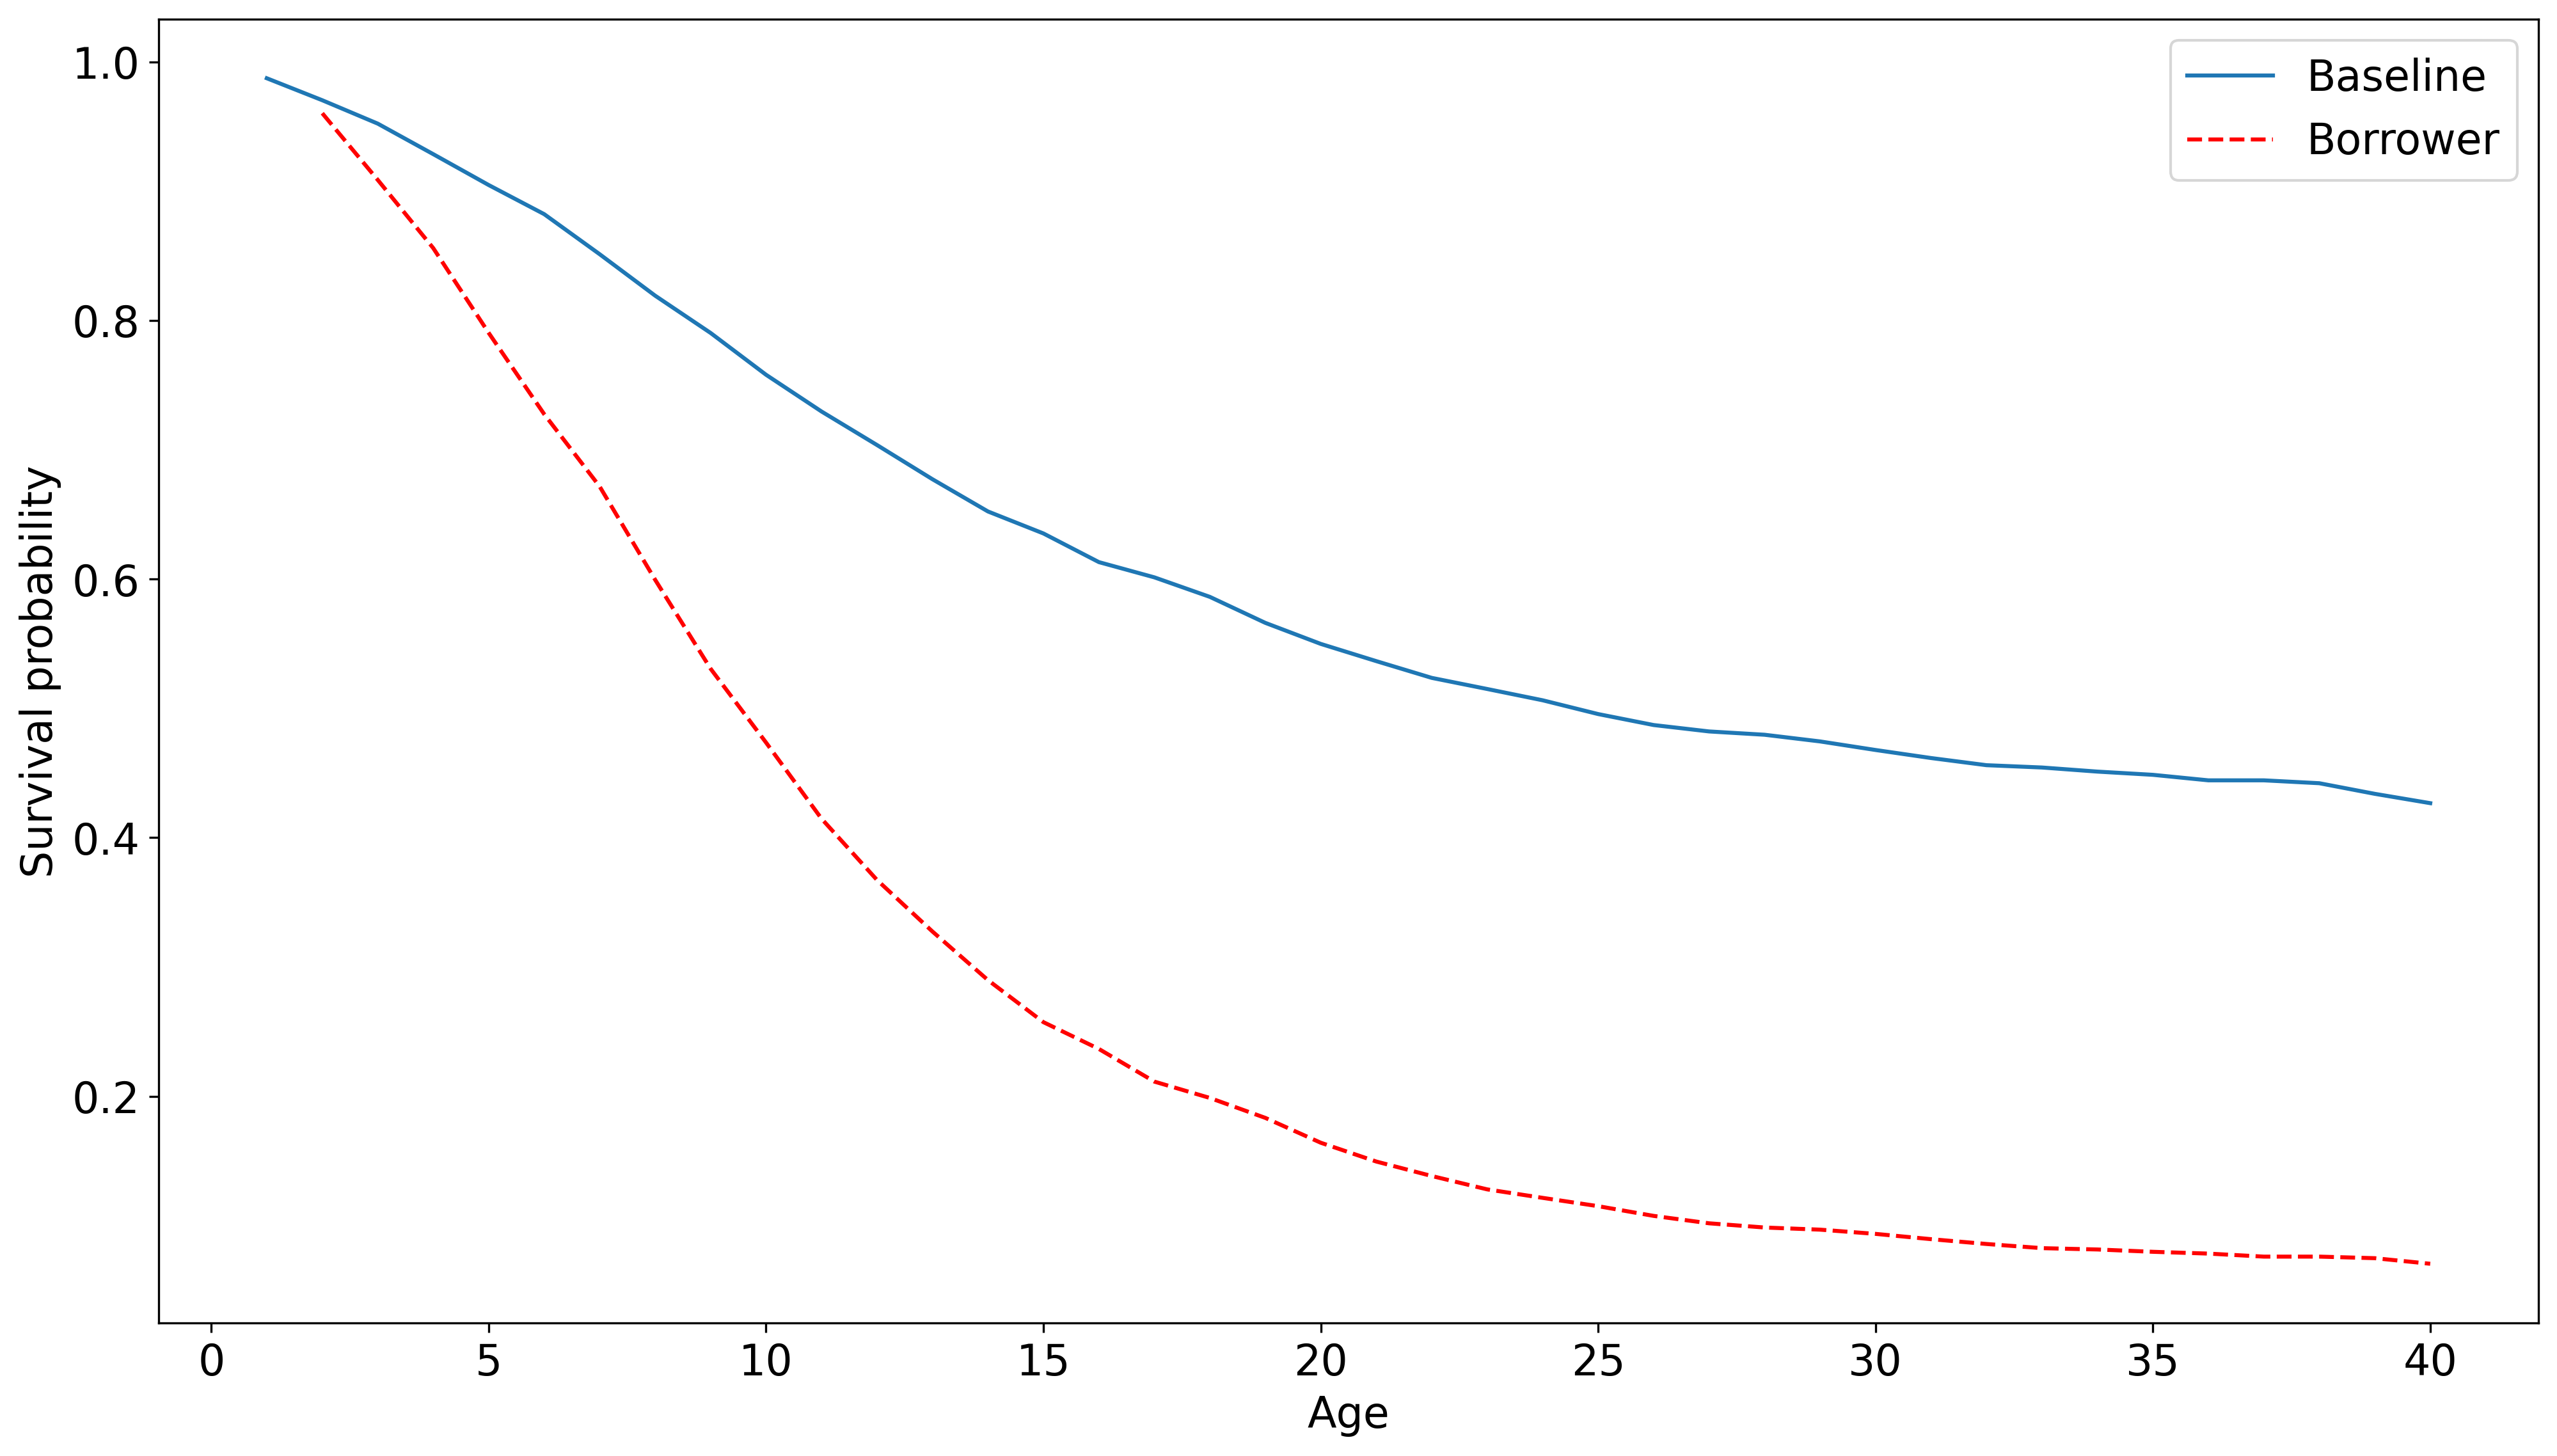

In [107]:
survival=model_cph.baseline_survival_.reset_index(drop=False).rename({'index':'age', 'baseline survival': 'baseline'}, axis='columns')

survival['borrower'] = model_cph.predict_survival_function(borrower_data)

plt.plot('age', 'baseline', data=survival, label='Baseline')
plt.plot('age', 'borrower', data=survival, color='red', label='Borrower', linestyle='dashed')
plt.xlabel('Age')
plt.ylabel('Survival probability')
plt.legend(loc='best')
plt.show()

### Calculation of PDs

\begin{align*}
\frac{S_i(t1)-S_i(t2)}{S_i(t1)}
\end{align*}

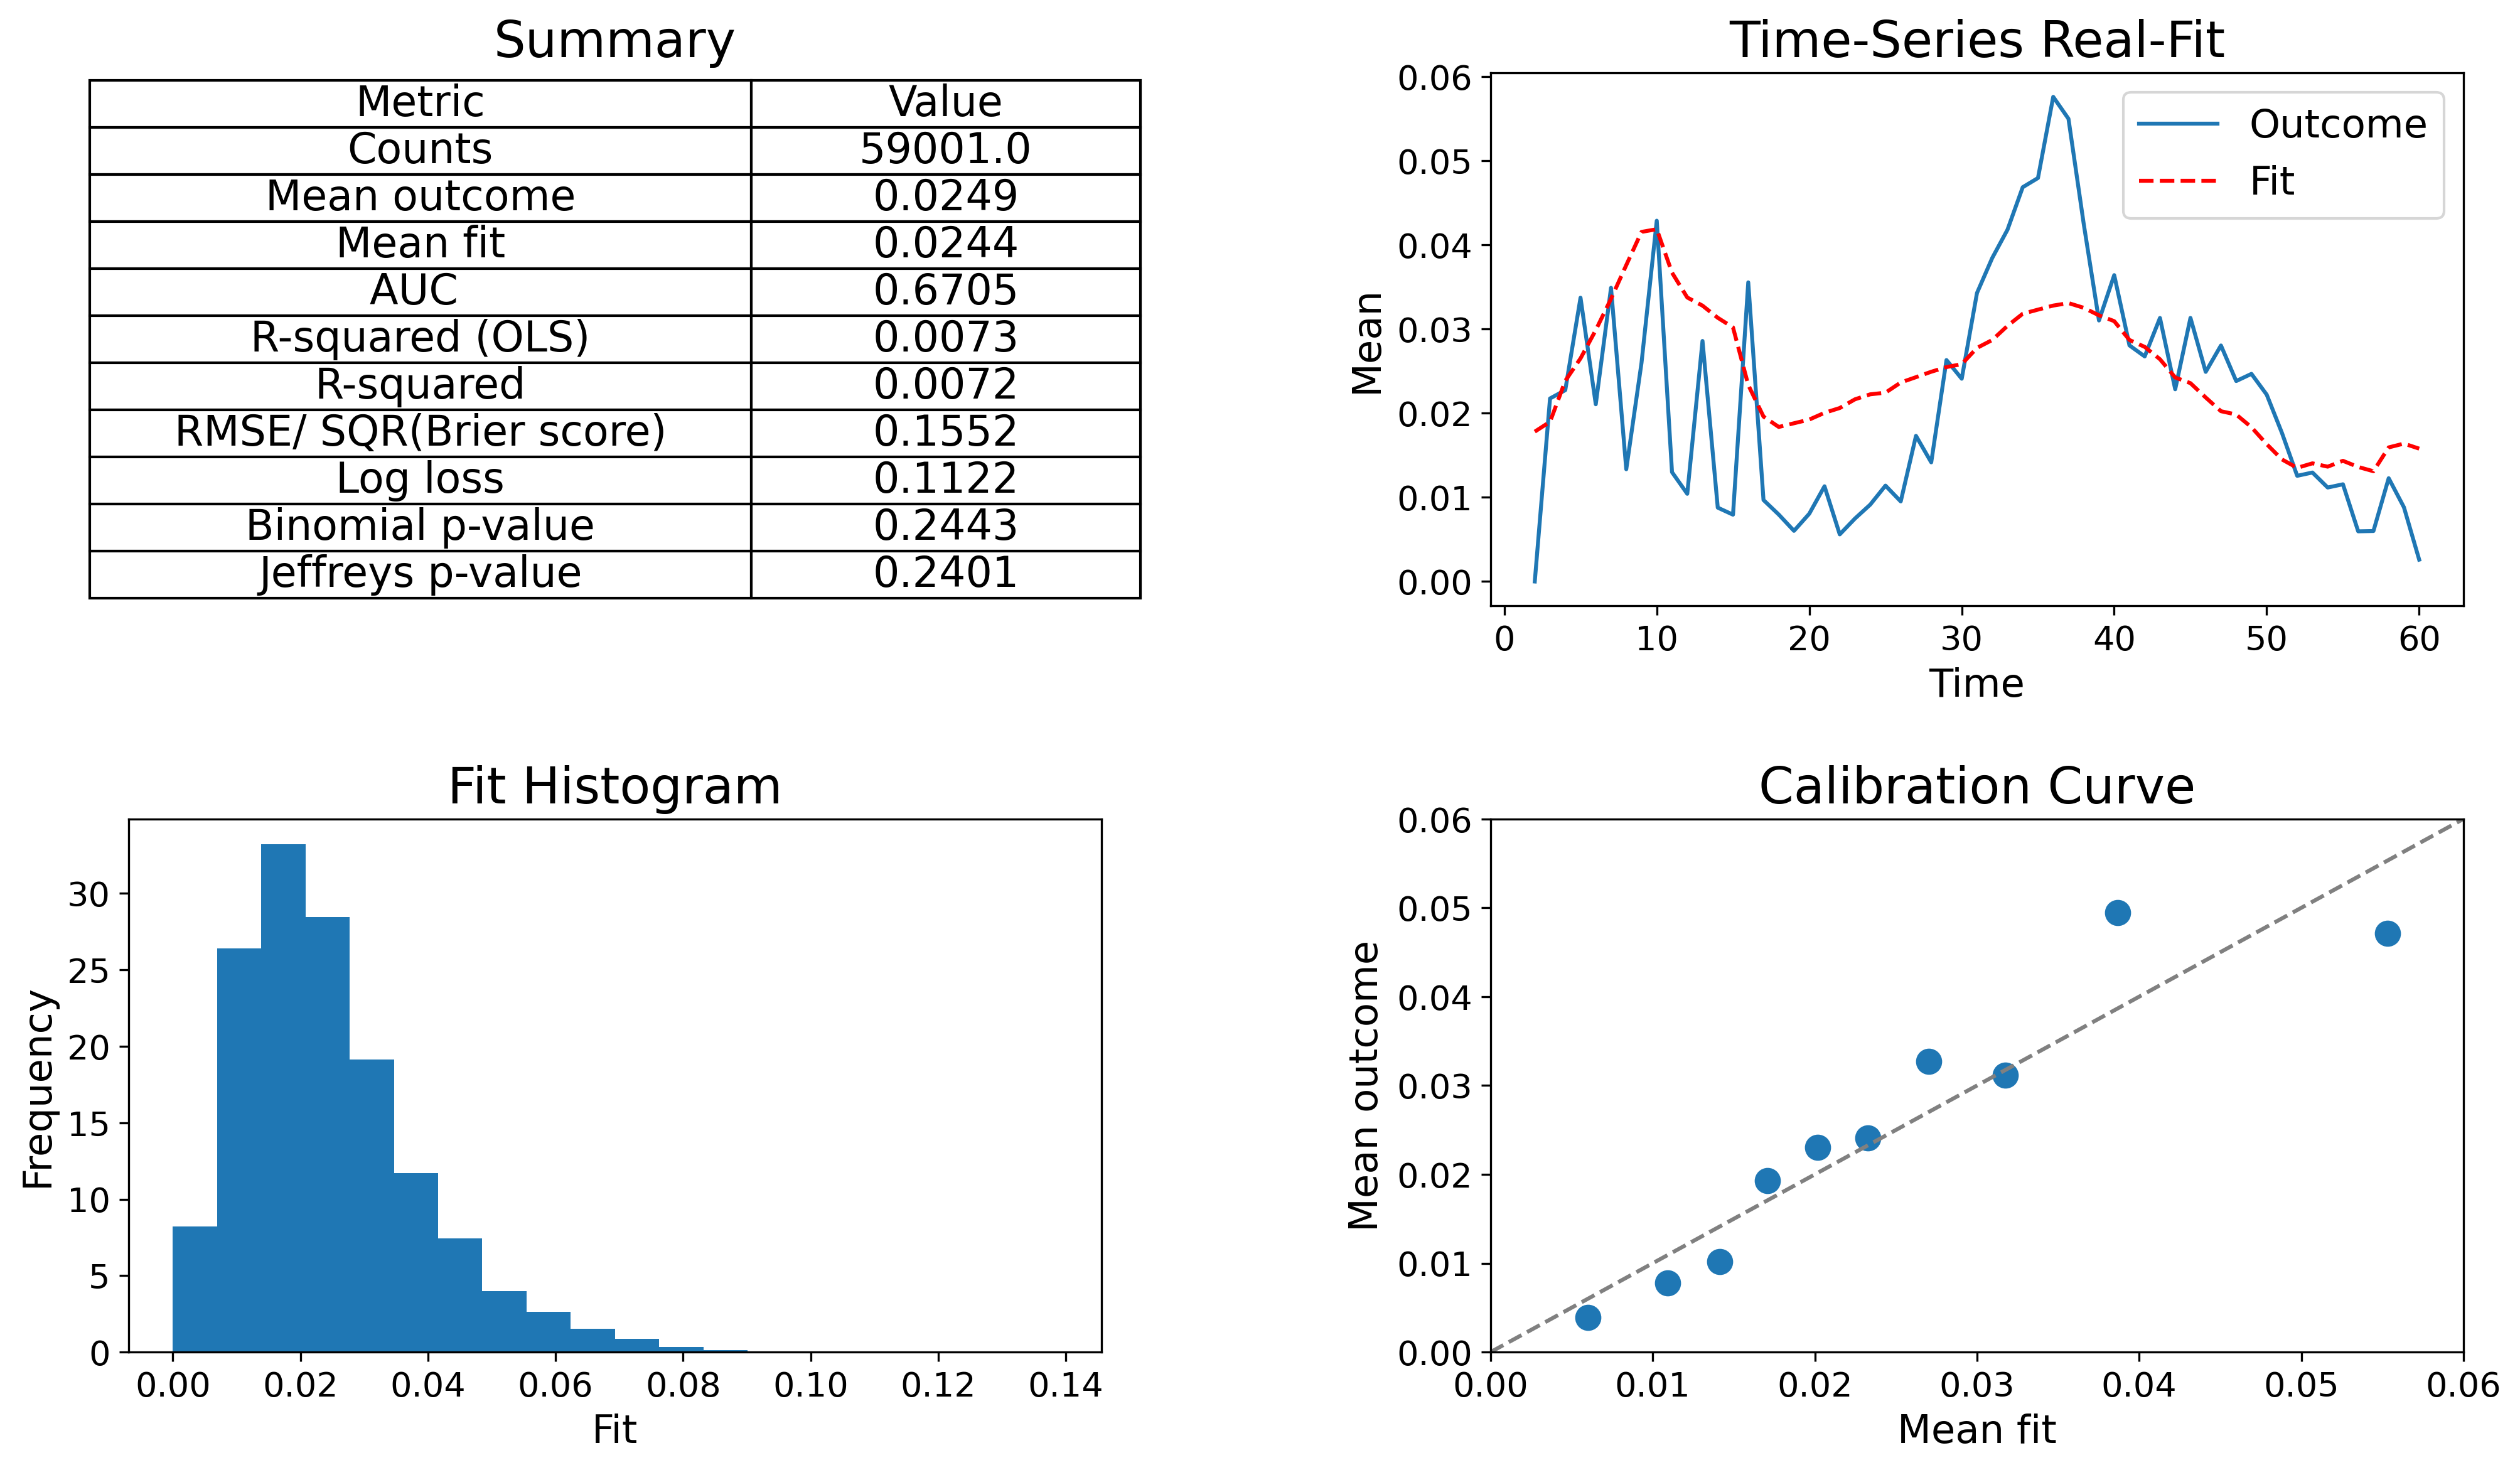

In [108]:
survival = model_cph.predict_survival_function(data[{'FICO_orig_time', 'equity_orig_time', 'age', 'default_time'}].dropna()).transpose()
data3 = pd.concat([data, survival],axis=1, sort=False).reset_index(drop=False)

data3.loc[:,'S1'] = data3.lookup(data3.index, data3['age_1f'])
data3.loc[data3.age_1==0,'S1']=1 
data3.loc[:,'S2'] = data3.lookup(data3.index, data3['age'])

data3.loc[:,'PD_time'] = (data3.loc[:,'S1'] - data3.loc[:,'S2']) / data3.loc[:,'S1']

validation(data3['PD_time'],data3['default_time'],data3['time'])

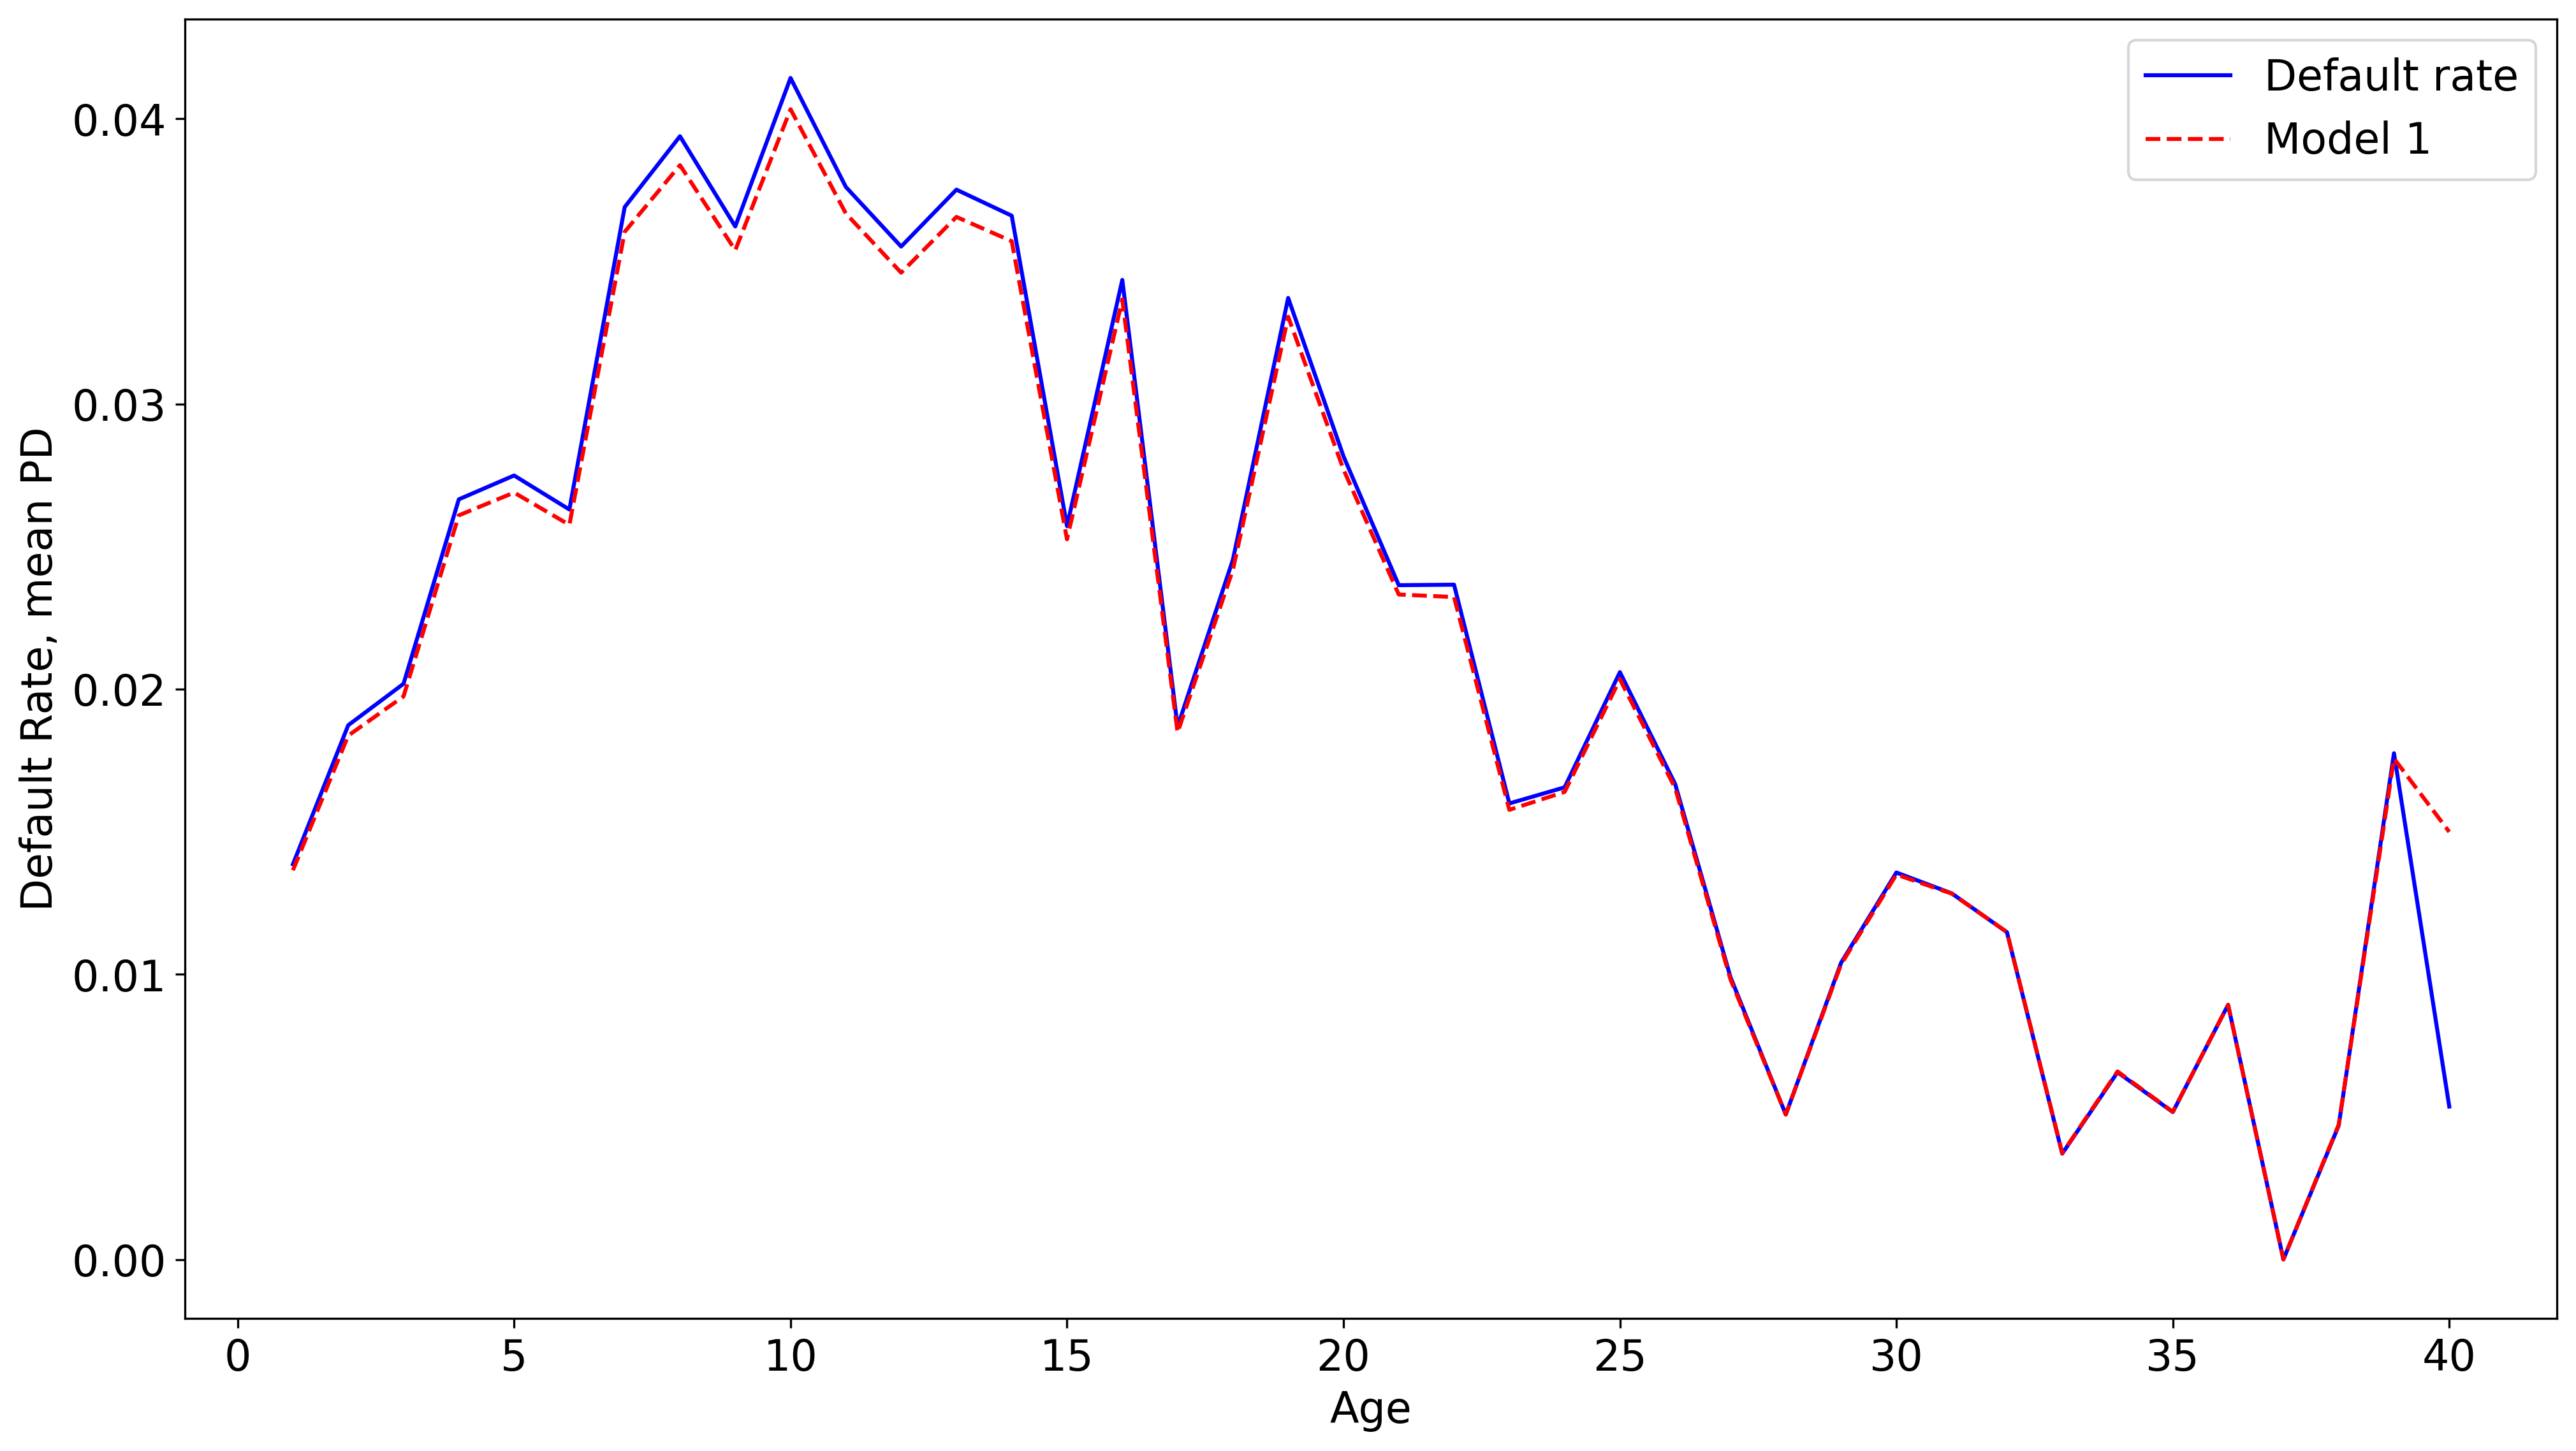

In [109]:
data3_mean_age = data3.groupby('age')[['default_time', 'PD_time']].mean().reset_index().reset_index(drop=False)
data3_mean_age

plt.plot('age', 'default_time', data=data3_mean_age, color='blue', label='Default rate')
plt.plot('age', 'PD_time', data=data3_mean_age, color='red', label='Model 1',linestyle='dashed')
plt.xlabel('Age')
plt.ylabel('Default Rate, mean PD')
plt.legend(loc='best')
plt.show()

# Sandbox Problems

 - Divide the dataset into ten categories with ascending current LTV ratios and an equal amount of default events. Estimate a rating matrix with the migration rates between these four categories and a terminating default category. Compute marginal and cumulative default rates for up to five periods using this migration matrix.
 - Estimate a basic credit risk model for mortgage default probabilities (PD). You may choose a Logit or a Probit model. Include FICO, LTV at origination and age dummies. Explain whether the model is suitable to predict PDs.
 - Estimate a Cox Proportional Hazard model using FICO and LTV at loan origination.

# Copyright and Disclaimer

Copyright: The workshop resources (handbook and codes) provided to you by Deep Credit Risk are
protected by copyright. You are not permitted to distribute or re-use the workshop materials for
commercial purposes without permission of Deep Credit Risk.

Limit of Liability/Disclaimer of Warranty: While the authors and Deep Credit Risk have used their best effort
in preparing this material, they make no representations or warranties with respect to
the accuracy or completeness of the contents and specifically disclaim any implied
warranties of merchantability or fitness for a particular purpose. No warranty may be
created or extended by sales representatives or written sales materials. The advise and
strategies contained herein may not be suitable for your situation. The authors and Deep Credit Risk shall not
be liable for any loss of profit or any other commercial damages, including but not
limited to special, incidental, consequential, or other damages.